# CNN + GlobalAvgPool
Run this model on all lncRNA cell lines using some theshold. This notebook tests RCI GMM(2).

* zero
* RCI threshold set by GMM(2).
* Antilog threshold set by GMM(2).

Show pretty pictures.

10-fold cross-validation.

Compute the sample standard deviation.

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2023-02-06 19:04:18.678544
Python 3.8.10
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=64
FILTERSIZE=16
RCELLS=32
DCELLS=16
EPOCHS=3
FOLDS=10      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=200
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'RCI_GMM'
CACHING = False   # have not worked out how to cache multiple cell lines

In [3]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/


In [4]:
RCI_FILE =      'CNRCI_noncoding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_noncoding_train_transcripts.gc42.csv'
CACHE_SEQUENCE = 'cache.seq.pickle'
CACHE_IDS = 'cache.id.pickle'
if CACHING:
    cache_seq = DATA_DIR+CACHE_SEQUENCE 
    cache_ids = DATA_DIR+CACHE_IDS 
    if isfile(cache_seq) and isfile(cache_ids):
        print('WARNING: this run will read sequence from cache.')
    else:
        print('INFO: this run will write sequence to cache.')

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

EXCLUSIONS = [1,7]   # use these though they are clearly different

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    rci_str = fields[cell_line]
                    if rci_str != "nan":
                        rci_val = float(rci_str)
                        gene_to_rci[gene_id] = rci_val
        print('Number of RCI values loaded',len(gene_to_rci.keys()))
        return gene_to_rci

    def seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        allids=[]
        allseq=[]
        cache_seq = DATA_DIR+CACHE_SEQUENCE 
        cache_ids = DATA_DIR+CACHE_IDS 
        if CACHING and isfile(cache_seq) and isfile(cache_ids):
            # Warning: the cache may represent the wrong K.
            with open(cache_seq,'rb') as fin:
                allseq = pickle.load(fin)
            with open(cache_ids,'rb') as fin:
                allids = pickle.load(fin)
            return allids,allseq           
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        if CACHING:
            with open(cache_seq,'wb') as fout:
                pickle.dump(allseq,fout)
            with open(cache_ids,'wb') as fout:
                pickle.dump(allids,fout)
        return allids,allseq

## Model

In [7]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    #pool_layer = GlobalAveragePooling1D()
    flat_layer = Flatten()
    dens_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(pool_layer)
    cnn.add(flat_layer)
    cnn.add(dens_layer)
    cnn.add(drop_layer)
    cnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return cnn

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-02-06 19:04:47.459174
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4997, 4)           1028      
                                                                 
 conv1d (Conv1D)             (None, 4982, 64)          4160      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 621, 64)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 39744)             0         
                                                                 
 dense (Dense)               (None, 16)                635920    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                             

## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        
    def set_sequences(self, allids, allseq):
        # It is critical to keep IDs and sequences in same order!
        self.all_ids = allids  # pairs of (gene_id,tran_id)
        self.all_seqs = allseq  # may be vectors of K-mers
        genes = []
        for i in range(len(allids)):
            (one_gene,one_tran) = allids[i]
            genes.append(one_gene)
        self.all_genes = genes
            
    def set_rci_map(self, gene_to_rci):
        # The map is for fast lookup, not gene order!
        self.rci_map = gene_to_rci # map gene_id to RCI value
    
    def get_gene_subset(self, sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = self.all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes   # this is a set: unordered with fast lookup
    
    def get_X_y(self, gene_index):
        cnt = len(self.all_ids)
        subsetX=[]
        subsetY=[]
        next_index = 0
        for i in range(cnt):
            if next_index==len(gene_index):
                break
            if i==gene_index[next_index]:
                gene_id,tran_id = self.all_ids[i]
                oneX = self.all_seqs[i]
                oneY = self.rci_map[gene_id]
                subsetX.append(oneX)
                subsetY.append(oneY)
                next_index += 1
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def rcis_to_labels(self, array_of_rci, rci_threshold):
        IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
        return np.array(list(map(IS_CYTO, array_of_rci)))
    
    def choose_rci_threshold(self, rci_values):
        discrim = 0
        if RCI_THRESHOLD_MECHANISM == 'RCI_GMM':
            gmm2 = GaussianMixture(n_components=2, verbose=0, 
                covariance_type='spherical', n_init=10) # best of 10
            gmm2.fit(rci_values)
            # Optimal discriminator = weighted average of means of the 2 gaussians
            discrim = gmm2.weights_[0]*gmm2.means_[0]+gmm2.weights_[1]*gmm2.means_[1]
            print('Model params (mean %.2f, wgt %.2f) (mean %.2f, wgt %.2f)' %
                (gmm2.means_[0], gmm2.weights_[0], gmm2.means_[1], gmm2.weights_[1]))
        return discrim
        
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        cv_auprc=[]
        cv_auroc=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        splits = splitter.split(self.all_genes)
        splitter = None
        for train_index,valid_index in splits:
            fold += 1
            print('Fold',fold)
            X_train,y_train = self.get_X_y(train_index)
            train_based_rci_threshold = self.choose_rci_threshold(y_train)
            y_train = self.rcis_to_labels(y_train,train_based_rci_threshold)
            X_valid,y_valid = self.get_X_y(valid_index)
            y_valid = self.rcis_to_labels(y_valid,train_based_rci_threshold) # yes, train_based
            print('RCI threshold derived from training set:',train_based_rci_threshold)

            #print('Training example')
            #print(X_train[0])
            #print("BUILD MODEL")
            model=build_model()
            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
              epochs=self.epochs, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
              validation_data=(X_valid,y_valid) )
            print("PREDICT")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0)             
            yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            # PRC
            prc_Y, prc_X, prc_bins = precision_recall_curve(y_valid, yhat_pred)
            auprc = auc(prc_X,prc_Y)*100.
            auroc = roc_auc_score(y_valid, yhat_pred)*100.

            if PRETTY_PICTURES:
                pd.DataFrame(history.history).plot(figsize=(8,5))
                plt.grid(True)
                plt.gca().set_ylim(0,1)
                plt.show()

                print('Train set ones/size',
                      np.count_nonzero(y_train),'/',len(y_train))
                print("Compute valiation accuracy")
                print('Valid sizes',X_valid.shape,y_valid.shape)
                print('Valid set ones/size',
                      np.count_nonzero(y_valid),'/',len(y_valid))
                print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
                print('Score threshold',self.score_threshold)
                print('Prediction set ones/size',
                      np.count_nonzero(yhat_classes),'/',len(yhat_classes))
            
                count_ones= len(y_valid[y_valid==1])
                count_zeros= len(y_valid[y_valid==0])
                guess = max(count_ones,count_zeros) / len(y_valid)
                plt.plot(prc_X, prc_Y, marker='.')
                plt.plot([0, 1], [guess,guess], linestyle='--')
                plt.xlabel('Recall')
                plt.ylabel('Precision')
                plt.show()
                # ROC
                fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
                plt.plot(fpr, tpr, marker='.')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.show()
            
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% AUPRC: %.2f%% AUROC: %.2f%%' % (f1,auprc,auroc)) 
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            cv_auprc.append(auprc)
            cv_auroc.append(auroc)
            
            print(datetime.now())
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break

            # There is a memory leak within the fit() command!
            # Each successive call to fit() consumes more memory.
            model = None
            history = None
            prc_Y = None
            prc_X = None
            prc_bins = None
            yhat_classes = None
            X_train = None
            y_train = None
            X_valid = None
            y_valid = None
            tf.keras.backend.clear_session()
            gc.collect()
            time.sleep(1)  # hope gc kicks in
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1, cv_auprc, cv_auroc

2023-02-06 19:04:50.610937
Start cell Line 0 A549
Number of RCI values loaded 1447
Num RCI: 1447
Load sequence...
Cross validation...
2023-02-06 19:05:04.043974
splitting
Fold 1
Model params (mean -0.97, wgt 0.42) (mean 0.59, wgt 0.58)
RCI threshold derived from training set: [-0.07263866]
FIT
2023-02-06 19:05:07.043839
Epoch 1/3
245/245 [==============================] - 10s 12ms/step - loss: 0.6892 - accuracy: 0.5462 - val_loss: 0.6565 - val_accuracy: 0.6018
Epoch 2/3
245/245 [==============================] - 3s 11ms/step - loss: 0.5945 - accuracy: 0.6823 - val_loss: 0.5954 - val_accuracy: 0.6824
Epoch 3/3
245/245 [==============================] - 3s 11ms/step - loss: 0.5067 - accuracy: 0.7524 - val_loss: 0.5302 - val_accuracy: 0.7169
PREDICT
2023-02-06 19:05:23.349545


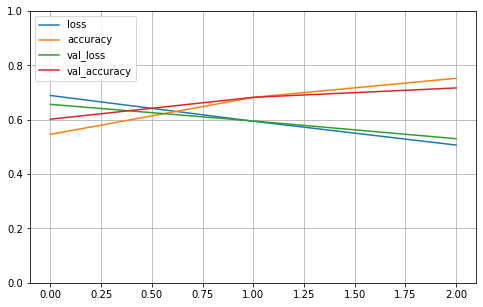

Train set ones/size 4200 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 452 / 869
Range of scores: 0.0073269494 to 0.9793468
Score threshold 0.5
Prediction set ones/size 420 / 869


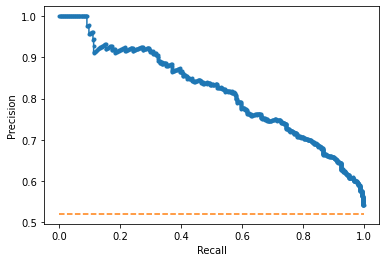

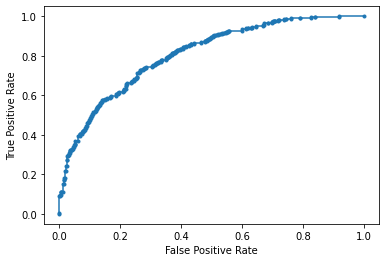

Accuracy: 71.69% Precision: 74.52% Recall: 69.25%
F1: 71.79% AUPRC: 81.76% AUROC: 80.79%
2023-02-06 19:05:24.126323
Fold 2
Model params (mean 0.58, wgt 0.57) (mean -0.97, wgt 0.43)
RCI threshold derived from training set: [-0.08890416]
FIT
2023-02-06 19:05:28.235264
Epoch 1/3
245/245 [==============================] - 3s 12ms/step - loss: 0.6972 - accuracy: 0.5347 - val_loss: 0.6511 - val_accuracy: 0.6479
Epoch 2/3
245/245 [==============================] - 3s 11ms/step - loss: 0.6214 - accuracy: 0.6545 - val_loss: 0.5802 - val_accuracy: 0.6801
Epoch 3/3
245/245 [==============================] - 3s 11ms/step - loss: 0.5247 - accuracy: 0.7378 - val_loss: 0.5316 - val_accuracy: 0.7296
PREDICT
2023-02-06 19:05:37.464783


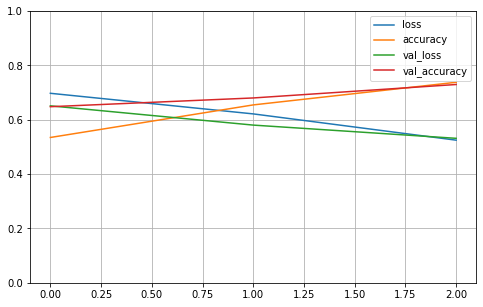

Train set ones/size 4246 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 506 / 869
Range of scores: 0.013300395 to 0.97888196
Score threshold 0.5
Prediction set ones/size 455 / 869


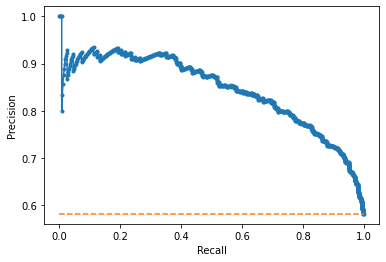

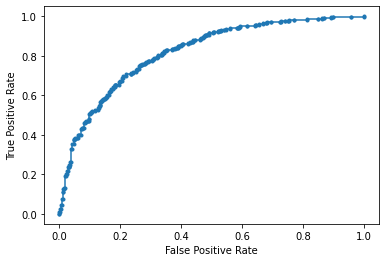

Accuracy: 72.96% Precision: 79.78% Recall: 71.74%
F1: 75.55% AUPRC: 84.46% AUROC: 81.76%
2023-02-06 19:05:38.137925
Fold 3
Model params (mean 0.57, wgt 0.57) (mean -0.94, wgt 0.43)
RCI threshold derived from training set: [-0.08061059]
FIT
2023-02-06 19:05:42.774022
Epoch 1/3
245/245 [==============================] - 3s 12ms/step - loss: 0.6819 - accuracy: 0.5682 - val_loss: 0.6324 - val_accuracy: 0.6536
Epoch 2/3
245/245 [==============================] - 3s 12ms/step - loss: 0.5910 - accuracy: 0.6935 - val_loss: 0.5959 - val_accuracy: 0.6525
Epoch 3/3
245/245 [==============================] - 3s 13ms/step - loss: 0.5053 - accuracy: 0.7554 - val_loss: 0.5532 - val_accuracy: 0.6985
PREDICT
2023-02-06 19:05:52.619042


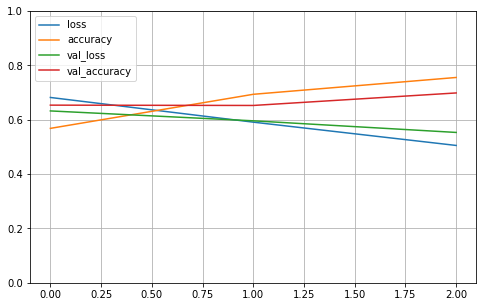

Train set ones/size 4200 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 461 / 869
Range of scores: 0.0057203663 to 0.98549694
Score threshold 0.5
Prediction set ones/size 297 / 869


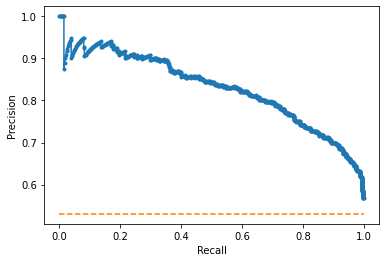

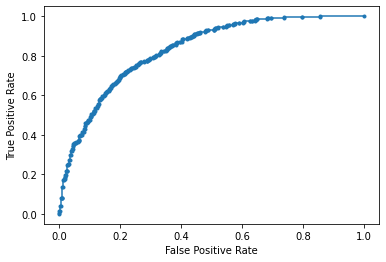

Accuracy: 69.85% Precision: 83.50% Recall: 53.80%
F1: 65.44% AUPRC: 82.99% AUROC: 83.24%
2023-02-06 19:05:53.319482
Fold 4
Model params (mean 0.57, wgt 0.58) (mean -0.95, wgt 0.42)
RCI threshold derived from training set: [-0.0716316]
FIT
2023-02-06 19:05:57.514837
Epoch 1/3
245/245 [==============================] - 3s 12ms/step - loss: 0.6938 - accuracy: 0.5375 - val_loss: 0.6537 - val_accuracy: 0.6099
Epoch 2/3
245/245 [==============================] - 3s 11ms/step - loss: 0.6136 - accuracy: 0.6673 - val_loss: 0.5709 - val_accuracy: 0.7008
Epoch 3/3
245/245 [==============================] - 3s 11ms/step - loss: 0.5083 - accuracy: 0.7461 - val_loss: 0.5297 - val_accuracy: 0.7330
PREDICT
2023-02-06 19:06:08.760840


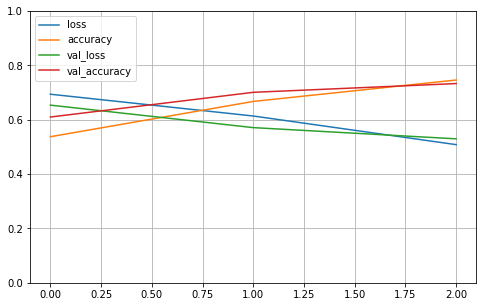

Train set ones/size 4211 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 441 / 869
Range of scores: 0.0056852787 to 0.9866768
Score threshold 0.5
Prediction set ones/size 401 / 869


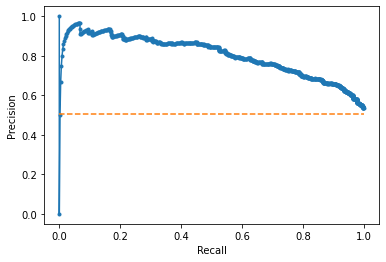

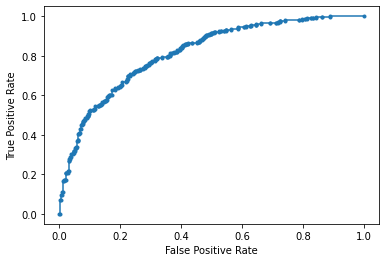

Accuracy: 73.30% Precision: 76.06% Recall: 69.16%
F1: 72.45% AUPRC: 80.31% AUROC: 81.43%
2023-02-06 19:06:09.440935
Fold 5
Model params (mean 0.56, wgt 0.57) (mean -0.94, wgt 0.43)
RCI threshold derived from training set: [-0.07909442]
FIT
2023-02-06 19:06:13.483467
Epoch 1/3
245/245 [==============================] - 3s 12ms/step - loss: 0.6862 - accuracy: 0.5565 - val_loss: 0.6258 - val_accuracy: 0.6720
Epoch 2/3
245/245 [==============================] - 3s 11ms/step - loss: 0.5948 - accuracy: 0.6814 - val_loss: 0.5974 - val_accuracy: 0.6686
Epoch 3/3
245/245 [==============================] - 3s 11ms/step - loss: 0.4931 - accuracy: 0.7657 - val_loss: 0.5070 - val_accuracy: 0.7457
PREDICT
2023-02-06 19:06:22.717853


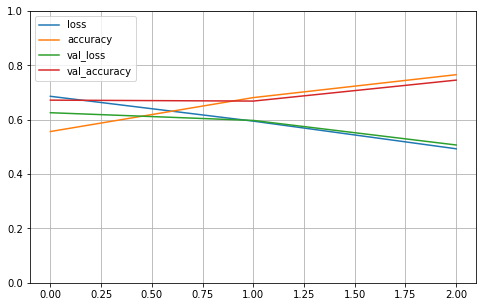

Train set ones/size 4186 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 475 / 869
Range of scores: 0.005961905 to 0.9898325
Score threshold 0.5
Prediction set ones/size 478 / 869


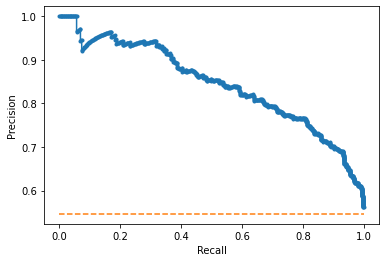

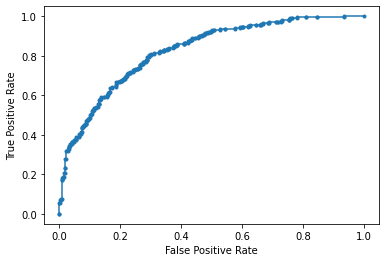

Accuracy: 74.57% Precision: 76.57% Recall: 77.05%
F1: 76.81% AUPRC: 84.54% AUROC: 82.64%
2023-02-06 19:06:23.415757
Fold 6
Model params (mean -0.99, wgt 0.42) (mean 0.59, wgt 0.58)
RCI threshold derived from training set: [-0.08340266]
FIT
2023-02-06 19:06:27.399204
Epoch 1/3
245/245 [==============================] - 3s 12ms/step - loss: 0.6865 - accuracy: 0.5553 - val_loss: 0.6647 - val_accuracy: 0.6041
Epoch 2/3
245/245 [==============================] - 3s 11ms/step - loss: 0.5961 - accuracy: 0.6839 - val_loss: 0.5845 - val_accuracy: 0.6893
Epoch 3/3
245/245 [==============================] - 3s 11ms/step - loss: 0.4946 - accuracy: 0.7599 - val_loss: 0.5819 - val_accuracy: 0.7043
PREDICT
2023-02-06 19:06:38.657488


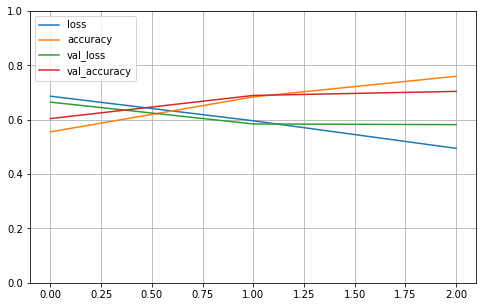

Train set ones/size 4204 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 457 / 869
Range of scores: 0.007197614 to 0.99464095
Score threshold 0.5
Prediction set ones/size 566 / 869


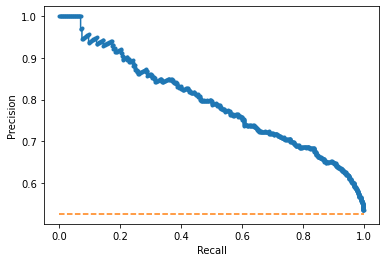

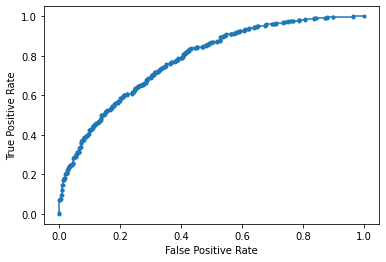

Accuracy: 70.43% Precision: 67.67% Recall: 83.81%
F1: 74.88% AUPRC: 79.40% AUROC: 78.06%
2023-02-06 19:06:39.345363
Fold 7
Model params (mean -0.96, wgt 0.43) (mean 0.60, wgt 0.57)
RCI threshold derived from training set: [-0.07222989]
FIT
2023-02-06 19:06:43.417640
Epoch 1/3
245/245 [==============================] - 4s 12ms/step - loss: 0.6892 - accuracy: 0.5485 - val_loss: 0.6343 - val_accuracy: 0.6548
Epoch 2/3
245/245 [==============================] - 3s 11ms/step - loss: 0.5991 - accuracy: 0.6742 - val_loss: 0.5791 - val_accuracy: 0.6916
Epoch 3/3
245/245 [==============================] - 3s 11ms/step - loss: 0.4966 - accuracy: 0.7627 - val_loss: 0.5477 - val_accuracy: 0.7204
PREDICT
2023-02-06 19:06:54.686900


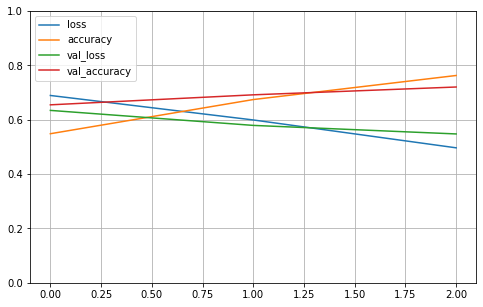

Train set ones/size 4172 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 480 / 869
Range of scores: 0.0019835813 to 0.98425055
Score threshold 0.5
Prediction set ones/size 437 / 869


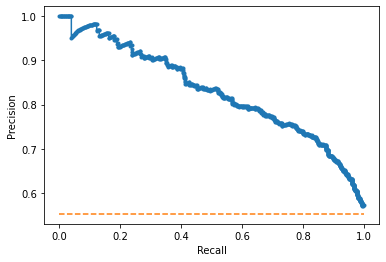

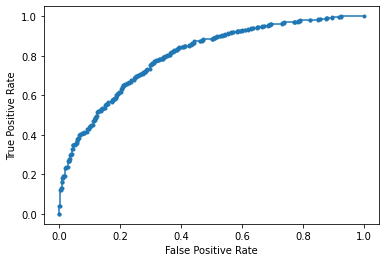

Accuracy: 72.04% Precision: 77.12% Recall: 70.21%
F1: 73.50% AUPRC: 83.04% AUROC: 80.18%
2023-02-06 19:06:55.367869
Fold 8
Model params (mean 0.57, wgt 0.57) (mean -0.94, wgt 0.43)
RCI threshold derived from training set: [-0.07443659]
FIT
2023-02-06 19:06:59.804632
Epoch 1/3
245/245 [==============================] - 4s 12ms/step - loss: 0.6926 - accuracy: 0.5470 - val_loss: 0.6496 - val_accuracy: 0.6325
Epoch 2/3
245/245 [==============================] - 3s 11ms/step - loss: 0.6073 - accuracy: 0.6726 - val_loss: 0.5559 - val_accuracy: 0.7166
Epoch 3/3
245/245 [==============================] - 3s 11ms/step - loss: 0.5025 - accuracy: 0.7519 - val_loss: 0.5199 - val_accuracy: 0.7362
PREDICT
2023-02-06 19:07:11.080136


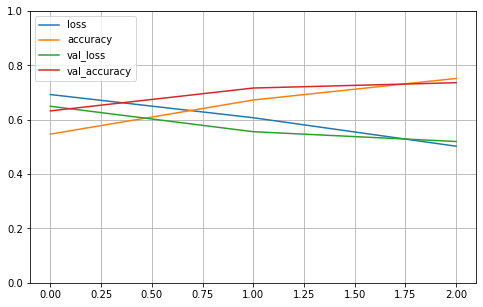

Train set ones/size 4194 / 7819
Compute valiation accuracy
Valid sizes (868, 4997) (868,)
Valid set ones/size 458 / 868
Range of scores: 0.023309391 to 0.9980902
Score threshold 0.5
Prediction set ones/size 539 / 868


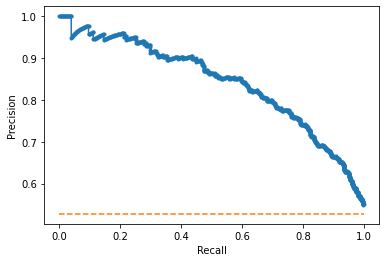

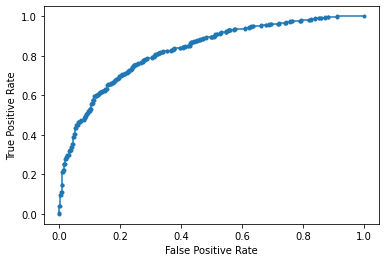

Accuracy: 73.62% Precision: 71.24% Recall: 83.84%
F1: 77.03% AUPRC: 84.28% AUROC: 82.72%
2023-02-06 19:07:11.733561
Fold 9
Model params (mean -0.93, wgt 0.43) (mean 0.56, wgt 0.57)
RCI threshold derived from training set: [-0.08124539]
FIT
2023-02-06 19:07:15.869337
Epoch 1/3
245/245 [==============================] - 4s 12ms/step - loss: 0.6896 - accuracy: 0.5517 - val_loss: 0.6537 - val_accuracy: 0.6210
Epoch 2/3
245/245 [==============================] - 3s 11ms/step - loss: 0.6081 - accuracy: 0.6684 - val_loss: 0.5328 - val_accuracy: 0.7235
Epoch 3/3
245/245 [==============================] - 3s 11ms/step - loss: 0.5041 - accuracy: 0.7475 - val_loss: 0.4704 - val_accuracy: 0.7615
PREDICT
2023-02-06 19:07:27.150807


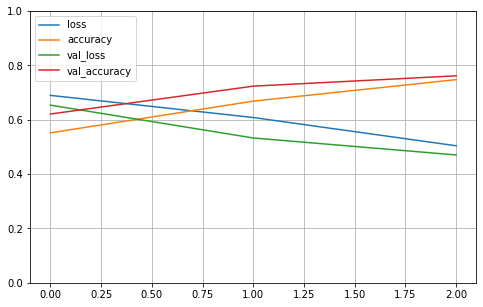

Train set ones/size 4190 / 7819
Compute valiation accuracy
Valid sizes (868, 4997) (868,)
Valid set ones/size 471 / 868
Range of scores: 0.0015678052 to 0.9922996
Score threshold 0.5
Prediction set ones/size 494 / 868


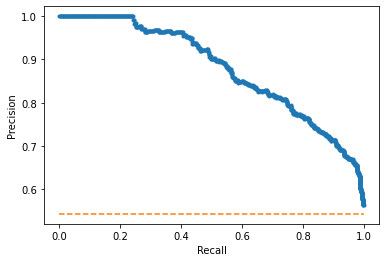

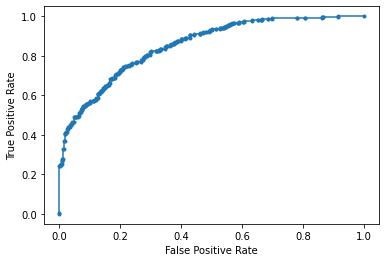

Accuracy: 76.15% Precision: 76.72% Recall: 80.47%
F1: 78.55% AUPRC: 87.95% AUROC: 85.32%
2023-02-06 19:07:27.877604
Fold 10
Model params (mean 0.57, wgt 0.57) (mean -0.94, wgt 0.43)
RCI threshold derived from training set: [-0.07852758]
FIT
2023-02-06 19:07:31.940836
Epoch 1/3
245/245 [==============================] - 4s 13ms/step - loss: 0.6934 - accuracy: 0.5453 - val_loss: 0.6574 - val_accuracy: 0.6106
Epoch 2/3
245/245 [==============================] - 3s 11ms/step - loss: 0.6309 - accuracy: 0.6429 - val_loss: 0.5774 - val_accuracy: 0.6855
Epoch 3/3
245/245 [==============================] - 3s 11ms/step - loss: 0.5460 - accuracy: 0.7254 - val_loss: 0.5314 - val_accuracy: 0.7154
PREDICT
2023-02-06 19:07:43.248893


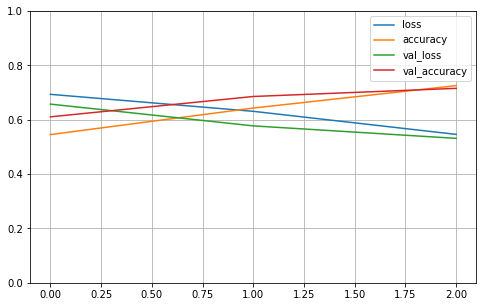

Train set ones/size 4192 / 7819
Compute valiation accuracy
Valid sizes (868, 4997) (868,)
Valid set ones/size 469 / 868
Range of scores: 0.019433513 to 0.98724943
Score threshold 0.5
Prediction set ones/size 438 / 868


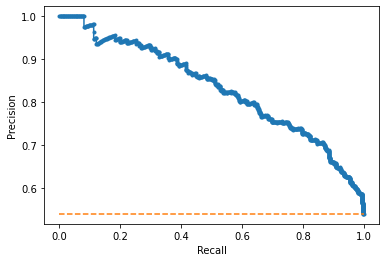

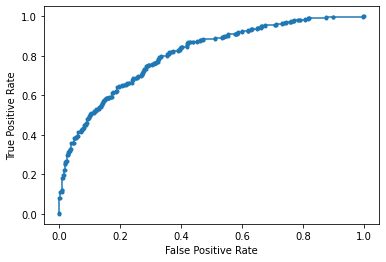

Accuracy: 71.54% Precision: 75.34% Recall: 70.36%
F1: 72.77% AUPRC: 83.37% AUROC: 80.81%
2023-02-06 19:07:43.945379

Completed cross validation 10 folds 3 epochs
 accuracy mean 72.61% +/- 1.91
 precision mean 75.85% +/- 4.31
 recall mean 72.97% +/- 8.95
 F1 mean 73.88% +/- 3.70
 AUPRC mean 83.21% +/- 2.41
 AUROC mean 81.70% +/- 1.96
Finished cell Line 0 A549

2023-02-06 19:07:45.330794
Start cell Line 1 H1.hESC
Number of RCI values loaded 3327
Num RCI: 3327
Load sequence...
Cross validation...
2023-02-06 19:08:07.781999
splitting
Fold 1
Model params (mean -0.95, wgt 0.52) (mean 0.42, wgt 0.48)
RCI threshold derived from training set: [-0.28605039]
FIT
2023-02-06 19:08:12.807461
Epoch 1/3
466/466 [==============================] - 6s 12ms/step - loss: 0.6687 - accuracy: 0.5889 - val_loss: 0.6662 - val_accuracy: 0.6100
Epoch 2/3
466/466 [==============================] - 5s 11ms/step - loss: 0.6161 - accuracy: 0.6553 - val_loss: 0.6105 - val_accuracy: 0.6590
Epoch 3/3
466/466 [==========

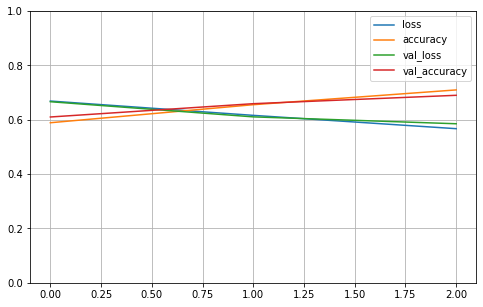

Train set ones/size 7436 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 828 / 1654
Range of scores: 0.01303174 to 0.99483126
Score threshold 0.5
Prediction set ones/size 701 / 1654


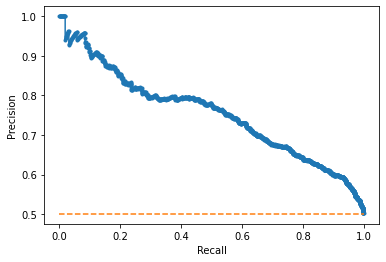

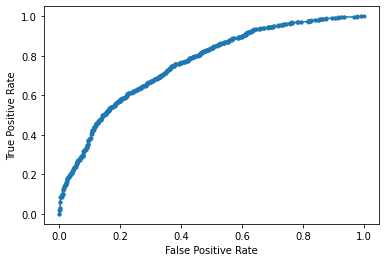

Accuracy: 68.98% Precision: 72.47% Recall: 61.35%
F1: 66.45% AUPRC: 75.48% AUROC: 76.16%
2023-02-06 19:08:31.493907
Fold 2
Model params (mean 0.44, wgt 0.48) (mean -0.93, wgt 0.52)
RCI threshold derived from training set: [-0.27678289]
FIT
2023-02-06 19:08:37.754116
Epoch 1/3
466/466 [==============================] - 6s 12ms/step - loss: 0.6689 - accuracy: 0.5873 - val_loss: 0.6493 - val_accuracy: 0.6070
Epoch 2/3
466/466 [==============================] - 5s 11ms/step - loss: 0.6112 - accuracy: 0.6679 - val_loss: 0.5986 - val_accuracy: 0.6687
Epoch 3/3
466/466 [==============================] - 5s 11ms/step - loss: 0.5638 - accuracy: 0.7094 - val_loss: 0.5748 - val_accuracy: 0.6886
PREDICT
2023-02-06 19:08:59.725073


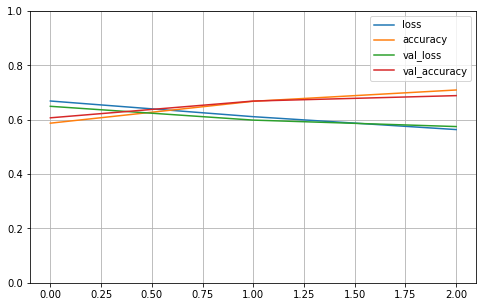

Train set ones/size 7472 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 789 / 1654
Range of scores: 0.017289218 to 0.9904005
Score threshold 0.5
Prediction set ones/size 672 / 1654


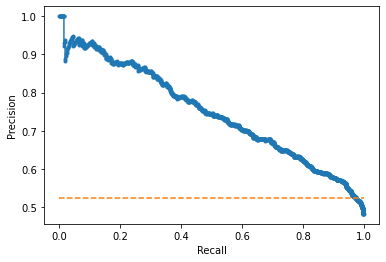

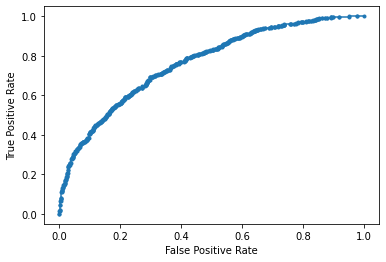

Accuracy: 68.86% Precision: 70.39% Recall: 59.95%
F1: 64.75% AUPRC: 74.86% AUROC: 76.46%
2023-02-06 19:09:00.544089
Fold 3
Model params (mean -0.93, wgt 0.52) (mean 0.43, wgt 0.48)
RCI threshold derived from training set: [-0.28464163]
FIT
2023-02-06 19:09:07.228624
Epoch 1/3
466/466 [==============================] - 6s 12ms/step - loss: 0.6671 - accuracy: 0.5876 - val_loss: 0.6759 - val_accuracy: 0.5786
Epoch 2/3
466/466 [==============================] - 5s 12ms/step - loss: 0.6151 - accuracy: 0.6624 - val_loss: 0.6122 - val_accuracy: 0.6542
Epoch 3/3
466/466 [==============================] - 5s 11ms/step - loss: 0.5740 - accuracy: 0.7020 - val_loss: 0.5913 - val_accuracy: 0.6705
PREDICT
2023-02-06 19:09:25.167399


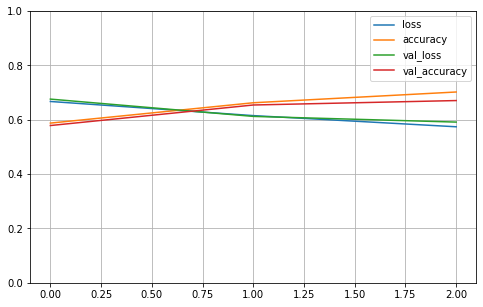

Train set ones/size 7418 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 846 / 1654
Range of scores: 0.018995898 to 0.98524183
Score threshold 0.5
Prediction set ones/size 897 / 1654


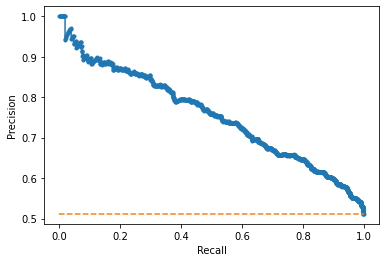

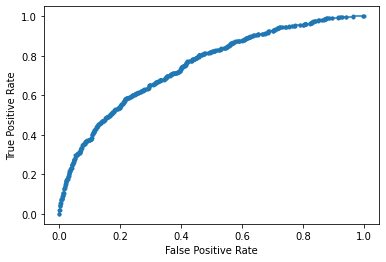

Accuracy: 67.05% Precision: 66.78% Recall: 70.80%
F1: 68.73% AUPRC: 75.59% AUROC: 74.81%
2023-02-06 19:09:26.098967
Fold 4
Model params (mean -0.93, wgt 0.52) (mean 0.42, wgt 0.48)
RCI threshold derived from training set: [-0.28410603]
FIT
2023-02-06 19:09:32.358821
Epoch 1/3
466/466 [==============================] - 6s 12ms/step - loss: 0.6750 - accuracy: 0.5738 - val_loss: 0.6305 - val_accuracy: 0.6354
Epoch 2/3
466/466 [==============================] - 5s 11ms/step - loss: 0.6116 - accuracy: 0.6673 - val_loss: 0.5892 - val_accuracy: 0.6856
Epoch 3/3
466/466 [==============================] - 5s 12ms/step - loss: 0.5626 - accuracy: 0.7115 - val_loss: 0.5790 - val_accuracy: 0.6959
PREDICT
2023-02-06 19:09:54.354555


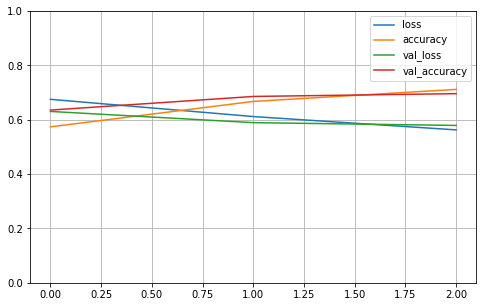

Train set ones/size 7416 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 848 / 1654
Range of scores: 0.055588387 to 0.9966949
Score threshold 0.5
Prediction set ones/size 1031 / 1654


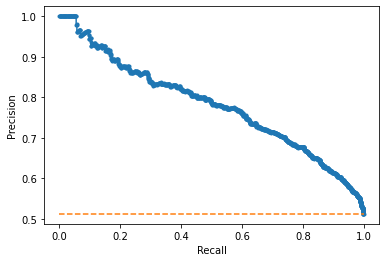

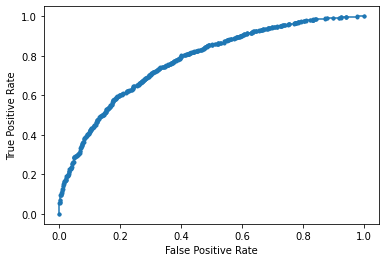

Accuracy: 69.59% Precision: 66.73% Recall: 81.13%
F1: 73.23% AUPRC: 78.17% AUROC: 77.48%
2023-02-06 19:09:55.186940
Fold 5
Model params (mean 0.42, wgt 0.48) (mean -0.94, wgt 0.52)
RCI threshold derived from training set: [-0.28881233]
FIT
2023-02-06 19:10:01.386349
Epoch 1/3
466/466 [==============================] - 6s 12ms/step - loss: 0.6671 - accuracy: 0.5894 - val_loss: 0.6318 - val_accuracy: 0.6421
Epoch 2/3
466/466 [==============================] - 5s 11ms/step - loss: 0.6191 - accuracy: 0.6598 - val_loss: 0.6439 - val_accuracy: 0.6209
Epoch 3/3
466/466 [==============================] - 5s 12ms/step - loss: 0.5671 - accuracy: 0.7059 - val_loss: 0.5511 - val_accuracy: 0.7237
PREDICT
2023-02-06 19:10:19.360736


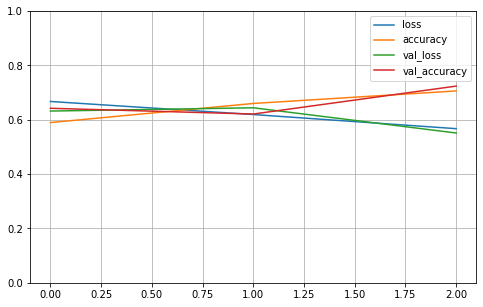

Train set ones/size 7408 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 856 / 1654
Range of scores: 0.019046342 to 0.9876766
Score threshold 0.5
Prediction set ones/size 785 / 1654


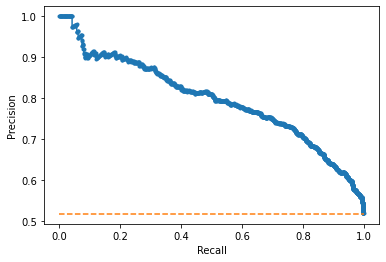

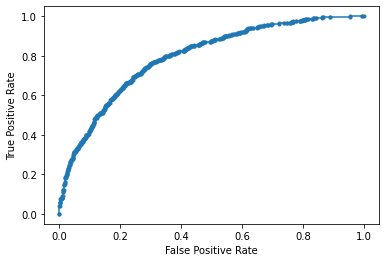

Accuracy: 72.37% Precision: 75.41% Recall: 69.16%
F1: 72.15% AUPRC: 79.72% AUROC: 79.51%
2023-02-06 19:10:20.267943
Fold 6
Model params (mean -0.94, wgt 0.52) (mean 0.43, wgt 0.48)
RCI threshold derived from training set: [-0.28585481]
FIT
2023-02-06 19:10:26.621870
Epoch 1/3
466/466 [==============================] - 6s 12ms/step - loss: 0.6748 - accuracy: 0.5779 - val_loss: 0.6521 - val_accuracy: 0.6221
Epoch 2/3
466/466 [==============================] - 5s 12ms/step - loss: 0.6229 - accuracy: 0.6546 - val_loss: 0.6300 - val_accuracy: 0.6415
Epoch 3/3
466/466 [==============================] - 5s 12ms/step - loss: 0.5723 - accuracy: 0.7033 - val_loss: 0.5795 - val_accuracy: 0.6898
PREDICT
2023-02-06 19:10:48.611598


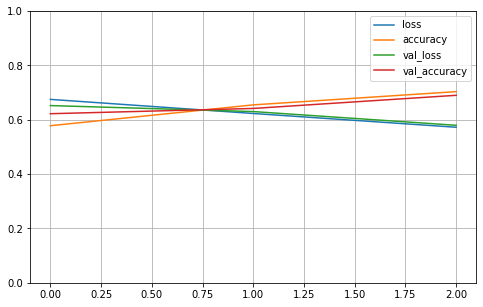

Train set ones/size 7422 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 842 / 1654
Range of scores: 0.014838046 to 0.982107
Score threshold 0.5
Prediction set ones/size 931 / 1654


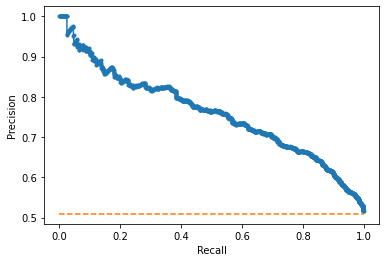

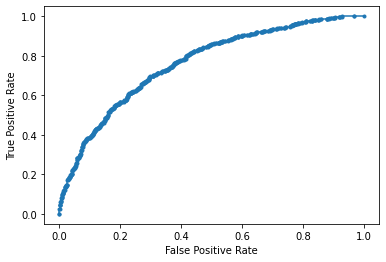

Accuracy: 68.98% Precision: 67.67% Recall: 74.82%
F1: 71.07% AUPRC: 76.01% AUROC: 76.24%
2023-02-06 19:10:49.527537
Fold 7
Model params (mean -0.94, wgt 0.52) (mean 0.42, wgt 0.48)
RCI threshold derived from training set: [-0.28354508]
FIT
2023-02-06 19:10:56.420190
Epoch 1/3
466/466 [==============================] - 6s 12ms/step - loss: 0.6745 - accuracy: 0.5721 - val_loss: 0.6173 - val_accuracy: 0.6594
Epoch 2/3
466/466 [==============================] - 5s 12ms/step - loss: 0.6258 - accuracy: 0.6493 - val_loss: 0.6140 - val_accuracy: 0.6576
Epoch 3/3
466/466 [==============================] - 5s 12ms/step - loss: 0.5701 - accuracy: 0.7039 - val_loss: 0.5325 - val_accuracy: 0.7387
PREDICT
2023-02-06 19:11:14.532820


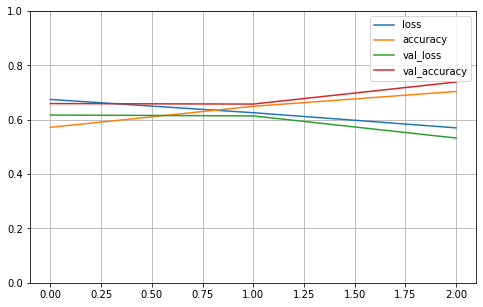

Train set ones/size 7446 / 14883
Compute valiation accuracy
Valid sizes (1653, 4997) (1653,)
Valid set ones/size 818 / 1653
Range of scores: 0.0039537717 to 0.9913099
Score threshold 0.5
Prediction set ones/size 844 / 1653


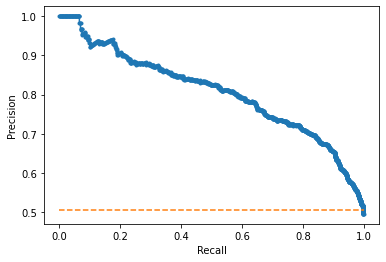

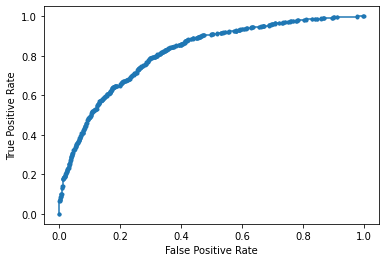

Accuracy: 73.87% Precision: 72.87% Recall: 75.18%
F1: 74.01% AUPRC: 80.69% AUROC: 81.57%
2023-02-06 19:11:15.318393
Fold 8
Model params (mean 0.41, wgt 0.50) (mean -0.96, wgt 0.50)
RCI threshold derived from training set: [-0.27972969]
FIT
2023-02-06 19:11:21.651457
Epoch 1/3
466/466 [==============================] - 6s 12ms/step - loss: 0.6725 - accuracy: 0.5713 - val_loss: 0.6436 - val_accuracy: 0.6213
Epoch 2/3
466/466 [==============================] - 5s 12ms/step - loss: 0.6171 - accuracy: 0.6582 - val_loss: 0.6053 - val_accuracy: 0.6673
Epoch 3/3
466/466 [==============================] - 5s 12ms/step - loss: 0.5643 - accuracy: 0.7055 - val_loss: 0.5967 - val_accuracy: 0.6776
PREDICT
2023-02-06 19:11:39.857173


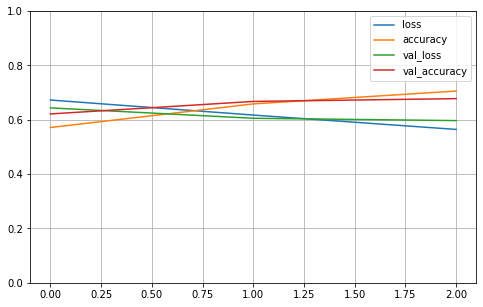

Train set ones/size 7448 / 14883
Compute valiation accuracy
Valid sizes (1653, 4997) (1653,)
Valid set ones/size 813 / 1653
Range of scores: 0.024791248 to 0.99566394
Score threshold 0.5
Prediction set ones/size 1076 / 1653


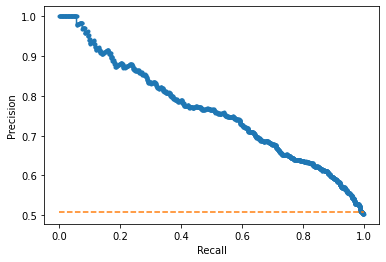

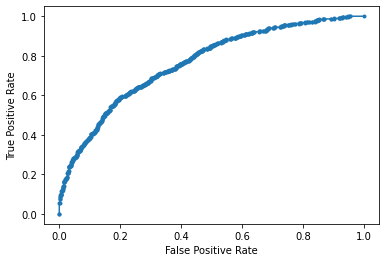

Accuracy: 67.76% Precision: 63.01% Recall: 83.39%
F1: 71.78% AUPRC: 76.12% AUROC: 76.41%
2023-02-06 19:11:40.662009
Fold 9
Model params (mean -0.94, wgt 0.52) (mean 0.43, wgt 0.48)
RCI threshold derived from training set: [-0.2802677]
FIT
2023-02-06 19:11:47.002992
Epoch 1/3
466/466 [==============================] - 6s 12ms/step - loss: 0.6717 - accuracy: 0.5827 - val_loss: 0.6285 - val_accuracy: 0.6497
Epoch 2/3
466/466 [==============================] - 5s 12ms/step - loss: 0.6119 - accuracy: 0.6669 - val_loss: 0.5967 - val_accuracy: 0.6721
Epoch 3/3
466/466 [==============================] - 6s 12ms/step - loss: 0.5524 - accuracy: 0.7141 - val_loss: 0.5810 - val_accuracy: 0.6927
PREDICT
2023-02-06 19:12:08.972420


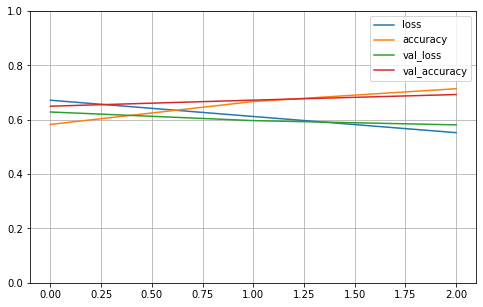

Train set ones/size 7456 / 14883
Compute valiation accuracy
Valid sizes (1653, 4997) (1653,)
Valid set ones/size 805 / 1653
Range of scores: 0.01624333 to 0.99496526
Score threshold 0.5
Prediction set ones/size 1073 / 1653


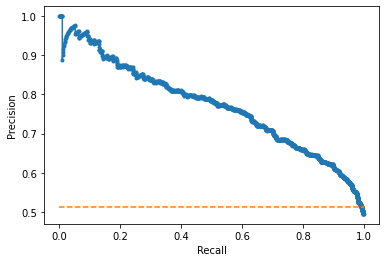

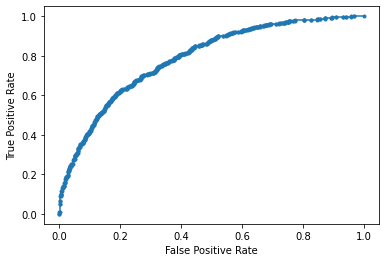

Accuracy: 69.27% Precision: 63.84% Recall: 85.09%
F1: 72.95% AUPRC: 77.18% AUROC: 78.78%
2023-02-06 19:12:09.905328
Fold 10
Model params (mean -0.95, wgt 0.52) (mean 0.42, wgt 0.48)
RCI threshold derived from training set: [-0.28432213]
FIT
2023-02-06 19:12:16.187911
Epoch 1/3
466/466 [==============================] - 7s 13ms/step - loss: 0.6815 - accuracy: 0.5618 - val_loss: 0.6491 - val_accuracy: 0.6165
Epoch 2/3
466/466 [==============================] - 6s 12ms/step - loss: 0.6253 - accuracy: 0.6493 - val_loss: 0.6293 - val_accuracy: 0.6491
Epoch 3/3
466/466 [==============================] - 5s 12ms/step - loss: 0.5668 - accuracy: 0.7046 - val_loss: 0.5836 - val_accuracy: 0.6860
PREDICT
2023-02-06 19:12:34.854034


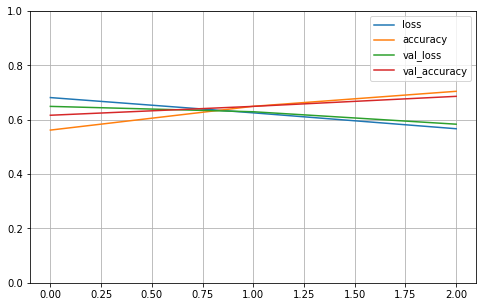

Train set ones/size 7445 / 14883
Compute valiation accuracy
Valid sizes (1653, 4997) (1653,)
Valid set ones/size 819 / 1653
Range of scores: 0.026356967 to 0.9915495
Score threshold 0.5
Prediction set ones/size 992 / 1653


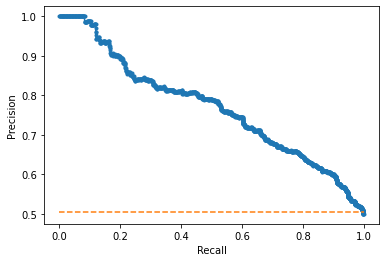

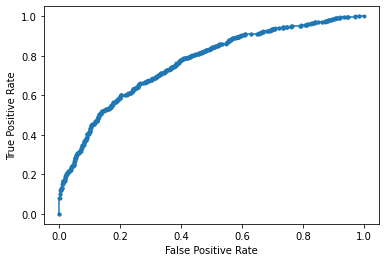

Accuracy: 68.60% Precision: 65.12% Recall: 78.88%
F1: 71.34% AUPRC: 76.98% AUROC: 76.53%
2023-02-06 19:12:35.794823

Completed cross validation 10 folds 3 epochs
 accuracy mean 69.53% +/- 2.06
 precision mean 68.43% +/- 4.17
 recall mean 73.98% +/- 8.69
 F1 mean 70.65% +/- 3.05
 AUPRC mean 77.08% +/- 1.91
 AUROC mean 77.39% +/- 2.00
Finished cell Line 1 H1.hESC

2023-02-06 19:12:37.385466
Start cell Line 2 HeLa.S3
Number of RCI values loaded 919
Num RCI: 919
Load sequence...
Cross validation...
2023-02-06 19:12:45.268903
splitting
Fold 1
Model params (mean 0.21, wgt 0.38) (mean -2.22, wgt 0.62)
RCI threshold derived from training set: [-1.28353994]
FIT
2023-02-06 19:12:47.324576
Epoch 1/3
164/164 [==============================] - 3s 13ms/step - loss: 0.6980 - accuracy: 0.5303 - val_loss: 0.6614 - val_accuracy: 0.5952
Epoch 2/3
164/164 [==============================] - 2s 12ms/step - loss: 0.6184 - accuracy: 0.6515 - val_loss: 0.5416 - val_accuracy: 0.7067
Epoch 3/3
164/164 [=========

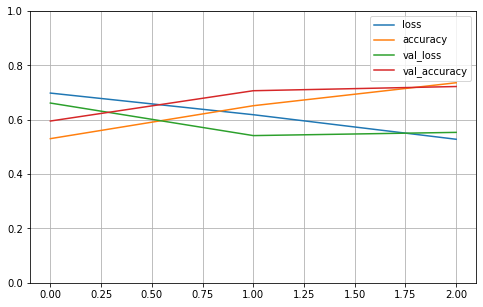

Train set ones/size 2529 / 5240
Compute valiation accuracy
Valid sizes (583, 4997) (583,)
Valid set ones/size 277 / 583
Range of scores: 0.002606399 to 0.9512801
Score threshold 0.5
Prediction set ones/size 141 / 583


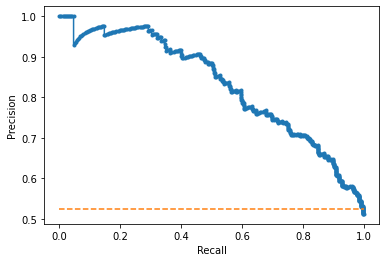

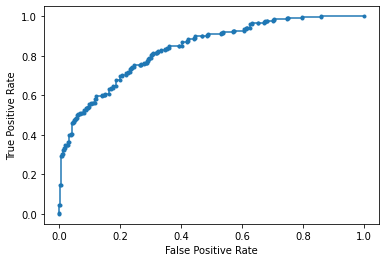

Accuracy: 72.21% Precision: 90.78% Recall: 46.21%
F1: 61.24% AUPRC: 83.17% AUROC: 83.69%
2023-02-06 19:12:54.820273
Fold 2
Model params (mean -2.20, wgt 0.62) (mean 0.24, wgt 0.38)
RCI threshold derived from training set: [-1.28043433]
FIT
2023-02-06 19:12:58.027450
Epoch 1/3
164/164 [==============================] - 3s 13ms/step - loss: 0.7034 - accuracy: 0.5179 - val_loss: 0.6762 - val_accuracy: 0.5832
Epoch 2/3
164/164 [==============================] - 2s 12ms/step - loss: 0.6241 - accuracy: 0.6506 - val_loss: 0.5695 - val_accuracy: 0.6964
Epoch 3/3
164/164 [==============================] - 2s 12ms/step - loss: 0.5079 - accuracy: 0.7492 - val_loss: 0.5188 - val_accuracy: 0.7479
PREDICT
2023-02-06 19:13:04.981994


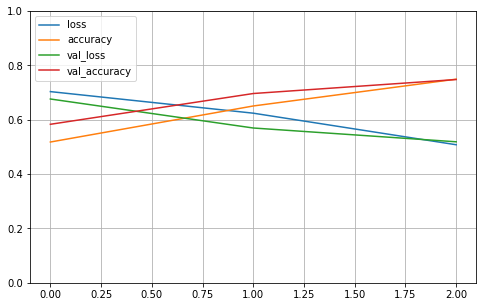

Train set ones/size 2532 / 5240
Compute valiation accuracy
Valid sizes (583, 4997) (583,)
Valid set ones/size 274 / 583
Range of scores: 0.0022767794 to 0.978384
Score threshold 0.5
Prediction set ones/size 217 / 583


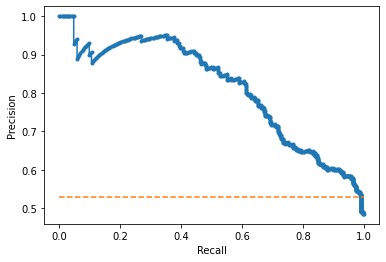

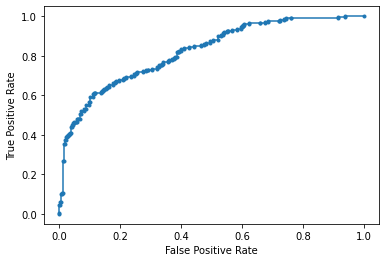

Accuracy: 74.79% Precision: 79.26% Recall: 62.77%
F1: 70.06% AUPRC: 81.34% AUROC: 82.27%
2023-02-06 19:13:05.566679
Fold 3
Model params (mean -2.20, wgt 0.62) (mean 0.24, wgt 0.38)
RCI threshold derived from training set: [-1.27761953]
FIT
2023-02-06 19:13:08.918779
Epoch 1/3
164/164 [==============================] - 3s 13ms/step - loss: 0.6923 - accuracy: 0.5338 - val_loss: 0.6519 - val_accuracy: 0.6518
Epoch 2/3
164/164 [==============================] - 2s 12ms/step - loss: 0.6139 - accuracy: 0.6620 - val_loss: 0.5465 - val_accuracy: 0.7290
Epoch 3/3
164/164 [==============================] - 2s 12ms/step - loss: 0.5208 - accuracy: 0.7431 - val_loss: 0.5655 - val_accuracy: 0.6947
PREDICT
2023-02-06 19:13:15.942089


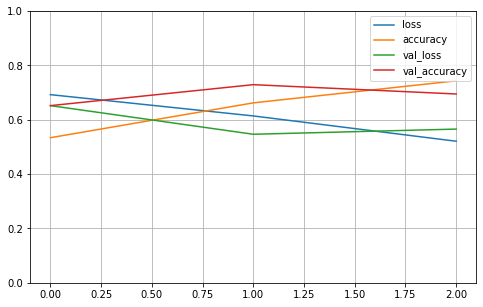

Train set ones/size 2501 / 5240
Compute valiation accuracy
Valid sizes (583, 4997) (583,)
Valid set ones/size 265 / 583
Range of scores: 0.0045474954 to 0.95813805
Score threshold 0.5
Prediction set ones/size 123 / 583


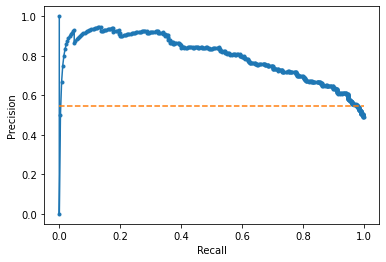

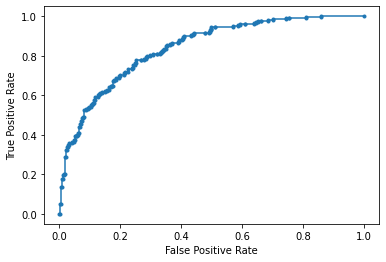

Accuracy: 69.47% Precision: 85.37% Recall: 39.62%
F1: 54.12% AUPRC: 79.74% AUROC: 83.97%
2023-02-06 19:13:16.548505
Fold 4
Model params (mean -2.21, wgt 0.62) (mean 0.23, wgt 0.38)
RCI threshold derived from training set: [-1.2759837]
FIT
2023-02-06 19:13:19.929709
Epoch 1/3
164/164 [==============================] - 3s 14ms/step - loss: 0.7055 - accuracy: 0.5142 - val_loss: 0.6913 - val_accuracy: 0.5395
Epoch 2/3
164/164 [==============================] - 2s 12ms/step - loss: 0.6630 - accuracy: 0.5867 - val_loss: 0.6138 - val_accuracy: 0.6323
Epoch 3/3
164/164 [==============================] - 2s 12ms/step - loss: 0.5423 - accuracy: 0.7235 - val_loss: 0.5334 - val_accuracy: 0.7440
PREDICT
2023-02-06 19:13:27.086324


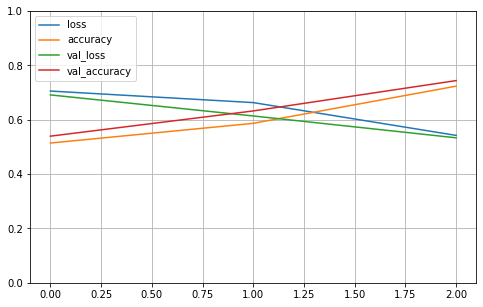

Train set ones/size 2508 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 258 / 582
Range of scores: 0.009937578 to 0.97701627
Score threshold 0.5
Prediction set ones/size 191 / 582


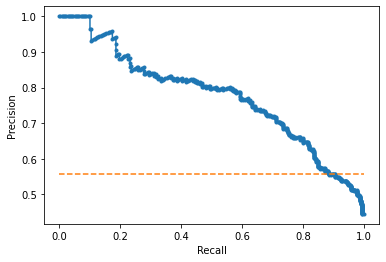

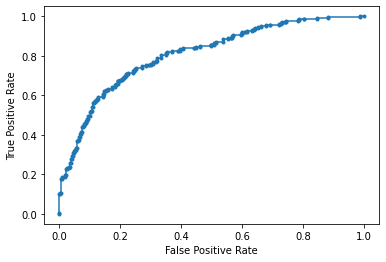

Accuracy: 74.40% Precision: 78.53% Recall: 58.14%
F1: 66.82% AUPRC: 77.77% AUROC: 80.80%
2023-02-06 19:13:27.769952
Fold 5
Model params (mean 0.24, wgt 0.38) (mean -2.22, wgt 0.62)
RCI threshold derived from training set: [-1.2879645]
FIT
2023-02-06 19:13:31.395231
Epoch 1/3
164/164 [==============================] - 3s 14ms/step - loss: 0.7047 - accuracy: 0.5228 - val_loss: 0.6825 - val_accuracy: 0.5636
Epoch 2/3
164/164 [==============================] - 2s 12ms/step - loss: 0.6541 - accuracy: 0.6115 - val_loss: 0.5937 - val_accuracy: 0.6856
Epoch 3/3
164/164 [==============================] - 2s 12ms/step - loss: 0.5558 - accuracy: 0.7172 - val_loss: 0.5542 - val_accuracy: 0.7165
PREDICT
2023-02-06 19:13:42.547431


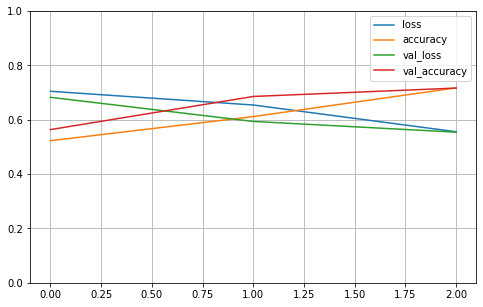

Train set ones/size 2523 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 284 / 582
Range of scores: 0.0058437684 to 0.95524347
Score threshold 0.5
Prediction set ones/size 171 / 582


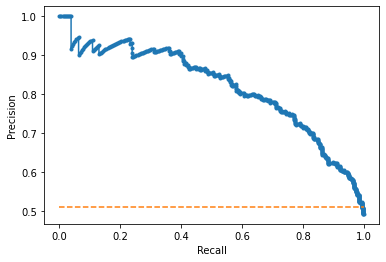

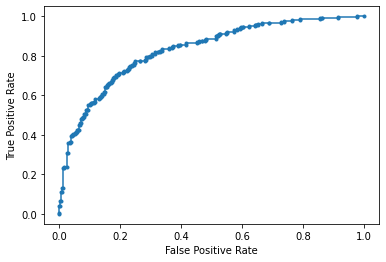

Accuracy: 71.65% Precision: 84.80% Recall: 51.06%
F1: 63.74% AUPRC: 82.00% AUROC: 82.90%
2023-02-06 19:13:43.169788
Fold 6
Model params (mean 0.22, wgt 0.38) (mean -2.20, wgt 0.62)
RCI threshold derived from training set: [-1.28563843]
FIT
2023-02-06 19:13:46.396126
Epoch 1/3
164/164 [==============================] - 3s 13ms/step - loss: 0.7005 - accuracy: 0.5121 - val_loss: 0.6753 - val_accuracy: 0.5876
Epoch 2/3
164/164 [==============================] - 2s 12ms/step - loss: 0.6044 - accuracy: 0.6774 - val_loss: 0.5361 - val_accuracy: 0.7251
Epoch 3/3
164/164 [==============================] - 2s 12ms/step - loss: 0.4698 - accuracy: 0.7790 - val_loss: 0.4944 - val_accuracy: 0.7715
PREDICT
2023-02-06 19:13:57.532963


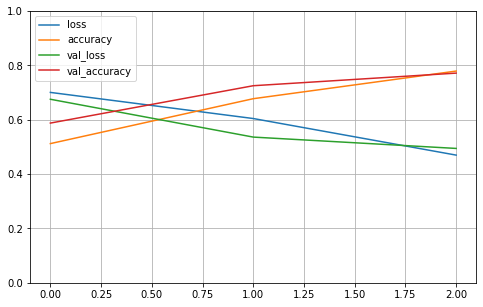

Train set ones/size 2525 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 282 / 582
Range of scores: 0.0057709557 to 0.99294466
Score threshold 0.5
Prediction set ones/size 307 / 582


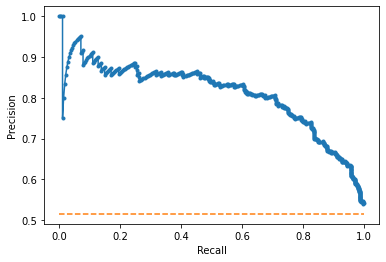

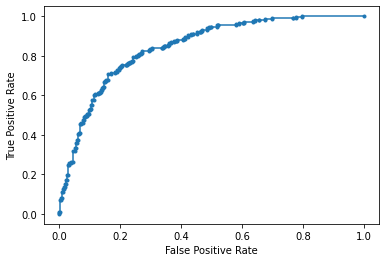

Accuracy: 77.15% Precision: 74.27% Recall: 80.85%
F1: 77.42% AUPRC: 81.00% AUROC: 84.53%
2023-02-06 19:13:58.162041
Fold 7
Model params (mean 0.21, wgt 0.38) (mean -2.23, wgt 0.62)
RCI threshold derived from training set: [-1.30077618]
FIT
2023-02-06 19:14:01.472654
Epoch 1/3
164/164 [==============================] - 3s 13ms/step - loss: 0.6992 - accuracy: 0.5238 - val_loss: 0.6879 - val_accuracy: 0.4983
Epoch 2/3
164/164 [==============================] - 2s 12ms/step - loss: 0.6099 - accuracy: 0.6651 - val_loss: 0.5147 - val_accuracy: 0.7491
Epoch 3/3
164/164 [==============================] - 2s 12ms/step - loss: 0.5046 - accuracy: 0.7535 - val_loss: 0.4521 - val_accuracy: 0.7852
PREDICT
2023-02-06 19:14:12.624510


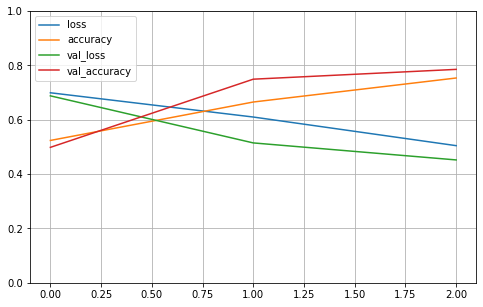

Train set ones/size 2520 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 303 / 582
Range of scores: 0.011875582 to 0.9958675
Score threshold 0.5
Prediction set ones/size 314 / 582


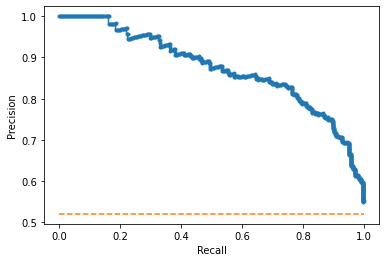

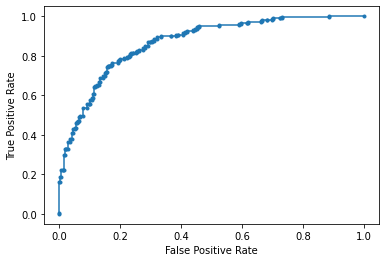

Accuracy: 78.52% Precision: 78.34% Recall: 81.19%
F1: 79.74% AUPRC: 87.39% AUROC: 86.81%
2023-02-06 19:14:13.247934
Fold 8
Model params (mean -2.21, wgt 0.62) (mean 0.25, wgt 0.38)
RCI threshold derived from training set: [-1.27880085]
FIT
2023-02-06 19:14:16.407257
Epoch 1/3
164/164 [==============================] - 3s 13ms/step - loss: 0.7005 - accuracy: 0.5266 - val_loss: 0.6725 - val_accuracy: 0.5412
Epoch 2/3
164/164 [==============================] - 2s 12ms/step - loss: 0.6164 - accuracy: 0.6581 - val_loss: 0.6239 - val_accuracy: 0.6460
Epoch 3/3
164/164 [==============================] - 2s 12ms/step - loss: 0.5091 - accuracy: 0.7514 - val_loss: 0.5627 - val_accuracy: 0.7148
PREDICT
2023-02-06 19:14:27.562764


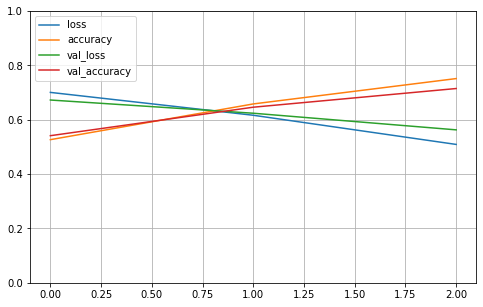

Train set ones/size 2529 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 277 / 582
Range of scores: 0.0018175824 to 0.97157526
Score threshold 0.5
Prediction set ones/size 225 / 582


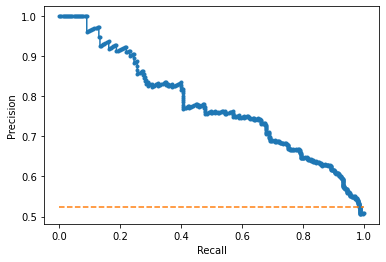

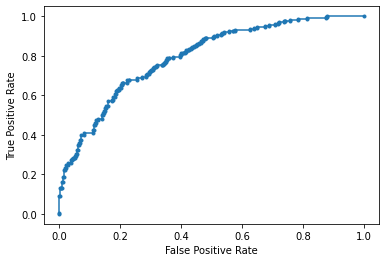

Accuracy: 71.48% Precision: 74.67% Recall: 60.65%
F1: 66.93% AUPRC: 77.87% AUROC: 79.50%
2023-02-06 19:14:28.210560
Fold 9
Model params (mean -2.21, wgt 0.63) (mean 0.24, wgt 0.37)
RCI threshold derived from training set: [-1.29686939]
FIT
2023-02-06 19:14:31.687589
Epoch 1/3
164/164 [==============================] - 3s 14ms/step - loss: 0.7020 - accuracy: 0.5127 - val_loss: 0.7181 - val_accuracy: 0.4691
Epoch 2/3
164/164 [==============================] - 2s 12ms/step - loss: 0.6649 - accuracy: 0.5932 - val_loss: 0.6198 - val_accuracy: 0.6615
Epoch 3/3
164/164 [==============================] - 2s 13ms/step - loss: 0.5452 - accuracy: 0.7216 - val_loss: 0.5061 - val_accuracy: 0.7320
PREDICT
2023-02-06 19:14:38.928048


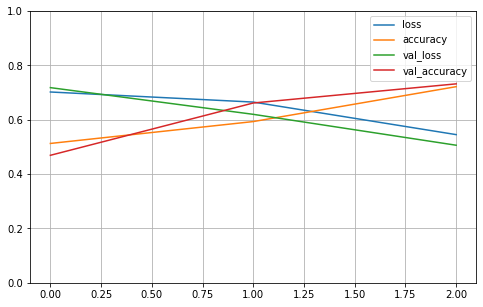

Train set ones/size 2498 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 309 / 582
Range of scores: 0.014717021 to 0.97781664
Score threshold 0.5
Prediction set ones/size 301 / 582


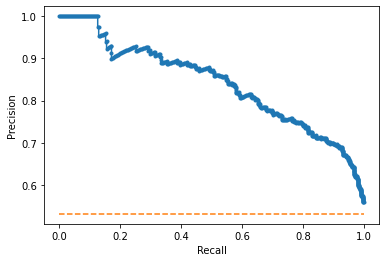

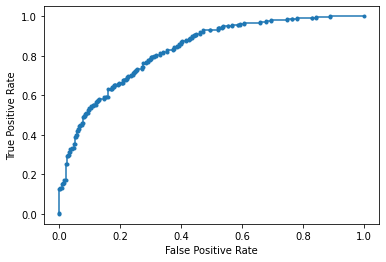

Accuracy: 73.20% Precision: 75.42% Recall: 73.46%
F1: 74.43% AUPRC: 84.08% AUROC: 82.95%
2023-02-06 19:14:39.524866
Fold 10
Model params (mean -2.23, wgt 0.61) (mean 0.18, wgt 0.39)
RCI threshold derived from training set: [-1.29071335]
FIT
2023-02-06 19:14:42.663521
Epoch 1/3
164/164 [==============================] - 3s 14ms/step - loss: 0.6996 - accuracy: 0.5304 - val_loss: 0.6793 - val_accuracy: 0.5447
Epoch 2/3
164/164 [==============================] - 2s 12ms/step - loss: 0.6280 - accuracy: 0.6459 - val_loss: 0.5512 - val_accuracy: 0.7010
Epoch 3/3
164/164 [==============================] - 2s 12ms/step - loss: 0.5473 - accuracy: 0.7260 - val_loss: 0.5529 - val_accuracy: 0.6993
PREDICT
2023-02-06 19:14:49.896909


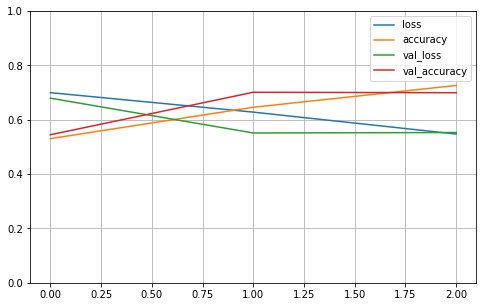

Train set ones/size 2534 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 273 / 582
Range of scores: 0.009529373 to 0.9290199
Score threshold 0.5
Prediction set ones/size 162 / 582


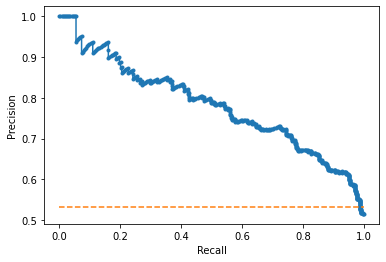

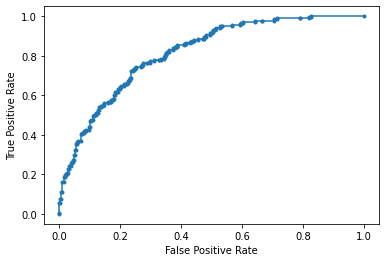

Accuracy: 69.93% Precision: 80.25% Recall: 47.62%
F1: 59.77% AUPRC: 78.27% AUROC: 81.58%
2023-02-06 19:14:50.556273

Completed cross validation 10 folds 3 epochs
 accuracy mean 73.28% +/- 2.96
 precision mean 80.17% +/- 5.33
 recall mean 60.16% +/- 14.59
 F1 mean 67.43% +/- 8.13
 AUPRC mean 81.26% +/- 3.07
 AUROC mean 82.90% +/- 2.05
Finished cell Line 2 HeLa.S3

2023-02-06 19:14:51.883891
Start cell Line 3 HepG2
Number of RCI values loaded 1362
Num RCI: 1362
Load sequence...
Cross validation...
2023-02-06 19:15:03.474940
splitting
Fold 1
Model params (mean -1.90, wgt 0.61) (mean 0.20, wgt 0.39)
RCI threshold derived from training set: [-1.08396547]
FIT
2023-02-06 19:15:06.111243
Epoch 1/3
238/238 [==============================] - 4s 13ms/step - loss: 0.6965 - accuracy: 0.5306 - val_loss: 0.6516 - val_accuracy: 0.6185
Epoch 2/3
238/238 [==============================] - 3s 12ms/step - loss: 0.6095 - accuracy: 0.6665 - val_loss: 0.5627 - val_accuracy: 0.7026
Epoch 3/3
238/238 [========

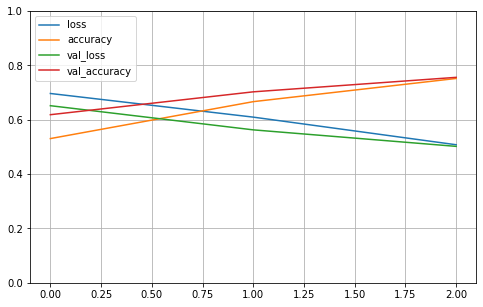

Train set ones/size 3643 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 415 / 844
Range of scores: 0.00071275944 to 0.99404436
Score threshold 0.5
Prediction set ones/size 445 / 844


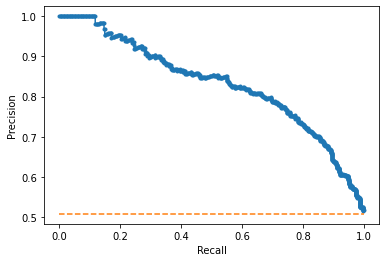

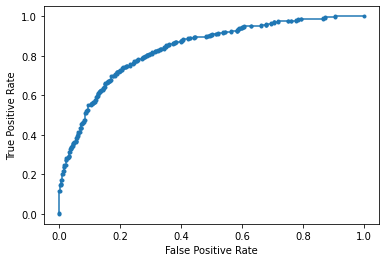

Accuracy: 75.59% Precision: 73.48% Recall: 78.80%
F1: 76.05% AUPRC: 83.26% AUROC: 83.54%
2023-02-06 19:15:18.082297
Fold 2
Model params (mean -1.89, wgt 0.61) (mean 0.20, wgt 0.39)
RCI threshold derived from training set: [-1.08015167]
FIT
2023-02-06 19:15:22.315730
Epoch 1/3
238/238 [==============================] - 4s 13ms/step - loss: 0.6876 - accuracy: 0.5381 - val_loss: 0.6411 - val_accuracy: 0.6209
Epoch 2/3
238/238 [==============================] - 3s 12ms/step - loss: 0.6165 - accuracy: 0.6595 - val_loss: 0.5714 - val_accuracy: 0.6896
Epoch 3/3
238/238 [==============================] - 3s 12ms/step - loss: 0.5412 - accuracy: 0.7267 - val_loss: 0.5105 - val_accuracy: 0.7559
PREDICT
2023-02-06 19:15:32.179109


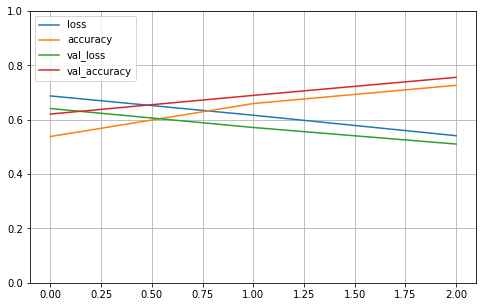

Train set ones/size 3642 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 400 / 844
Range of scores: 0.008334691 to 0.96597975
Score threshold 0.5
Prediction set ones/size 364 / 844


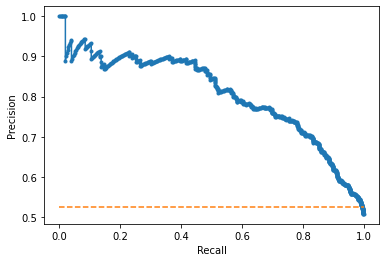

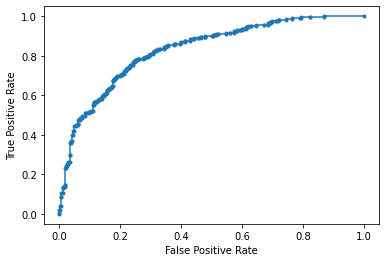

Accuracy: 75.59% Precision: 76.65% Recall: 69.75%
F1: 73.04% AUPRC: 80.66% AUROC: 83.15%
2023-02-06 19:15:32.872849
Fold 3
Model params (mean 0.18, wgt 0.39) (mean -1.89, wgt 0.61)
RCI threshold derived from training set: [-1.07553429]
FIT
2023-02-06 19:15:37.217287
Epoch 1/3
238/238 [==============================] - 4s 13ms/step - loss: 0.7003 - accuracy: 0.5256 - val_loss: 0.6614 - val_accuracy: 0.6102
Epoch 2/3
238/238 [==============================] - 3s 12ms/step - loss: 0.6177 - accuracy: 0.6532 - val_loss: 0.5627 - val_accuracy: 0.7038
Epoch 3/3
238/238 [==============================] - 3s 12ms/step - loss: 0.5040 - accuracy: 0.7490 - val_loss: 0.5253 - val_accuracy: 0.7227
PREDICT
2023-02-06 19:15:48.529209


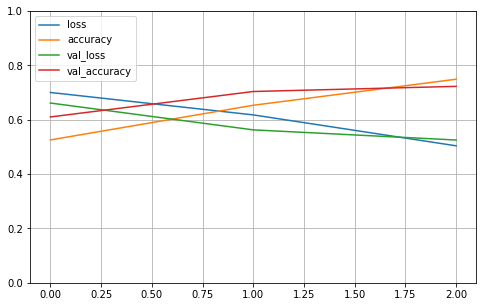

Train set ones/size 3656 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 386 / 844
Range of scores: 0.002600594 to 0.9777435
Score threshold 0.5
Prediction set ones/size 290 / 844


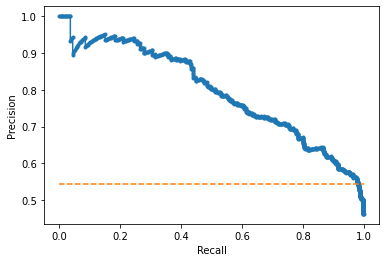

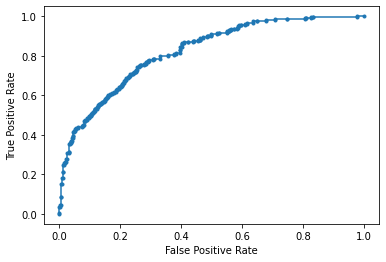

Accuracy: 72.27% Precision: 76.21% Recall: 57.25%
F1: 65.38% AUPRC: 79.59% AUROC: 82.16%
2023-02-06 19:15:49.224966
Fold 4
Model params (mean -1.90, wgt 0.61) (mean 0.20, wgt 0.39)
RCI threshold derived from training set: [-1.07985061]
FIT
2023-02-06 19:15:53.202214
Epoch 1/3
238/238 [==============================] - 4s 13ms/step - loss: 0.6970 - accuracy: 0.5252 - val_loss: 0.6492 - val_accuracy: 0.6327
Epoch 2/3
238/238 [==============================] - 3s 12ms/step - loss: 0.6091 - accuracy: 0.6643 - val_loss: 0.5904 - val_accuracy: 0.6967
Epoch 3/3
238/238 [==============================] - 3s 12ms/step - loss: 0.5357 - accuracy: 0.7363 - val_loss: 0.5895 - val_accuracy: 0.6884
PREDICT
2023-02-06 19:16:03.005137


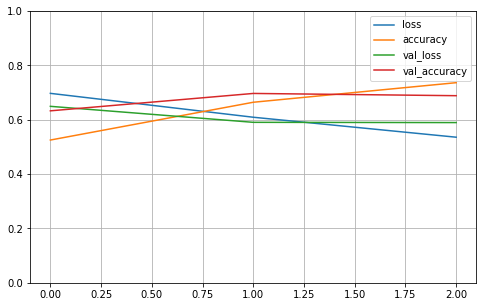

Train set ones/size 3646 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 396 / 844
Range of scores: 0.03456409 to 0.98717797
Score threshold 0.5
Prediction set ones/size 567 / 844


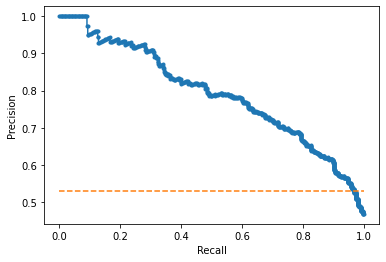

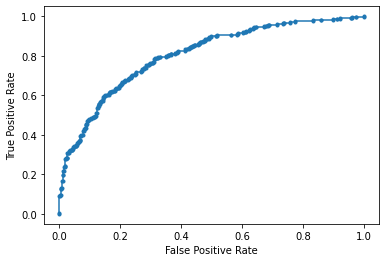

Accuracy: 68.84% Precision: 61.73% Recall: 88.38%
F1: 72.69% AUPRC: 79.34% AUROC: 80.56%
2023-02-06 19:16:03.637598
Fold 5
Model params (mean 0.23, wgt 0.39) (mean -1.92, wgt 0.61)
RCI threshold derived from training set: [-1.08185293]
FIT
2023-02-06 19:16:07.835194
Epoch 1/3
238/238 [==============================] - 4s 13ms/step - loss: 0.6964 - accuracy: 0.5250 - val_loss: 0.6617 - val_accuracy: 0.6102
Epoch 2/3
238/238 [==============================] - 3s 12ms/step - loss: 0.6162 - accuracy: 0.6524 - val_loss: 0.5594 - val_accuracy: 0.7109
Epoch 3/3
238/238 [==============================] - 3s 12ms/step - loss: 0.5270 - accuracy: 0.7405 - val_loss: 0.5188 - val_accuracy: 0.7393
PREDICT
2023-02-06 19:16:17.696942


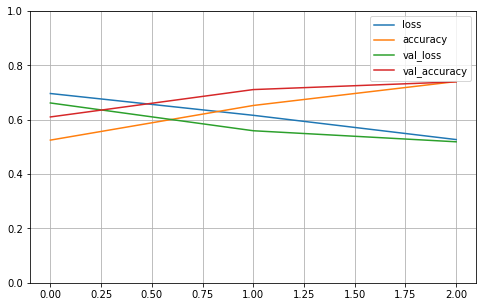

Train set ones/size 3631 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 418 / 844
Range of scores: 0.012819126 to 0.98598427
Score threshold 0.5
Prediction set ones/size 446 / 844


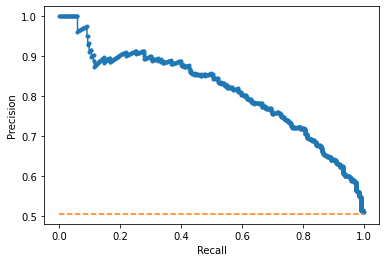

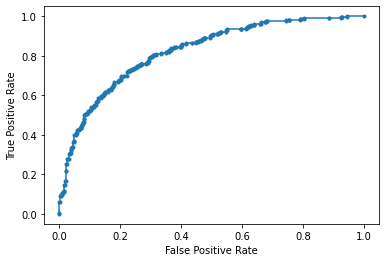

Accuracy: 73.93% Precision: 72.20% Recall: 77.03%
F1: 74.54% AUPRC: 81.45% AUROC: 82.33%
2023-02-06 19:16:18.332778
Fold 6
Model params (mean 0.21, wgt 0.39) (mean -1.89, wgt 0.61)
RCI threshold derived from training set: [-1.08091421]
FIT
2023-02-06 19:16:22.510069
Epoch 1/3
238/238 [==============================] - 4s 13ms/step - loss: 0.6866 - accuracy: 0.5489 - val_loss: 0.6447 - val_accuracy: 0.6469
Epoch 2/3
238/238 [==============================] - 3s 12ms/step - loss: 0.6140 - accuracy: 0.6564 - val_loss: 0.6140 - val_accuracy: 0.6730
Epoch 3/3
238/238 [==============================] - 3s 12ms/step - loss: 0.5431 - accuracy: 0.7251 - val_loss: 0.5573 - val_accuracy: 0.7073
PREDICT
2023-02-06 19:16:32.409923


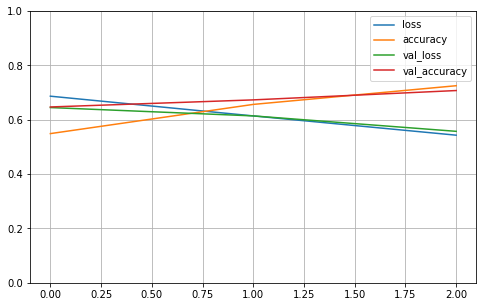

Train set ones/size 3622 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 420 / 844
Range of scores: 0.012270837 to 0.98370254
Score threshold 0.5
Prediction set ones/size 457 / 844


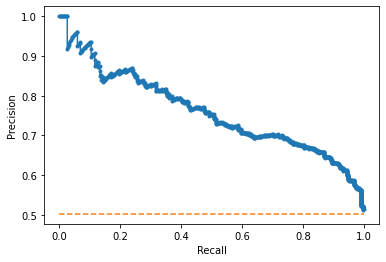

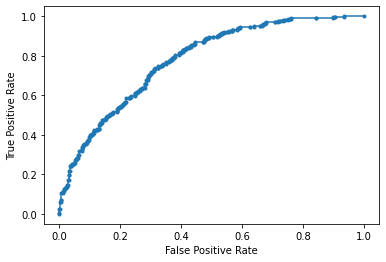

Accuracy: 70.73% Precision: 68.93% Recall: 75.00%
F1: 71.84% AUPRC: 76.08% AUROC: 78.01%
2023-02-06 19:16:33.083526
Fold 7
Model params (mean 0.18, wgt 0.39) (mean -1.90, wgt 0.61)
RCI threshold derived from training set: [-1.08268958]
FIT
2023-02-06 19:16:37.456421
Epoch 1/3
238/238 [==============================] - 4s 13ms/step - loss: 0.6861 - accuracy: 0.5505 - val_loss: 0.6366 - val_accuracy: 0.6303
Epoch 2/3
238/238 [==============================] - 3s 12ms/step - loss: 0.5862 - accuracy: 0.6865 - val_loss: 0.6237 - val_accuracy: 0.6552
Epoch 3/3
238/238 [==============================] - 3s 12ms/step - loss: 0.5087 - accuracy: 0.7564 - val_loss: 0.5467 - val_accuracy: 0.7287
PREDICT
2023-02-06 19:16:47.361148


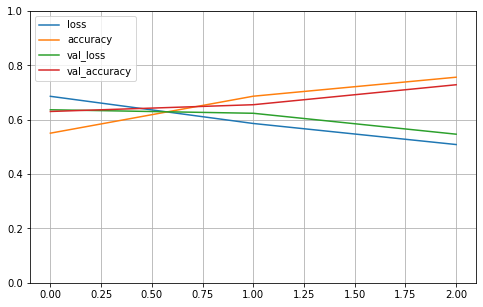

Train set ones/size 3656 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 393 / 844
Range of scores: 0.00492198 to 0.9753329
Score threshold 0.5
Prediction set ones/size 362 / 844


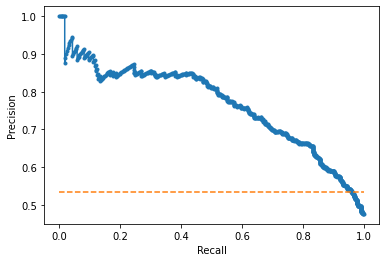

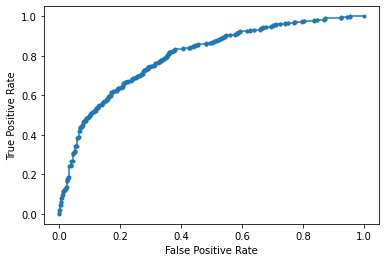

Accuracy: 72.87% Precision: 72.65% Recall: 66.92%
F1: 69.67% AUPRC: 76.73% AUROC: 79.89%
2023-02-06 19:16:48.060415
Fold 8
Model params (mean 0.16, wgt 0.39) (mean -1.89, wgt 0.61)
RCI threshold derived from training set: [-1.08827891]
FIT
2023-02-06 19:16:52.224538
Epoch 1/3
238/238 [==============================] - 4s 13ms/step - loss: 0.7011 - accuracy: 0.5329 - val_loss: 0.6597 - val_accuracy: 0.5889
Epoch 2/3
238/238 [==============================] - 3s 12ms/step - loss: 0.6345 - accuracy: 0.6346 - val_loss: 0.5996 - val_accuracy: 0.6706
Epoch 3/3
238/238 [==============================] - 3s 12ms/step - loss: 0.5377 - accuracy: 0.7357 - val_loss: 0.5155 - val_accuracy: 0.7429
PREDICT
2023-02-06 19:17:02.059914


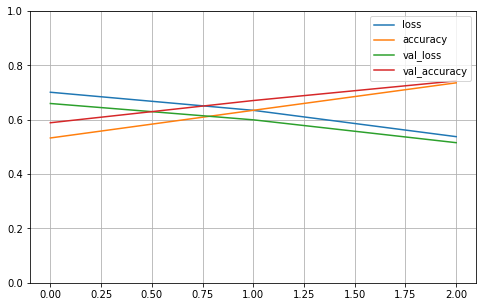

Train set ones/size 3649 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 409 / 844
Range of scores: 0.00614559 to 0.9835262
Score threshold 0.5
Prediction set ones/size 336 / 844


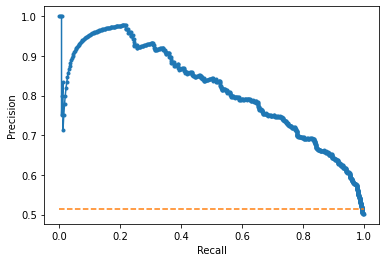

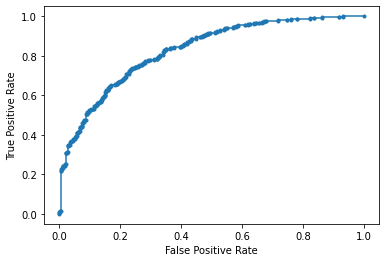

Accuracy: 74.29% Precision: 78.57% Recall: 64.55%
F1: 70.87% AUPRC: 81.46% AUROC: 82.87%
2023-02-06 19:17:02.680054
Fold 9
Model params (mean -1.89, wgt 0.61) (mean 0.19, wgt 0.39)
RCI threshold derived from training set: [-1.0822447]
FIT
2023-02-06 19:17:06.840509
Epoch 1/3
238/238 [==============================] - 4s 13ms/step - loss: 0.6948 - accuracy: 0.5250 - val_loss: 0.6617 - val_accuracy: 0.6078
Epoch 2/3
238/238 [==============================] - 3s 12ms/step - loss: 0.6118 - accuracy: 0.6637 - val_loss: 0.5732 - val_accuracy: 0.7038
Epoch 3/3
238/238 [==============================] - 3s 12ms/step - loss: 0.5142 - accuracy: 0.7510 - val_loss: 0.5447 - val_accuracy: 0.7239
PREDICT
2023-02-06 19:17:18.131437


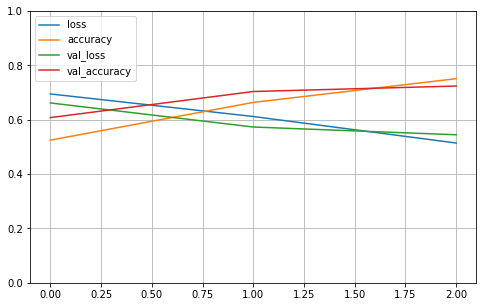

Train set ones/size 3641 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 408 / 844
Range of scores: 0.0029236237 to 0.9815724
Score threshold 0.5
Prediction set ones/size 273 / 844


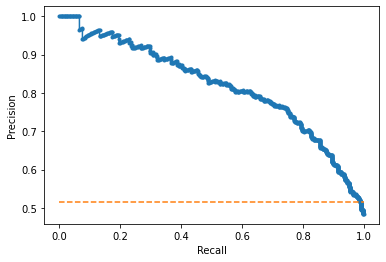

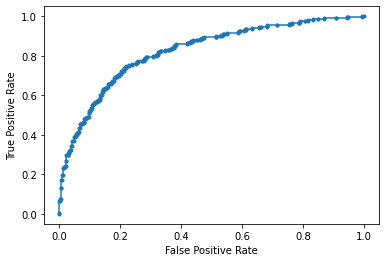

Accuracy: 72.39% Precision: 82.05% Recall: 54.90%
F1: 65.79% AUPRC: 81.89% AUROC: 82.40%
2023-02-06 19:17:18.819291
Fold 10
Model params (mean 0.18, wgt 0.39) (mean -1.89, wgt 0.61)
RCI threshold derived from training set: [-1.0828875]
FIT
2023-02-06 19:17:23.275536
Epoch 1/3
238/238 [==============================] - 4s 13ms/step - loss: 0.6854 - accuracy: 0.5515 - val_loss: 0.6026 - val_accuracy: 0.6856
Epoch 2/3
238/238 [==============================] - 3s 12ms/step - loss: 0.6113 - accuracy: 0.6669 - val_loss: 0.5589 - val_accuracy: 0.7177
Epoch 3/3
238/238 [==============================] - 3s 12ms/step - loss: 0.5196 - accuracy: 0.7470 - val_loss: 0.5240 - val_accuracy: 0.7343
PREDICT
2023-02-06 19:17:34.566699


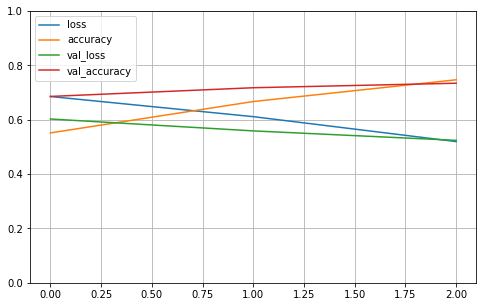

Train set ones/size 3650 / 7596
Compute valiation accuracy
Valid sizes (843, 4997) (843,)
Valid set ones/size 408 / 843
Range of scores: 0.009105669 to 0.97669137
Score threshold 0.5
Prediction set ones/size 310 / 843


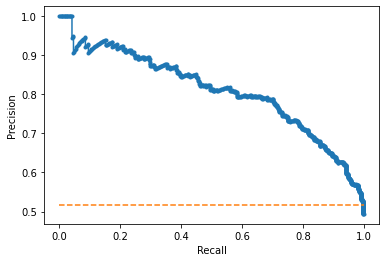

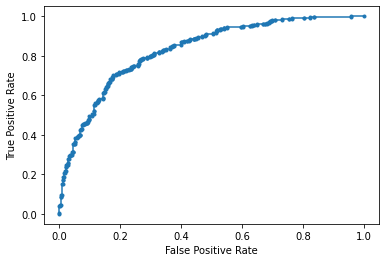

Accuracy: 73.43% Precision: 79.68% Recall: 60.54%
F1: 68.80% AUPRC: 81.08% AUROC: 82.98%
2023-02-06 19:17:35.207642

Completed cross validation 10 folds 3 epochs
 accuracy mean 72.99% +/- 2.10
 precision mean 74.21% +/- 5.88
 recall mean 69.31% +/- 10.56
 F1 mean 70.87% +/- 3.51
 AUPRC mean 80.15% +/- 2.27
 AUROC mean 81.79% +/- 1.76
Finished cell Line 3 HepG2

2023-02-06 19:17:36.597555
Start cell Line 4 HT1080
Number of RCI values loaded 936
Num RCI: 936
Load sequence...
Cross validation...
2023-02-06 19:17:46.277193
splitting
Fold 1
Model params (mean 0.92, wgt 0.38) (mean -1.01, wgt 0.62)
RCI threshold derived from training set: [-0.28372993]
FIT
2023-02-06 19:17:48.666723
Epoch 1/3
199/199 [==============================] - 3s 13ms/step - loss: 0.6733 - accuracy: 0.5723 - val_loss: 0.6468 - val_accuracy: 0.6096
Epoch 2/3
199/199 [==============================] - 2s 12ms/step - loss: 0.5913 - accuracy: 0.6793 - val_loss: 0.5759 - val_accuracy: 0.6662
Epoch 3/3
199/199 [===========

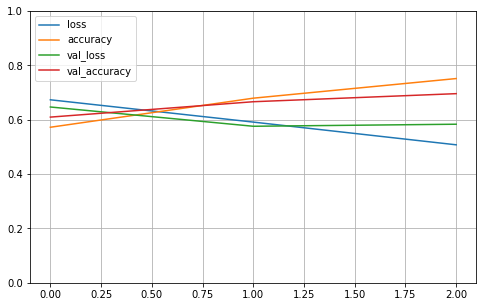

Train set ones/size 3056 / 6357
Compute valiation accuracy
Valid sizes (707, 4997) (707,)
Valid set ones/size 341 / 707
Range of scores: 0.019487262 to 0.9956398
Score threshold 0.5
Prediction set ones/size 496 / 707


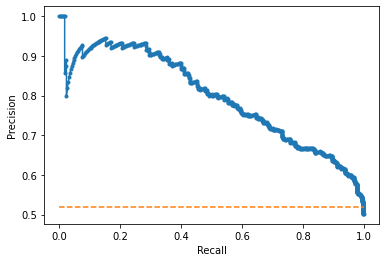

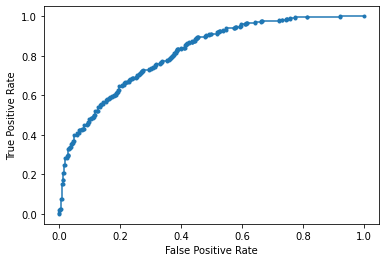

Accuracy: 69.59% Precision: 62.70% Recall: 91.20%
F1: 74.31% AUPRC: 79.59% AUROC: 81.45%
2023-02-06 19:18:00.582711
Fold 2
Model params (mean -1.01, wgt 0.62) (mean 0.94, wgt 0.38)
RCI threshold derived from training set: [-0.2753148]
FIT
2023-02-06 19:18:04.279274
Epoch 1/3
199/199 [==============================] - 3s 14ms/step - loss: 0.6852 - accuracy: 0.5518 - val_loss: 0.6327 - val_accuracy: 0.6535
Epoch 2/3
199/199 [==============================] - 2s 12ms/step - loss: 0.6035 - accuracy: 0.6708 - val_loss: 0.6091 - val_accuracy: 0.6690
Epoch 3/3
199/199 [==============================] - 2s 12ms/step - loss: 0.5242 - accuracy: 0.7348 - val_loss: 0.5682 - val_accuracy: 0.6803
PREDICT
2023-02-06 19:18:12.950642


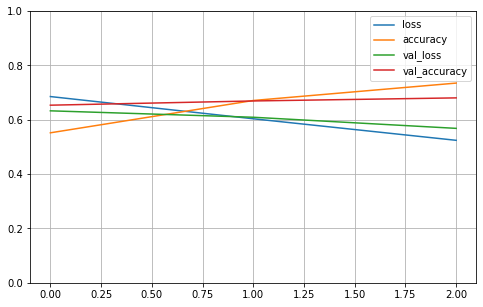

Train set ones/size 3063 / 6357
Compute valiation accuracy
Valid sizes (707, 4997) (707,)
Valid set ones/size 327 / 707
Range of scores: 0.01672515 to 0.9914048
Score threshold 0.5
Prediction set ones/size 395 / 707


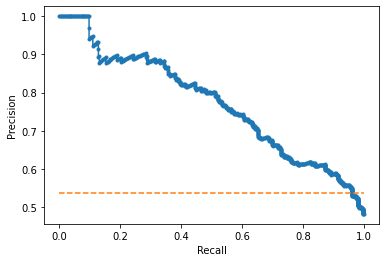

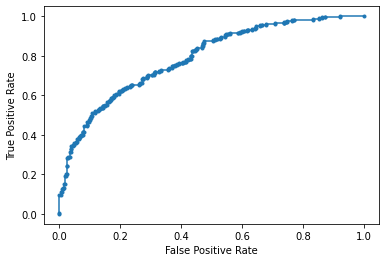

Accuracy: 68.03% Precision: 62.78% Recall: 75.84%
F1: 68.70% AUPRC: 77.19% AUROC: 78.97%
2023-02-06 19:18:13.563914
Fold 3
Model params (mean 0.98, wgt 0.38) (mean -1.04, wgt 0.62)
RCI threshold derived from training set: [-0.27897305]
FIT
2023-02-06 19:18:17.097923
Epoch 1/3
199/199 [==============================] - 3s 14ms/step - loss: 0.6952 - accuracy: 0.5339 - val_loss: 0.6692 - val_accuracy: 0.5842
Epoch 2/3
199/199 [==============================] - 2s 12ms/step - loss: 0.6102 - accuracy: 0.6626 - val_loss: 0.5932 - val_accuracy: 0.6648
Epoch 3/3
199/199 [==============================] - 2s 12ms/step - loss: 0.5086 - accuracy: 0.7526 - val_loss: 0.5267 - val_accuracy: 0.7482
PREDICT
2023-02-06 19:18:25.704850


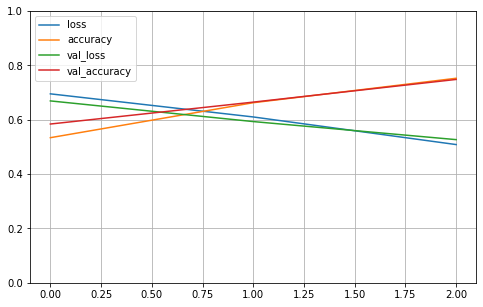

Train set ones/size 3051 / 6357
Compute valiation accuracy
Valid sizes (707, 4997) (707,)
Valid set ones/size 340 / 707
Range of scores: 0.0024155087 to 0.99412656
Score threshold 0.5
Prediction set ones/size 452 / 707


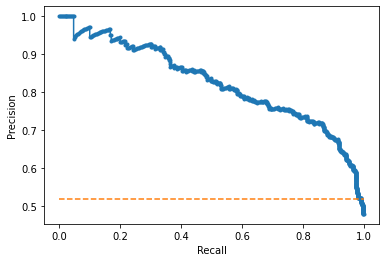

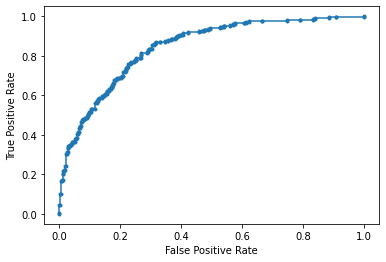

Accuracy: 74.82% Precision: 67.92% Recall: 90.29%
F1: 77.53% AUPRC: 82.58% AUROC: 84.29%
2023-02-06 19:18:26.320217
Fold 4
Model params (mean -1.03, wgt 0.63) (mean 0.96, wgt 0.37)
RCI threshold derived from training set: [-0.28884404]
FIT
2023-02-06 19:18:30.069976
Epoch 1/3
199/199 [==============================] - 3s 13ms/step - loss: 0.6870 - accuracy: 0.5477 - val_loss: 0.6533 - val_accuracy: 0.5997
Epoch 2/3
199/199 [==============================] - 2s 12ms/step - loss: 0.6083 - accuracy: 0.6676 - val_loss: 0.5693 - val_accuracy: 0.6888
Epoch 3/3
199/199 [==============================] - 2s 12ms/step - loss: 0.4906 - accuracy: 0.7568 - val_loss: 0.5555 - val_accuracy: 0.7115
PREDICT
2023-02-06 19:18:41.302075


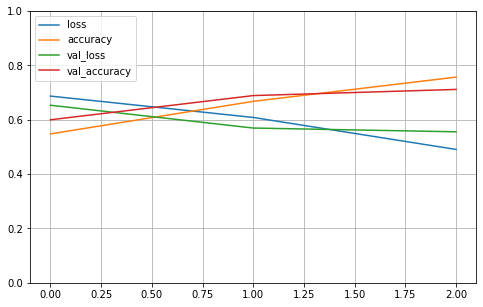

Train set ones/size 3042 / 6357
Compute valiation accuracy
Valid sizes (707, 4997) (707,)
Valid set ones/size 358 / 707
Range of scores: 0.0018784076 to 0.99162465
Score threshold 0.5
Prediction set ones/size 308 / 707


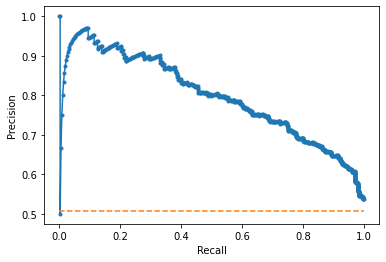

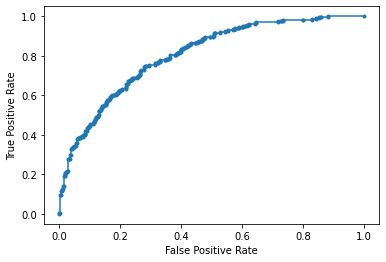

Accuracy: 71.15% Precision: 75.00% Recall: 64.53%
F1: 69.37% AUPRC: 79.76% AUROC: 80.58%
2023-02-06 19:18:41.949939
Fold 5
Model params (mean 0.96, wgt 0.37) (mean -1.02, wgt 0.63)
RCI threshold derived from training set: [-0.28329248]
FIT
2023-02-06 19:18:45.644859
Epoch 1/3
199/199 [==============================] - 3s 14ms/step - loss: 0.6950 - accuracy: 0.5349 - val_loss: 0.6429 - val_accuracy: 0.6360
Epoch 2/3
199/199 [==============================] - 2s 12ms/step - loss: 0.6137 - accuracy: 0.6560 - val_loss: 0.6333 - val_accuracy: 0.6303
Epoch 3/3
199/199 [==============================] - 2s 12ms/step - loss: 0.5113 - accuracy: 0.7472 - val_loss: 0.5637 - val_accuracy: 0.7195
PREDICT
2023-02-06 19:18:54.278139


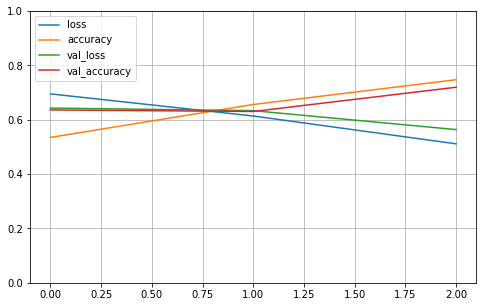

Train set ones/size 3058 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 339 / 706
Range of scores: 0.0030095652 to 0.9774122
Score threshold 0.5
Prediction set ones/size 265 / 706


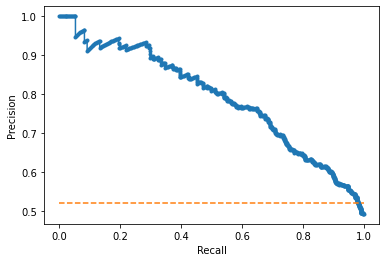

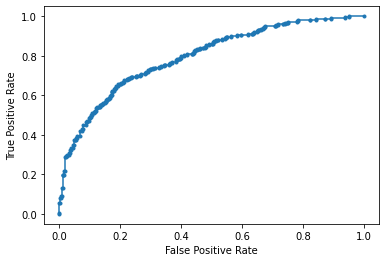

Accuracy: 71.95% Precision: 76.60% Recall: 59.88%
F1: 67.22% AUPRC: 79.18% AUROC: 79.51%
2023-02-06 19:18:54.950337
Fold 6
Model params (mean 0.97, wgt 0.37) (mean -1.02, wgt 0.63)
RCI threshold derived from training set: [-0.28163197]
FIT
2023-02-06 19:18:58.786666
Epoch 1/3
199/199 [==============================] - 3s 13ms/step - loss: 0.6925 - accuracy: 0.5445 - val_loss: 0.6638 - val_accuracy: 0.6062
Epoch 2/3
199/199 [==============================] - 2s 12ms/step - loss: 0.6042 - accuracy: 0.6760 - val_loss: 0.5532 - val_accuracy: 0.7011
Epoch 3/3
199/199 [==============================] - 2s 13ms/step - loss: 0.4903 - accuracy: 0.7628 - val_loss: 0.5652 - val_accuracy: 0.7181
PREDICT
2023-02-06 19:19:07.405034


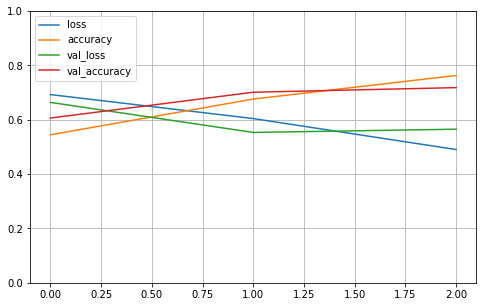

Train set ones/size 3057 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 340 / 706
Range of scores: 0.0010326146 to 0.99081403
Score threshold 0.5
Prediction set ones/size 247 / 706


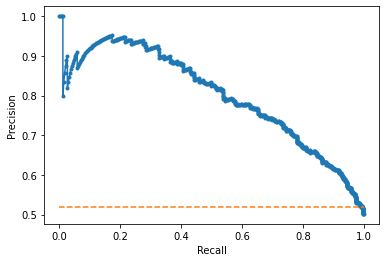

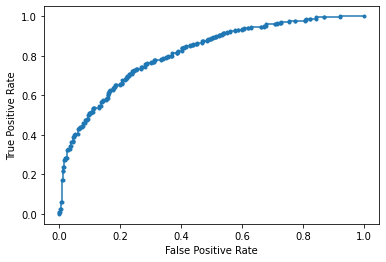

Accuracy: 71.81% Precision: 78.54% Recall: 57.06%
F1: 66.10% AUPRC: 80.01% AUROC: 81.39%
2023-02-06 19:19:08.071320
Fold 7
Model params (mean 0.95, wgt 0.37) (mean -1.02, wgt 0.63)
RCI threshold derived from training set: [-0.28862815]
FIT
2023-02-06 19:19:11.823850
Epoch 1/3
199/199 [==============================] - 3s 14ms/step - loss: 0.6902 - accuracy: 0.5431 - val_loss: 0.6237 - val_accuracy: 0.6686
Epoch 2/3
199/199 [==============================] - 2s 12ms/step - loss: 0.5778 - accuracy: 0.6908 - val_loss: 0.5538 - val_accuracy: 0.7054
Epoch 3/3
199/199 [==============================] - 2s 12ms/step - loss: 0.4916 - accuracy: 0.7622 - val_loss: 0.5051 - val_accuracy: 0.7748
PREDICT
2023-02-06 19:19:20.433955


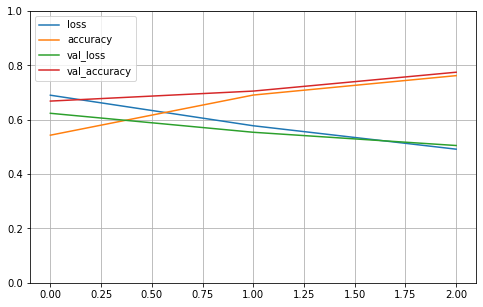

Train set ones/size 3046 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 354 / 706
Range of scores: 0.0040446166 to 0.9969709
Score threshold 0.5
Prediction set ones/size 409 / 706


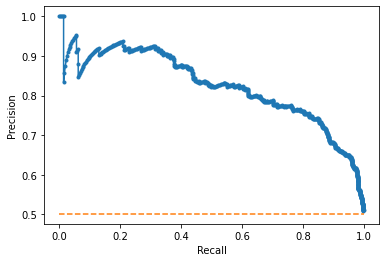

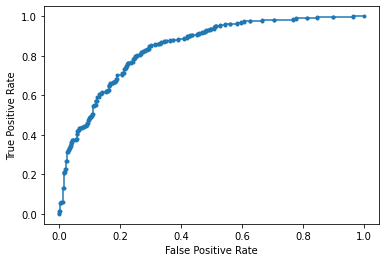

Accuracy: 77.48% Precision: 73.84% Recall: 85.31%
F1: 79.16% AUPRC: 82.48% AUROC: 84.30%
2023-02-06 19:19:21.121014
Fold 8
Model params (mean -1.03, wgt 0.62) (mean 0.96, wgt 0.38)
RCI threshold derived from training set: [-0.28006549]
FIT
2023-02-06 19:19:24.767699
Epoch 1/3
199/199 [==============================] - 3s 13ms/step - loss: 0.6893 - accuracy: 0.5505 - val_loss: 0.6240 - val_accuracy: 0.6799
Epoch 2/3
199/199 [==============================] - 2s 12ms/step - loss: 0.5846 - accuracy: 0.6906 - val_loss: 0.4983 - val_accuracy: 0.7564
Epoch 3/3
199/199 [==============================] - 2s 12ms/step - loss: 0.4721 - accuracy: 0.7732 - val_loss: 0.4318 - val_accuracy: 0.7918
PREDICT
2023-02-06 19:19:35.968332


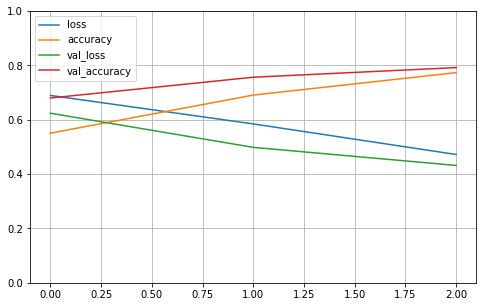

Train set ones/size 3072 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 320 / 706
Range of scores: 0.0051059066 to 0.99697924
Score threshold 0.5
Prediction set ones/size 327 / 706


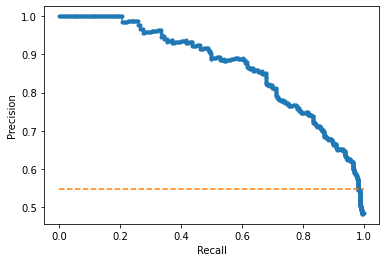

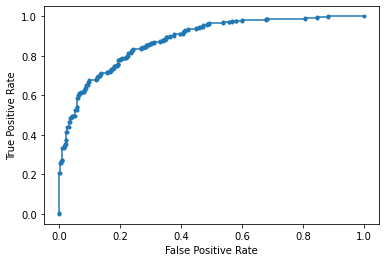

Accuracy: 79.18% Precision: 76.45% Recall: 78.12%
F1: 77.28% AUPRC: 86.83% AUROC: 88.04%
2023-02-06 19:19:36.635954
Fold 9
Model params (mean -1.03, wgt 0.62) (mean 0.94, wgt 0.38)
RCI threshold derived from training set: [-0.28685858]
FIT
2023-02-06 19:19:40.509866
Epoch 1/3
199/199 [==============================] - 3s 14ms/step - loss: 0.6934 - accuracy: 0.5401 - val_loss: 0.6468 - val_accuracy: 0.5992
Epoch 2/3
199/199 [==============================] - 2s 12ms/step - loss: 0.6144 - accuracy: 0.6574 - val_loss: 0.5405 - val_accuracy: 0.7068
Epoch 3/3
199/199 [==============================] - 2s 12ms/step - loss: 0.5166 - accuracy: 0.7439 - val_loss: 0.4758 - val_accuracy: 0.7762
PREDICT
2023-02-06 19:19:51.718352


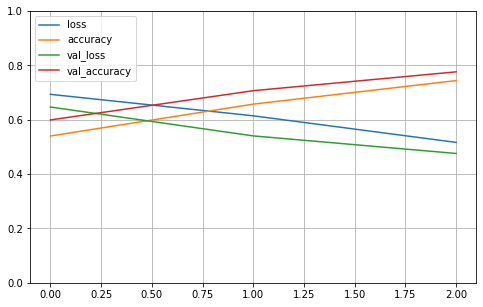

Train set ones/size 3067 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 333 / 706
Range of scores: 0.0067191664 to 0.982988
Score threshold 0.5
Prediction set ones/size 329 / 706


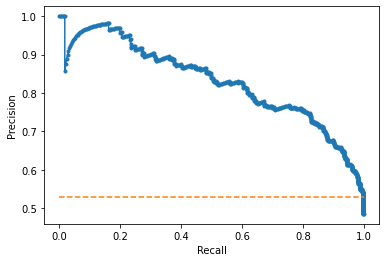

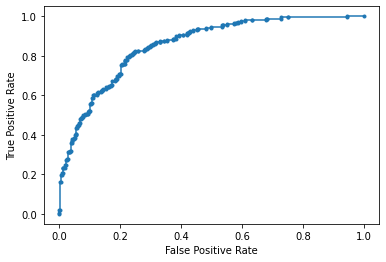

Accuracy: 77.62% Precision: 76.60% Recall: 75.68%
F1: 76.13% AUPRC: 83.01% AUROC: 85.48%
2023-02-06 19:19:52.341912
Fold 10
Model params (mean 0.96, wgt 0.37) (mean -1.03, wgt 0.63)
RCI threshold derived from training set: [-0.28572199]
FIT
2023-02-06 19:19:55.920558
Epoch 1/3
199/199 [==============================] - 3s 13ms/step - loss: 0.6938 - accuracy: 0.5398 - val_loss: 0.6683 - val_accuracy: 0.5807
Epoch 2/3
199/199 [==============================] - 2s 12ms/step - loss: 0.6122 - accuracy: 0.6571 - val_loss: 0.5852 - val_accuracy: 0.6799
Epoch 3/3
199/199 [==============================] - 2s 12ms/step - loss: 0.5064 - accuracy: 0.7537 - val_loss: 0.4951 - val_accuracy: 0.7734
PREDICT
2023-02-06 19:20:07.132816


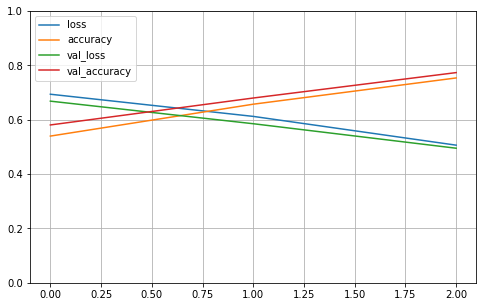

Train set ones/size 3053 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 344 / 706
Range of scores: 0.0038300997 to 0.9929467
Score threshold 0.5
Prediction set ones/size 334 / 706


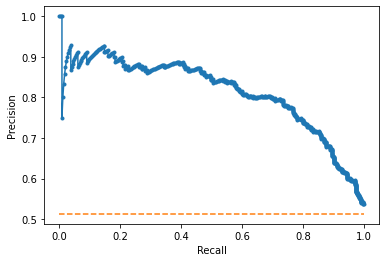

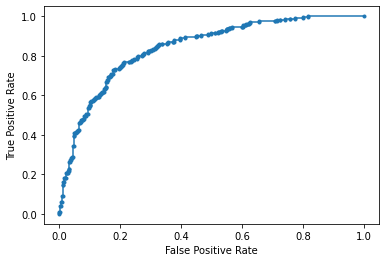

Accuracy: 77.34% Precision: 77.54% Recall: 75.29%
F1: 76.40% AUPRC: 81.41% AUROC: 84.17%
2023-02-06 19:20:07.806640

Completed cross validation 10 folds 3 epochs
 accuracy mean 73.90% +/- 3.89
 precision mean 72.80% +/- 6.05
 recall mean 75.32% +/- 11.89
 F1 mean 73.22% +/- 4.85
 AUPRC mean 81.20% +/- 2.68
 AUROC mean 82.82% +/- 2.89
Finished cell Line 4 HT1080

2023-02-06 19:20:09.152634
Start cell Line 5 HUVEC
Number of RCI values loaded 1488
Num RCI: 1488
Load sequence...
Cross validation...
2023-02-06 19:20:22.107480
splitting
Fold 1
Model params (mean -0.00, wgt 0.52) (mean -2.01, wgt 0.48)
RCI threshold derived from training set: [-0.95986926]
FIT
2023-02-06 19:20:25.432188
Epoch 1/3
270/270 [==============================] - 4s 13ms/step - loss: 0.6920 - accuracy: 0.5297 - val_loss: 0.6465 - val_accuracy: 0.6413
Epoch 2/3
270/270 [==============================] - 3s 12ms/step - loss: 0.6058 - accuracy: 0.6687 - val_loss: 0.5438 - val_accuracy: 0.7278
Epoch 3/3
270/270 [========

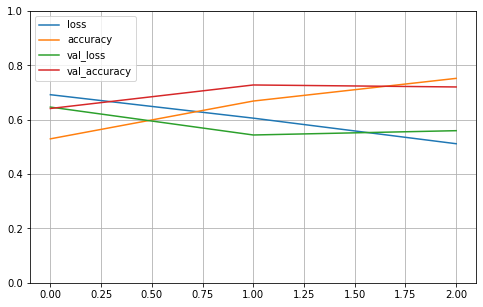

Train set ones/size 4431 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 505 / 959
Range of scores: 0.0018408536 to 0.9845942
Score threshold 0.5
Prediction set ones/size 347 / 959


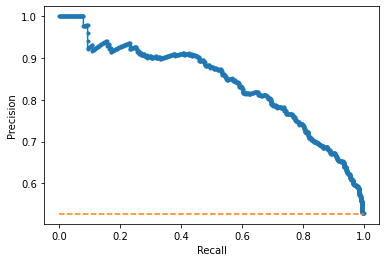

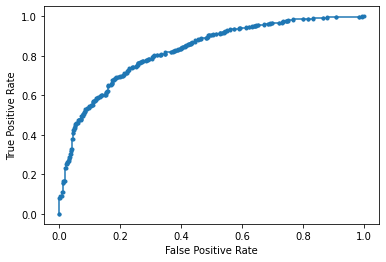

Accuracy: 72.05% Precision: 84.15% Recall: 57.82%
F1: 68.54% AUPRC: 83.93% AUROC: 82.66%
2023-02-06 19:20:37.373994
Fold 2
Model params (mean -0.01, wgt 0.52) (mean -2.02, wgt 0.48)
RCI threshold derived from training set: [-0.96362344]
FIT
2023-02-06 19:20:41.680703
Epoch 1/3
270/270 [==============================] - 4s 13ms/step - loss: 0.6954 - accuracy: 0.5264 - val_loss: 0.6777 - val_accuracy: 0.5933
Epoch 2/3
270/270 [==============================] - 3s 12ms/step - loss: 0.6298 - accuracy: 0.6512 - val_loss: 0.6053 - val_accuracy: 0.6726
Epoch 3/3
270/270 [==============================] - 3s 12ms/step - loss: 0.5396 - accuracy: 0.7287 - val_loss: 0.5491 - val_accuracy: 0.7195
PREDICT
2023-02-06 19:20:53.027126


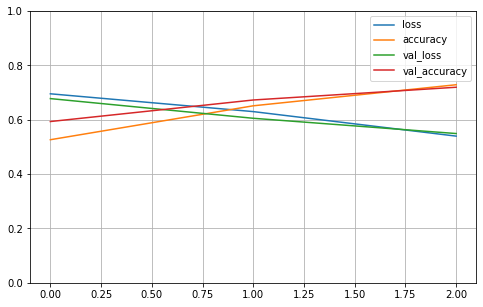

Train set ones/size 4424 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 512 / 959
Range of scores: 0.017414518 to 0.9852514
Score threshold 0.5
Prediction set ones/size 531 / 959


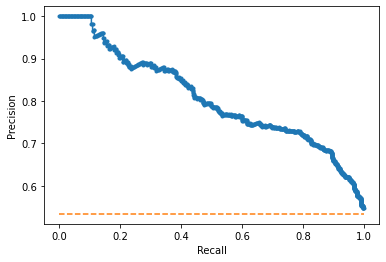

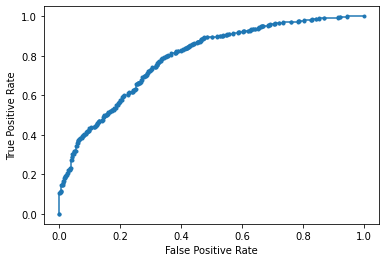

Accuracy: 71.95% Precision: 72.88% Recall: 75.59%
F1: 74.21% AUPRC: 80.75% AUROC: 78.93%
2023-02-06 19:20:53.680376
Fold 3
Model params (mean -0.02, wgt 0.53) (mean -2.01, wgt 0.47)
RCI threshold derived from training set: [-0.95937387]
FIT
2023-02-06 19:20:58.187896
Epoch 1/3
270/270 [==============================] - 4s 13ms/step - loss: 0.6907 - accuracy: 0.5413 - val_loss: 0.6492 - val_accuracy: 0.6163
Epoch 2/3
270/270 [==============================] - 3s 12ms/step - loss: 0.6038 - accuracy: 0.6749 - val_loss: 0.6012 - val_accuracy: 0.6569
Epoch 3/3
270/270 [==============================] - 3s 12ms/step - loss: 0.5025 - accuracy: 0.7521 - val_loss: 0.5814 - val_accuracy: 0.7101
PREDICT
2023-02-06 19:21:09.540215


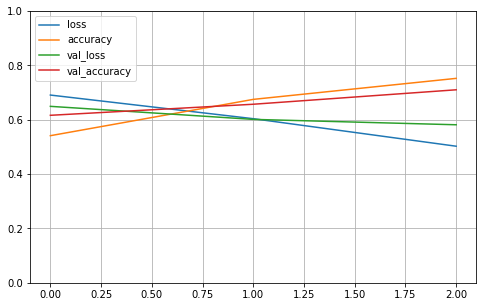

Train set ones/size 4440 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 496 / 959
Range of scores: 0.004540817 to 0.97177774
Score threshold 0.5
Prediction set ones/size 390 / 959


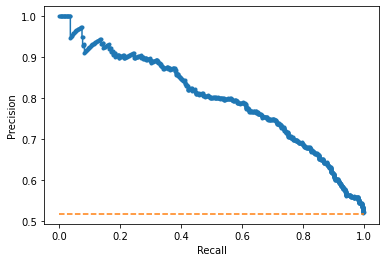

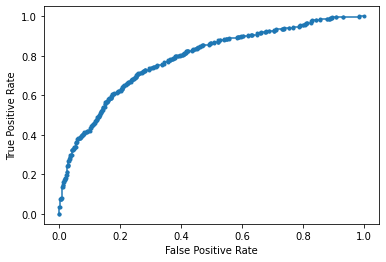

Accuracy: 71.01% Precision: 77.95% Recall: 61.29%
F1: 68.62% AUPRC: 79.88% AUROC: 78.53%
2023-02-06 19:21:10.237773
Fold 4
Model params (mean -0.02, wgt 0.53) (mean -2.01, wgt 0.47)
RCI threshold derived from training set: [-0.94915143]
FIT
2023-02-06 19:21:14.563245
Epoch 1/3
270/270 [==============================] - 4s 13ms/step - loss: 0.6875 - accuracy: 0.5422 - val_loss: 0.6408 - val_accuracy: 0.6601
Epoch 2/3
270/270 [==============================] - 3s 12ms/step - loss: 0.6086 - accuracy: 0.6718 - val_loss: 0.5771 - val_accuracy: 0.6934
Epoch 3/3
270/270 [==============================] - 3s 12ms/step - loss: 0.5396 - accuracy: 0.7316 - val_loss: 0.5397 - val_accuracy: 0.7445
PREDICT
2023-02-06 19:21:25.911130


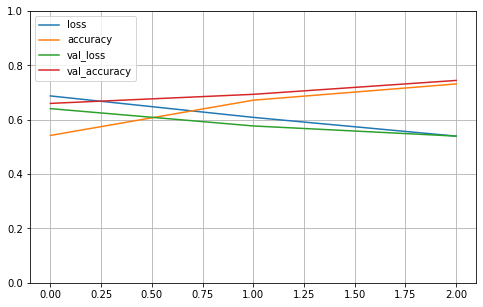

Train set ones/size 4419 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 457 / 959
Range of scores: 0.020159485 to 0.9351029
Score threshold 0.5
Prediction set ones/size 342 / 959


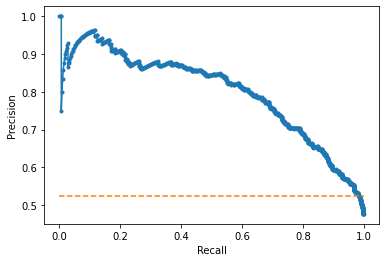

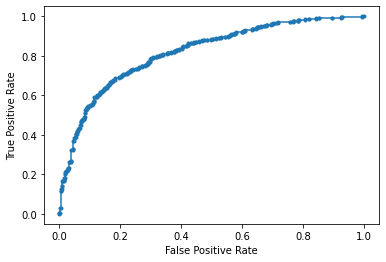

Accuracy: 74.45% Precision: 80.99% Recall: 60.61%
F1: 69.34% AUPRC: 80.01% AUROC: 81.85%
2023-02-06 19:21:26.562234
Fold 5
Model params (mean -0.01, wgt 0.52) (mean -2.02, wgt 0.48)
RCI threshold derived from training set: [-0.96778604]
FIT
2023-02-06 19:21:30.973731
Epoch 1/3
270/270 [==============================] - 4s 13ms/step - loss: 0.6882 - accuracy: 0.5438 - val_loss: 0.6380 - val_accuracy: 0.6340
Epoch 2/3
270/270 [==============================] - 3s 12ms/step - loss: 0.6223 - accuracy: 0.6523 - val_loss: 0.5732 - val_accuracy: 0.7007
Epoch 3/3
270/270 [==============================] - 3s 12ms/step - loss: 0.5462 - accuracy: 0.7262 - val_loss: 0.5754 - val_accuracy: 0.6955
PREDICT
2023-02-06 19:21:42.327905


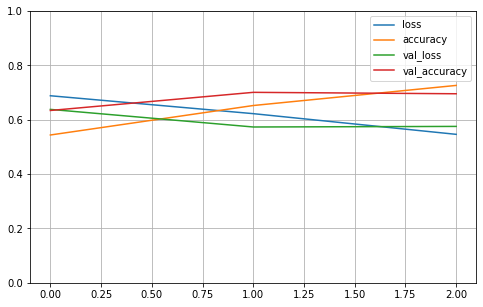

Train set ones/size 4423 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 528 / 959
Range of scores: 0.0043075685 to 0.9685176
Score threshold 0.5
Prediction set ones/size 314 / 959


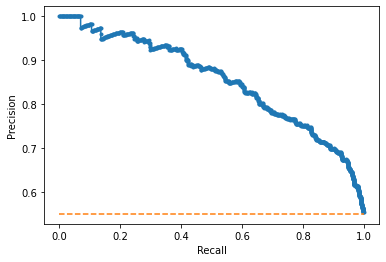

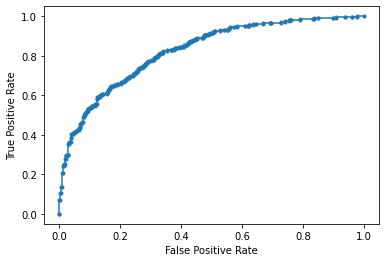

Accuracy: 69.55% Precision: 87.58% Recall: 52.08%
F1: 65.32% AUPRC: 85.37% AUROC: 82.56%
2023-02-06 19:21:42.992260
Fold 6
Model params (mean -2.03, wgt 0.47) (mean -0.02, wgt 0.53)
RCI threshold derived from training set: [-0.9634301]
FIT
2023-02-06 19:21:47.215812
Epoch 1/3
270/270 [==============================] - 4s 13ms/step - loss: 0.6919 - accuracy: 0.5463 - val_loss: 0.6510 - val_accuracy: 0.6455
Epoch 2/3
270/270 [==============================] - 3s 12ms/step - loss: 0.6138 - accuracy: 0.6586 - val_loss: 0.5704 - val_accuracy: 0.6945
Epoch 3/3
270/270 [==============================] - 3s 12ms/step - loss: 0.5172 - accuracy: 0.7428 - val_loss: 0.5121 - val_accuracy: 0.7289
PREDICT
2023-02-06 19:21:58.572070


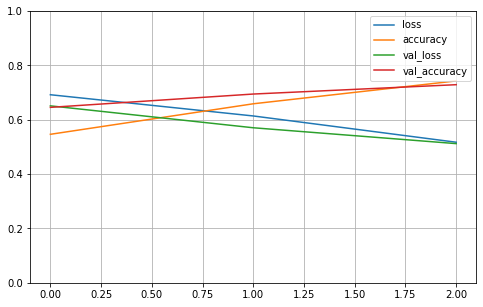

Train set ones/size 4450 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 486 / 959
Range of scores: 0.0057798186 to 0.9815865
Score threshold 0.5
Prediction set ones/size 394 / 959


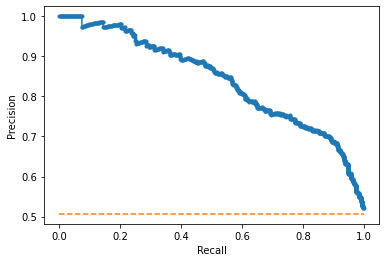

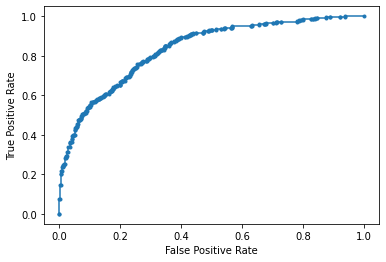

Accuracy: 72.89% Precision: 78.68% Recall: 63.79%
F1: 70.45% AUPRC: 84.15% AUROC: 83.43%
2023-02-06 19:21:59.270330
Fold 7
Model params (mean 0.01, wgt 0.53) (mean -2.00, wgt 0.47)
RCI threshold derived from training set: [-0.94331613]
FIT
2023-02-06 19:22:03.934418
Epoch 1/3
270/270 [==============================] - 4s 13ms/step - loss: 0.6908 - accuracy: 0.5385 - val_loss: 0.6479 - val_accuracy: 0.6090
Epoch 2/3
270/270 [==============================] - 3s 12ms/step - loss: 0.6116 - accuracy: 0.6636 - val_loss: 0.5769 - val_accuracy: 0.6872
Epoch 3/3
270/270 [==============================] - 3s 12ms/step - loss: 0.5203 - accuracy: 0.7480 - val_loss: 0.5557 - val_accuracy: 0.7018
PREDICT
2023-02-06 19:22:15.223824


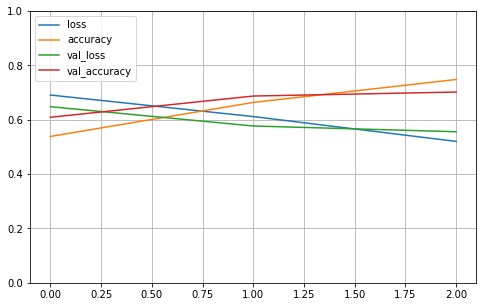

Train set ones/size 4382 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 460 / 959
Range of scores: 0.0023551455 to 0.9922855
Score threshold 0.5
Prediction set ones/size 622 / 959


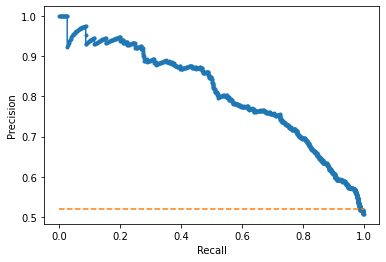

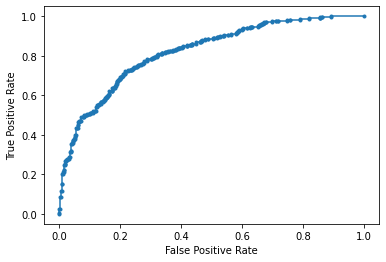

Accuracy: 70.18% Precision: 63.99% Recall: 86.52%
F1: 73.57% AUPRC: 80.92% AUROC: 82.03%
2023-02-06 19:22:15.897481
Fold 8
Model params (mean 0.00, wgt 0.53) (mean -2.01, wgt 0.47)
RCI threshold derived from training set: [-0.95152768]
FIT
2023-02-06 19:22:20.504542
Epoch 1/3
270/270 [==============================] - 4s 13ms/step - loss: 0.6885 - accuracy: 0.5561 - val_loss: 0.6735 - val_accuracy: 0.5662
Epoch 2/3
270/270 [==============================] - 3s 12ms/step - loss: 0.6023 - accuracy: 0.6760 - val_loss: 0.5773 - val_accuracy: 0.7028
Epoch 3/3
270/270 [==============================] - 3s 12ms/step - loss: 0.5079 - accuracy: 0.7458 - val_loss: 0.5301 - val_accuracy: 0.7299
PREDICT
2023-02-06 19:22:31.667868


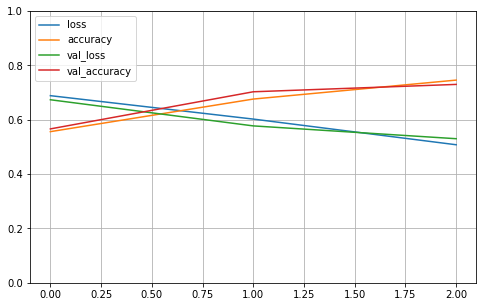

Train set ones/size 4391 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 486 / 959
Range of scores: 0.0016377681 to 0.98268974
Score threshold 0.5
Prediction set ones/size 423 / 959


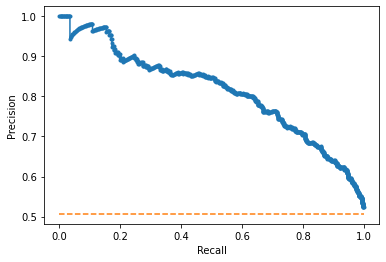

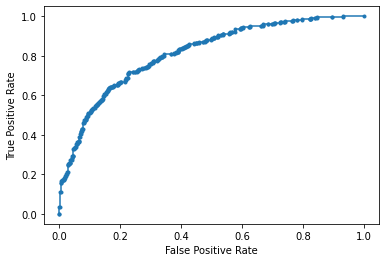

Accuracy: 72.99% Precision: 76.83% Recall: 66.87%
F1: 71.51% AUPRC: 81.42% AUROC: 81.28%
2023-02-06 19:22:32.351551
Fold 9
Model params (mean 0.00, wgt 0.53) (mean -2.03, wgt 0.47)
RCI threshold derived from training set: [-0.9602096]
FIT
2023-02-06 19:22:36.729811
Epoch 1/3
270/270 [==============================] - 4s 13ms/step - loss: 0.6921 - accuracy: 0.5364 - val_loss: 0.6540 - val_accuracy: 0.6204
Epoch 2/3
270/270 [==============================] - 3s 12ms/step - loss: 0.6074 - accuracy: 0.6714 - val_loss: 0.5509 - val_accuracy: 0.7268
Epoch 3/3
270/270 [==============================] - 3s 12ms/step - loss: 0.5523 - accuracy: 0.7200 - val_loss: 0.5266 - val_accuracy: 0.7477
PREDICT
2023-02-06 19:22:47.981576


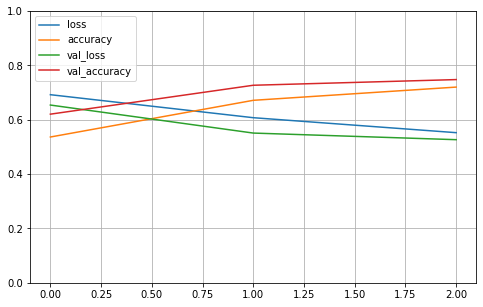

Train set ones/size 4434 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 502 / 959
Range of scores: 0.0038487527 to 0.9675894
Score threshold 0.5
Prediction set ones/size 454 / 959


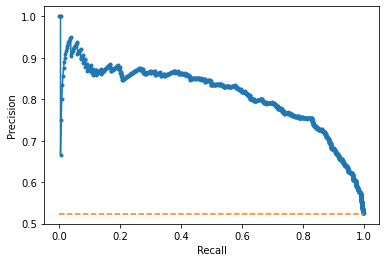

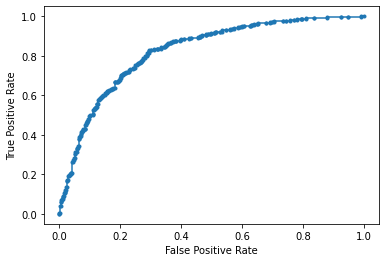

Accuracy: 74.77% Precision: 78.63% Recall: 71.12%
F1: 74.69% AUPRC: 81.02% AUROC: 82.36%
2023-02-06 19:22:48.674801
Fold 10
Model params (mean -0.00, wgt 0.53) (mean -2.03, wgt 0.47)
RCI threshold derived from training set: [-0.9577084]
FIT
2023-02-06 19:22:52.990139
Epoch 1/3
270/270 [==============================] - 4s 13ms/step - loss: 0.6939 - accuracy: 0.5417 - val_loss: 0.6569 - val_accuracy: 0.6357
Epoch 2/3
270/270 [==============================] - 3s 12ms/step - loss: 0.6079 - accuracy: 0.6678 - val_loss: 0.5473 - val_accuracy: 0.7234
Epoch 3/3
270/270 [==============================] - 3s 12ms/step - loss: 0.5069 - accuracy: 0.7524 - val_loss: 0.5143 - val_accuracy: 0.7370
PREDICT
2023-02-06 19:23:04.420520


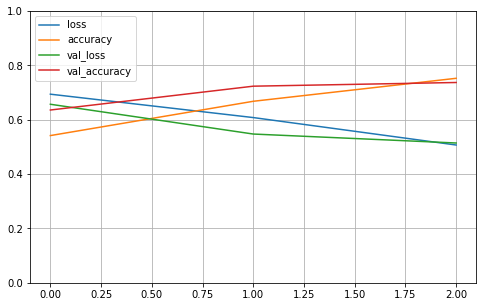

Train set ones/size 4456 / 8631
Compute valiation accuracy
Valid sizes (958, 4997) (958,)
Valid set ones/size 477 / 958
Range of scores: 0.00920205 to 0.9858364
Score threshold 0.5
Prediction set ones/size 423 / 958


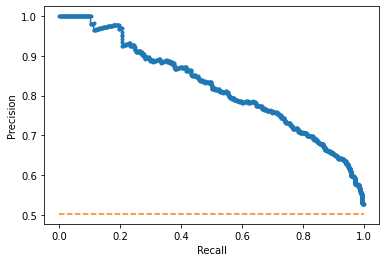

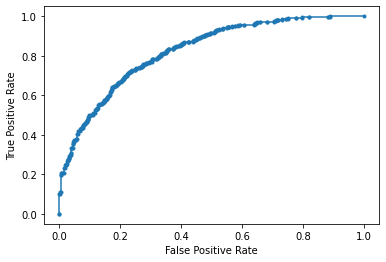

Accuracy: 73.70% Precision: 76.60% Recall: 67.92%
F1: 72.00% AUPRC: 82.27% AUROC: 82.47%
2023-02-06 19:23:05.136888

Completed cross validation 10 folds 3 epochs
 accuracy mean 72.35% +/- 1.74
 precision mean 77.83% +/- 6.37
 recall mean 66.36% +/- 9.77
 F1 mean 70.82% +/- 2.95
 AUPRC mean 81.97% +/- 1.89
 AUROC mean 81.61% +/- 1.62
Finished cell Line 5 HUVEC

2023-02-06 19:23:06.558577
Start cell Line 6 MCF.7
Number of RCI values loaded 2156
Num RCI: 2156
Load sequence...
Cross validation...
2023-02-06 19:23:22.035529
splitting
Fold 1
Model params (mean -0.07, wgt 0.48) (mean -2.13, wgt 0.52)
RCI threshold derived from training set: [-1.13497536]
FIT
2023-02-06 19:23:25.471561
Epoch 1/3
325/325 [==============================] - 5s 14ms/step - loss: 0.6894 - accuracy: 0.5450 - val_loss: 0.6519 - val_accuracy: 0.6109
Epoch 2/3
325/325 [==============================] - 4s 13ms/step - loss: 0.6180 - accuracy: 0.6563 - val_loss: 0.6125 - val_accuracy: 0.6594
Epoch 3/3
325/325 [==========

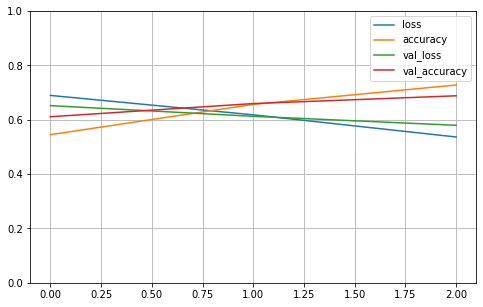

Train set ones/size 5288 / 10381
Compute valiation accuracy
Valid sizes (1154, 4997) (1154,)
Valid set ones/size 631 / 1154
Range of scores: 0.0046662786 to 0.98909456
Score threshold 0.5
Prediction set ones/size 465 / 1154


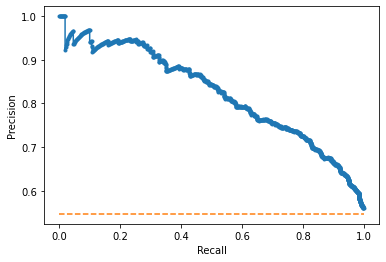

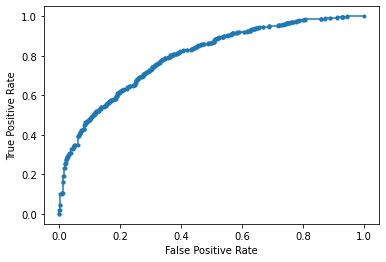

Accuracy: 68.80% Precision: 79.14% Recall: 58.32%
F1: 67.15% AUPRC: 82.39% AUROC: 79.65%
2023-02-06 19:23:48.036961
Fold 2
Model params (mean -0.10, wgt 0.49) (mean -2.12, wgt 0.51)
RCI threshold derived from training set: [-1.12991563]
FIT
2023-02-06 19:23:52.849983
Epoch 1/3
325/325 [==============================] - 5s 13ms/step - loss: 0.6905 - accuracy: 0.5434 - val_loss: 0.6755 - val_accuracy: 0.5667
Epoch 2/3
325/325 [==============================] - 4s 12ms/step - loss: 0.6258 - accuracy: 0.6522 - val_loss: 0.6041 - val_accuracy: 0.6664
Epoch 3/3
325/325 [==============================] - 4s 12ms/step - loss: 0.5579 - accuracy: 0.7147 - val_loss: 0.5430 - val_accuracy: 0.7210
PREDICT
2023-02-06 19:24:14.556953


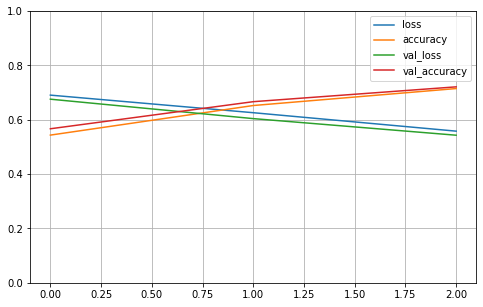

Train set ones/size 5322 / 10381
Compute valiation accuracy
Valid sizes (1154, 4997) (1154,)
Valid set ones/size 597 / 1154
Range of scores: 0.01126361 to 0.9901044
Score threshold 0.5
Prediction set ones/size 533 / 1154


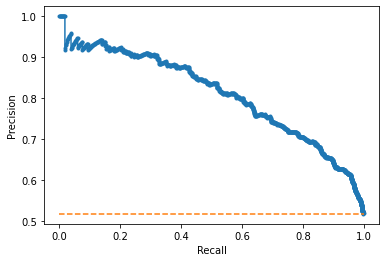

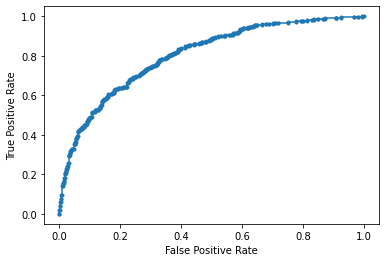

Accuracy: 72.10% Precision: 75.80% Recall: 67.67%
F1: 71.50% AUPRC: 81.06% AUROC: 80.45%
2023-02-06 19:24:15.319545
Fold 3
Model params (mean -0.06, wgt 0.49) (mean -2.13, wgt 0.51)
RCI threshold derived from training set: [-1.11889583]
FIT
2023-02-06 19:24:20.340936
Epoch 1/3
325/325 [==============================] - 5s 13ms/step - loss: 0.6952 - accuracy: 0.5422 - val_loss: 0.6692 - val_accuracy: 0.5771
Epoch 2/3
325/325 [==============================] - 4s 12ms/step - loss: 0.6347 - accuracy: 0.6409 - val_loss: 0.6182 - val_accuracy: 0.6672
Epoch 3/3
325/325 [==============================] - 4s 12ms/step - loss: 0.5635 - accuracy: 0.7115 - val_loss: 0.5666 - val_accuracy: 0.6967
PREDICT
2023-02-06 19:24:42.063391


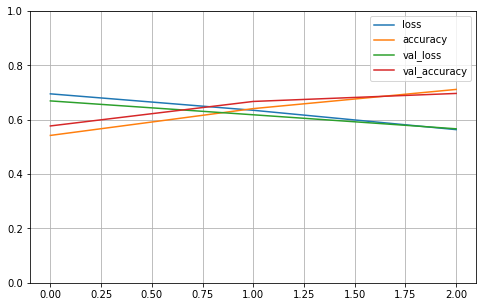

Train set ones/size 5316 / 10381
Compute valiation accuracy
Valid sizes (1154, 4997) (1154,)
Valid set ones/size 579 / 1154
Range of scores: 0.022957923 to 0.9747994
Score threshold 0.5
Prediction set ones/size 679 / 1154


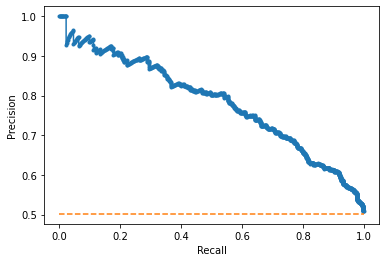

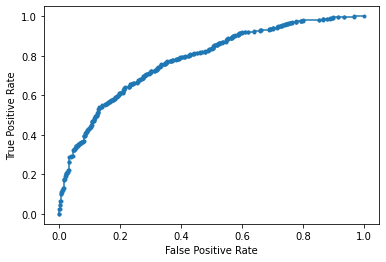

Accuracy: 69.67% Precision: 66.86% Recall: 78.41%
F1: 72.18% AUPRC: 78.37% AUROC: 78.21%
2023-02-06 19:24:42.989869
Fold 4
Model params (mean -2.13, wgt 0.51) (mean -0.06, wgt 0.49)
RCI threshold derived from training set: [-1.1232048]
FIT
2023-02-06 19:24:48.293670
Epoch 1/3
325/325 [==============================] - 5s 13ms/step - loss: 0.6878 - accuracy: 0.5481 - val_loss: 0.6587 - val_accuracy: 0.5953
Epoch 2/3
325/325 [==============================] - 4s 12ms/step - loss: 0.6280 - accuracy: 0.6467 - val_loss: 0.5974 - val_accuracy: 0.6880
Epoch 3/3
325/325 [==============================] - 4s 12ms/step - loss: 0.5500 - accuracy: 0.7205 - val_loss: 0.5497 - val_accuracy: 0.7227
PREDICT
2023-02-06 19:25:10.016744


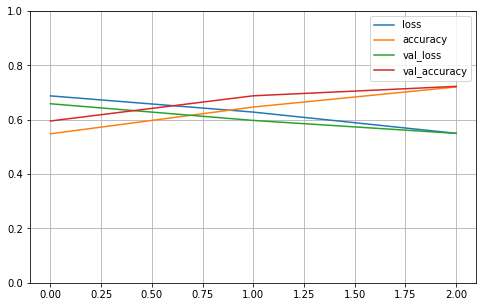

Train set ones/size 5318 / 10381
Compute valiation accuracy
Valid sizes (1154, 4997) (1154,)
Valid set ones/size 596 / 1154
Range of scores: 0.008880651 to 0.99067664
Score threshold 0.5
Prediction set ones/size 662 / 1154


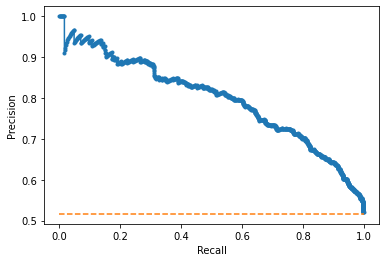

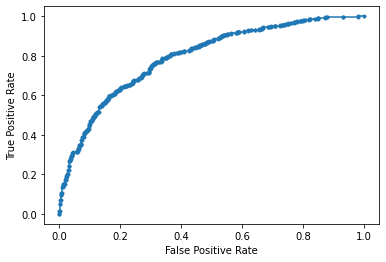

Accuracy: 72.27% Precision: 70.85% Recall: 78.69%
F1: 74.56% AUPRC: 79.84% AUROC: 79.47%
2023-02-06 19:25:10.933209
Fold 5
Model params (mean -0.09, wgt 0.50) (mean -2.13, wgt 0.50)
RCI threshold derived from training set: [-1.11837556]
FIT
2023-02-06 19:25:15.826435
Epoch 1/3
325/325 [==============================] - 5s 13ms/step - loss: 0.6913 - accuracy: 0.5388 - val_loss: 0.6596 - val_accuracy: 0.6109
Epoch 2/3
325/325 [==============================] - 4s 12ms/step - loss: 0.6315 - accuracy: 0.6508 - val_loss: 0.5796 - val_accuracy: 0.6846
Epoch 3/3
325/325 [==============================] - 4s 12ms/step - loss: 0.5586 - accuracy: 0.7113 - val_loss: 0.5689 - val_accuracy: 0.6811
PREDICT
2023-02-06 19:25:29.170715


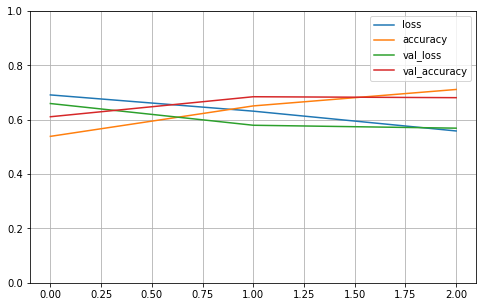

Train set ones/size 5335 / 10381
Compute valiation accuracy
Valid sizes (1154, 4997) (1154,)
Valid set ones/size 560 / 1154
Range of scores: 0.019361403 to 0.98275983
Score threshold 0.5
Prediction set ones/size 764 / 1154


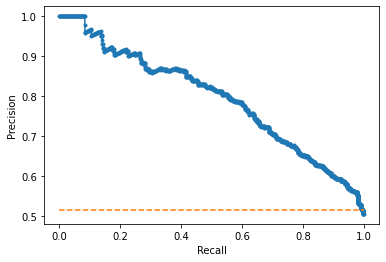

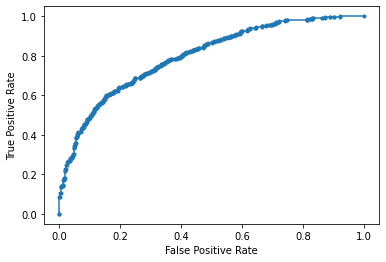

Accuracy: 68.11% Precision: 62.57% Recall: 85.36%
F1: 72.21% AUPRC: 79.43% AUROC: 79.82%
2023-02-06 19:25:29.905792
Fold 6
Model params (mean -0.06, wgt 0.49) (mean -2.13, wgt 0.51)
RCI threshold derived from training set: [-1.11632089]
FIT
2023-02-06 19:25:34.892420
Epoch 1/3
325/325 [==============================] - 5s 13ms/step - loss: 0.6946 - accuracy: 0.5223 - val_loss: 0.6596 - val_accuracy: 0.6080
Epoch 2/3
325/325 [==============================] - 4s 12ms/step - loss: 0.6310 - accuracy: 0.6412 - val_loss: 0.5727 - val_accuracy: 0.6964
Epoch 3/3
325/325 [==============================] - 4s 12ms/step - loss: 0.5442 - accuracy: 0.7221 - val_loss: 0.5290 - val_accuracy: 0.7285
PREDICT
2023-02-06 19:25:56.611622


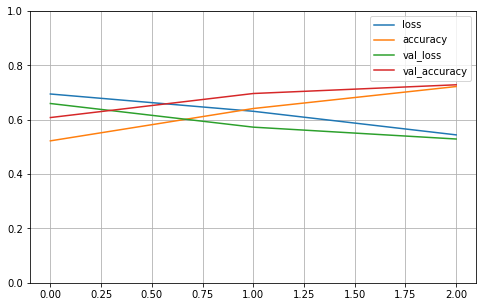

Train set ones/size 5321 / 10382
Compute valiation accuracy
Valid sizes (1153, 4997) (1153,)
Valid set ones/size 573 / 1153
Range of scores: 0.00808934 to 0.98165774
Score threshold 0.5
Prediction set ones/size 468 / 1153


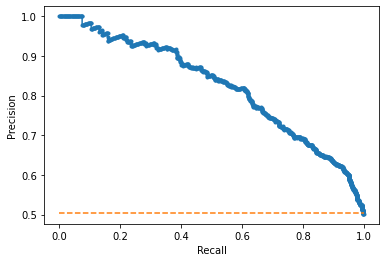

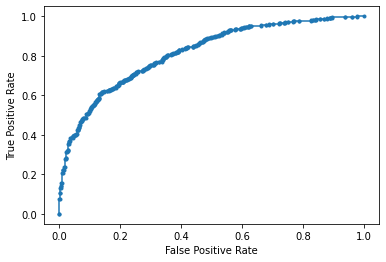

Accuracy: 72.85% Precision: 77.78% Recall: 63.53%
F1: 69.93% AUPRC: 82.34% AUROC: 81.63%
2023-02-06 19:25:57.387823
Fold 7
Model params (mean -0.07, wgt 0.49) (mean -2.14, wgt 0.51)
RCI threshold derived from training set: [-1.12710185]
FIT
2023-02-06 19:26:02.478517
Epoch 1/3
325/325 [==============================] - 5s 13ms/step - loss: 0.6935 - accuracy: 0.5359 - val_loss: 0.6700 - val_accuracy: 0.5976
Epoch 2/3
325/325 [==============================] - 4s 12ms/step - loss: 0.6346 - accuracy: 0.6398 - val_loss: 0.6363 - val_accuracy: 0.6453
Epoch 3/3
325/325 [==============================] - 4s 13ms/step - loss: 0.5558 - accuracy: 0.7150 - val_loss: 0.5952 - val_accuracy: 0.6739
PREDICT
2023-02-06 19:26:24.189132


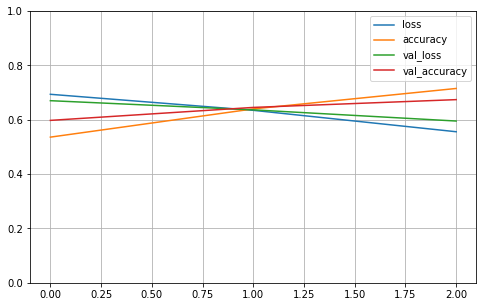

Train set ones/size 5323 / 10382
Compute valiation accuracy
Valid sizes (1153, 4997) (1153,)
Valid set ones/size 591 / 1153
Range of scores: 0.010382081 to 0.9844433
Score threshold 0.5
Prediction set ones/size 691 / 1153


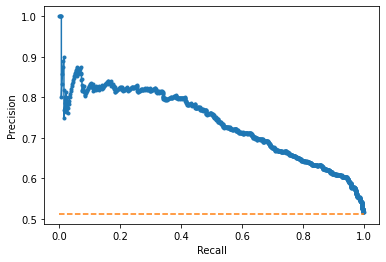

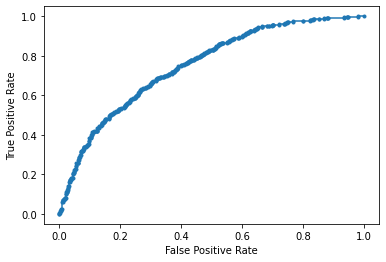

Accuracy: 67.39% Precision: 65.56% Recall: 76.65%
F1: 70.67% AUPRC: 73.76% AUROC: 75.17%
2023-02-06 19:26:24.958300
Fold 8
Model params (mean -2.12, wgt 0.51) (mean -0.08, wgt 0.49)
RCI threshold derived from training set: [-1.12433821]
FIT
2023-02-06 19:26:29.779098
Epoch 1/3
325/325 [==============================] - 5s 13ms/step - loss: 0.6958 - accuracy: 0.5248 - val_loss: 0.6702 - val_accuracy: 0.5872
Epoch 2/3
325/325 [==============================] - 4s 12ms/step - loss: 0.6448 - accuracy: 0.6298 - val_loss: 0.6361 - val_accuracy: 0.6288
Epoch 3/3
325/325 [==============================] - 4s 12ms/step - loss: 0.5538 - accuracy: 0.7198 - val_loss: 0.5549 - val_accuracy: 0.7086
PREDICT
2023-02-06 19:26:43.275178


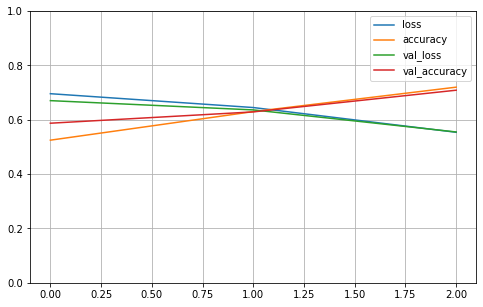

Train set ones/size 5314 / 10382
Compute valiation accuracy
Valid sizes (1153, 4997) (1153,)
Valid set ones/size 600 / 1153
Range of scores: 0.013108539 to 0.99272823
Score threshold 0.5
Prediction set ones/size 606 / 1153


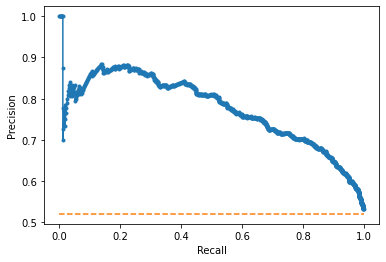

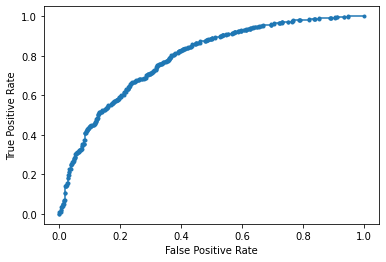

Accuracy: 70.86% Precision: 71.78% Recall: 72.50%
F1: 72.14% AUPRC: 77.60% AUROC: 78.85%
2023-02-06 19:26:44.086181
Fold 9
Model params (mean -0.05, wgt 0.48) (mean -2.12, wgt 0.52)
RCI threshold derived from training set: [-1.12093965]
FIT
2023-02-06 19:26:49.201532
Epoch 1/3
325/325 [==============================] - 5s 13ms/step - loss: 0.6949 - accuracy: 0.5304 - val_loss: 0.6562 - val_accuracy: 0.6114
Epoch 2/3
325/325 [==============================] - 4s 12ms/step - loss: 0.6283 - accuracy: 0.6493 - val_loss: 0.6035 - val_accuracy: 0.6574
Epoch 3/3
325/325 [==============================] - 4s 12ms/step - loss: 0.5372 - accuracy: 0.7277 - val_loss: 0.5542 - val_accuracy: 0.7155
PREDICT
2023-02-06 19:27:10.930257


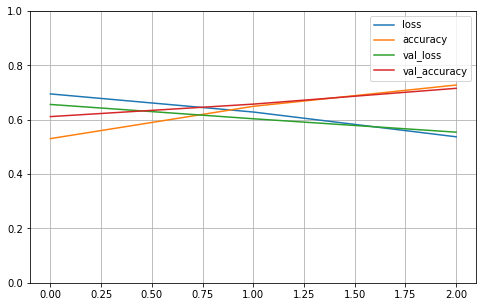

Train set ones/size 5305 / 10382
Compute valiation accuracy
Valid sizes (1153, 4997) (1153,)
Valid set ones/size 591 / 1153
Range of scores: 0.0037165037 to 0.9623039
Score threshold 0.5
Prediction set ones/size 465 / 1153


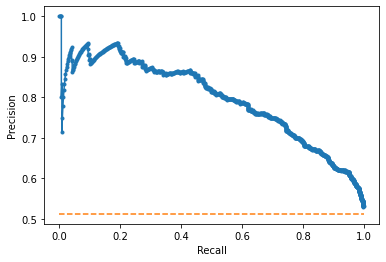

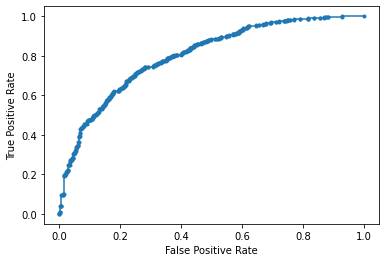

Accuracy: 71.55% Precision: 78.28% Recall: 61.59%
F1: 68.94% AUPRC: 79.58% AUROC: 80.15%
2023-02-06 19:27:11.816672
Fold 10
Model params (mean -2.13, wgt 0.51) (mean -0.07, wgt 0.49)
RCI threshold derived from training set: [-1.12356824]
FIT
2023-02-06 19:27:17.072690
Epoch 1/3
325/325 [==============================] - 5s 13ms/step - loss: 0.6996 - accuracy: 0.5249 - val_loss: 0.6636 - val_accuracy: 0.6010
Epoch 2/3
325/325 [==============================] - 4s 12ms/step - loss: 0.6412 - accuracy: 0.6274 - val_loss: 0.6234 - val_accuracy: 0.6487
Epoch 3/3
325/325 [==============================] - 4s 12ms/step - loss: 0.5609 - accuracy: 0.7147 - val_loss: 0.5811 - val_accuracy: 0.6930
PREDICT
2023-02-06 19:27:30.481364


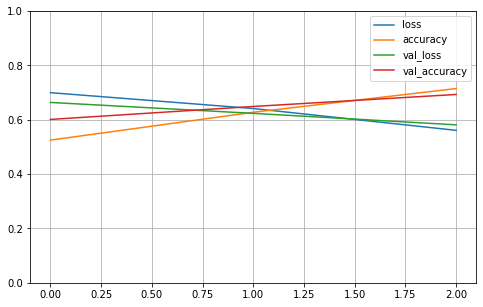

Train set ones/size 5325 / 10382
Compute valiation accuracy
Valid sizes (1153, 4997) (1153,)
Valid set ones/size 589 / 1153
Range of scores: 0.0025470292 to 0.97970814
Score threshold 0.5
Prediction set ones/size 525 / 1153


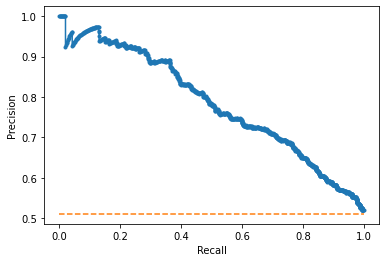

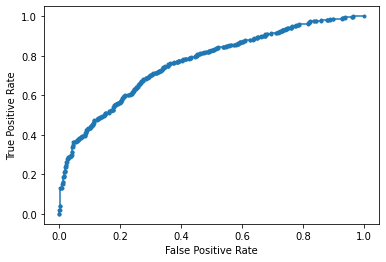

Accuracy: 69.30% Precision: 72.38% Recall: 64.52%
F1: 68.22% AUPRC: 78.55% AUROC: 76.51%
2023-02-06 19:27:31.223528

Completed cross validation 10 folds 3 epochs
 accuracy mean 70.29% +/- 1.90
 precision mean 72.10% +/- 5.74
 recall mean 70.72% +/- 8.89
 F1 mean 70.75% +/- 2.22
 AUPRC mean 79.29% +/- 2.52
 AUROC mean 78.99% +/- 1.92
Finished cell Line 6 MCF.7

2023-02-06 19:27:32.701283
Start cell Line 7 NCI.H460
Number of RCI values loaded 610
Num RCI: 610
Load sequence...
Cross validation...
2023-02-06 19:27:39.809953
splitting
Fold 1
Model params (mean -0.87, wgt 0.56) (mean -1.86, wgt 0.44)
RCI threshold derived from training set: [-1.30837524]
FIT
2023-02-06 19:27:41.793754
Epoch 1/3
147/147 [==============================] - 3s 13ms/step - loss: 0.6931 - accuracy: 0.5337 - val_loss: 0.6707 - val_accuracy: 0.5747
Epoch 2/3
147/147 [==============================] - 2s 12ms/step - loss: 0.5971 - accuracy: 0.6804 - val_loss: 0.5177 - val_accuracy: 0.7452
Epoch 3/3
147/147 [=========

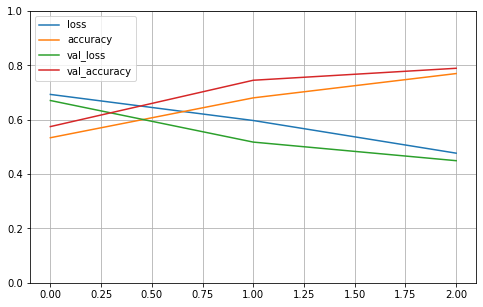

Train set ones/size 2408 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 267 / 522
Range of scores: 0.00877365 to 0.9980903
Score threshold 0.5
Prediction set ones/size 275 / 522


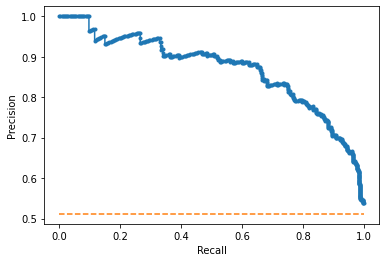

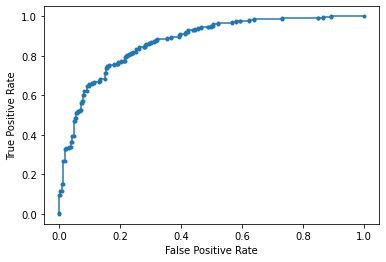

Accuracy: 78.93% Precision: 78.55% Recall: 80.90%
F1: 79.70% AUPRC: 87.01% AUROC: 87.13%
2023-02-06 19:27:48.855566
Fold 2
Model params (mean -1.87, wgt 0.45) (mean -0.84, wgt 0.55)
RCI threshold derived from training set: [-1.29751712]
FIT
2023-02-06 19:27:51.951546
Epoch 1/3
147/147 [==============================] - 3s 14ms/step - loss: 0.6948 - accuracy: 0.5469 - val_loss: 0.6389 - val_accuracy: 0.6916
Epoch 2/3
147/147 [==============================] - 2s 13ms/step - loss: 0.5648 - accuracy: 0.7060 - val_loss: 0.6322 - val_accuracy: 0.6590
Epoch 3/3
147/147 [==============================] - 2s 12ms/step - loss: 0.4772 - accuracy: 0.7745 - val_loss: 0.4450 - val_accuracy: 0.7874
PREDICT
2023-02-06 19:27:58.546844


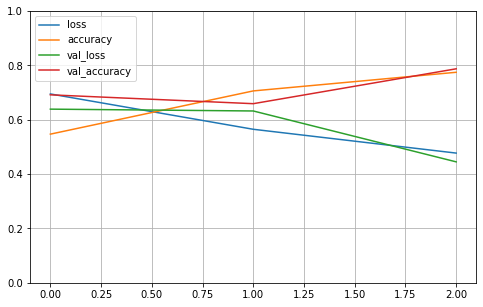

Train set ones/size 2421 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 254 / 522
Range of scores: 0.0051927194 to 0.98719794
Score threshold 0.5
Prediction set ones/size 223 / 522


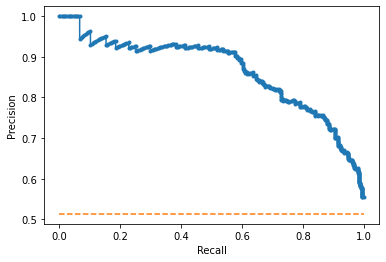

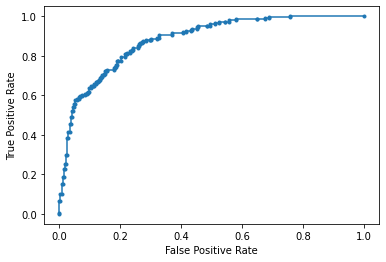

Accuracy: 78.74% Precision: 82.06% Recall: 72.05%
F1: 76.73% AUPRC: 86.56% AUROC: 88.05%
2023-02-06 19:27:59.244566
Fold 3
Model params (mean -0.87, wgt 0.56) (mean -1.85, wgt 0.44)
RCI threshold derived from training set: [-1.3034472]
FIT
2023-02-06 19:28:02.520200
Epoch 1/3
147/147 [==============================] - 3s 14ms/step - loss: 0.6949 - accuracy: 0.5397 - val_loss: 0.6546 - val_accuracy: 0.6590
Epoch 2/3
147/147 [==============================] - 2s 13ms/step - loss: 0.6162 - accuracy: 0.6655 - val_loss: 0.5632 - val_accuracy: 0.7050
Epoch 3/3
147/147 [==============================] - 2s 12ms/step - loss: 0.5029 - accuracy: 0.7596 - val_loss: 0.4786 - val_accuracy: 0.7663
PREDICT
2023-02-06 19:28:09.117828


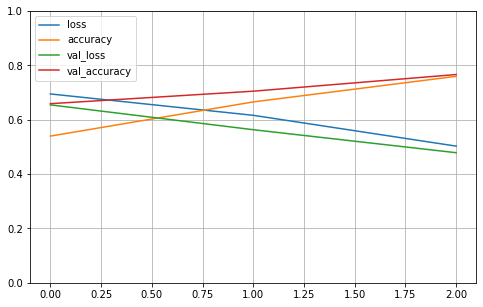

Train set ones/size 2413 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 262 / 522
Range of scores: 0.026287526 to 0.9989618
Score threshold 0.5
Prediction set ones/size 300 / 522


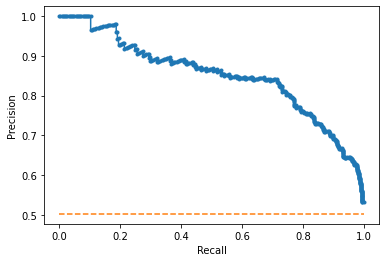

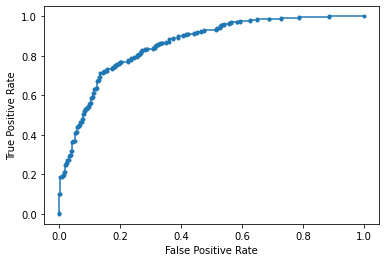

Accuracy: 76.63% Precision: 73.33% Recall: 83.97%
F1: 78.29% AUPRC: 85.15% AUROC: 85.84%
2023-02-06 19:28:09.814773
Fold 4
Model params (mean -1.80, wgt 0.44) (mean -0.89, wgt 0.56)
RCI threshold derived from training set: [-1.29129568]
FIT
2023-02-06 19:28:13.075139
Epoch 1/3
147/147 [==============================] - 3s 14ms/step - loss: 0.6910 - accuracy: 0.5389 - val_loss: 0.6575 - val_accuracy: 0.6130
Epoch 2/3
147/147 [==============================] - 2s 13ms/step - loss: 0.5720 - accuracy: 0.7009 - val_loss: 0.7497 - val_accuracy: 0.5977
Epoch 3/3
147/147 [==============================] - 2s 12ms/step - loss: 0.4838 - accuracy: 0.7703 - val_loss: 0.5916 - val_accuracy: 0.6858
PREDICT
2023-02-06 19:28:19.711192


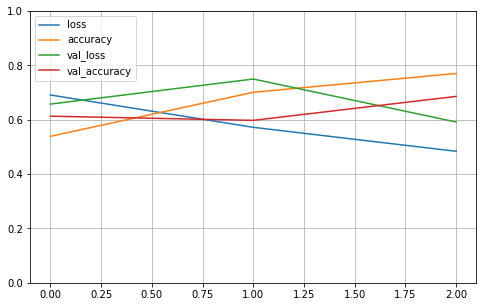

Train set ones/size 2418 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 255 / 522
Range of scores: 0.020424265 to 0.99998176
Score threshold 0.5
Prediction set ones/size 383 / 522


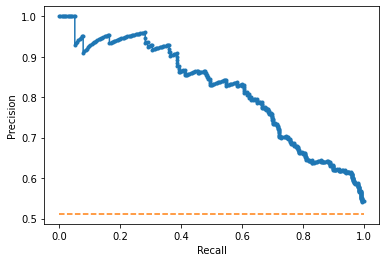

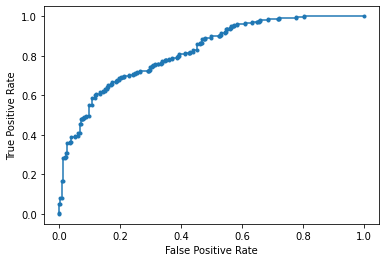

Accuracy: 68.58% Precision: 61.88% Recall: 92.94%
F1: 74.29% AUPRC: 81.92% AUROC: 82.27%
2023-02-06 19:28:20.337949
Fold 5
Model params (mean -1.86, wgt 0.45) (mean -0.86, wgt 0.55)
RCI threshold derived from training set: [-1.30375184]
FIT
2023-02-06 19:28:23.779641
Epoch 1/3
147/147 [==============================] - 3s 14ms/step - loss: 0.6909 - accuracy: 0.5484 - val_loss: 0.6543 - val_accuracy: 0.6015
Epoch 2/3
147/147 [==============================] - 2s 13ms/step - loss: 0.5849 - accuracy: 0.6902 - val_loss: 0.5172 - val_accuracy: 0.7433
Epoch 3/3
147/147 [==============================] - 2s 12ms/step - loss: 0.4698 - accuracy: 0.7784 - val_loss: 0.5124 - val_accuracy: 0.7356
PREDICT
2023-02-06 19:28:30.394820


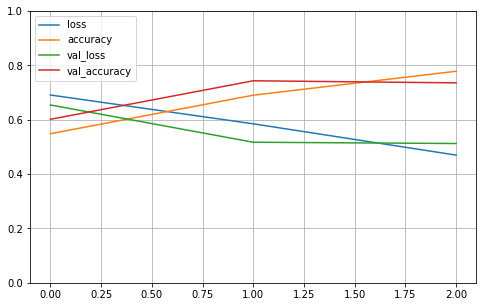

Train set ones/size 2409 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 266 / 522
Range of scores: 0.007255064 to 0.9981207
Score threshold 0.5
Prediction set ones/size 334 / 522


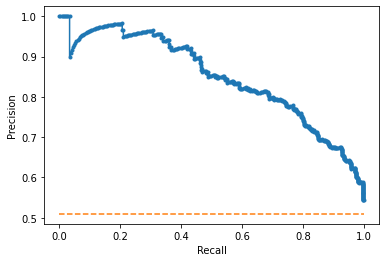

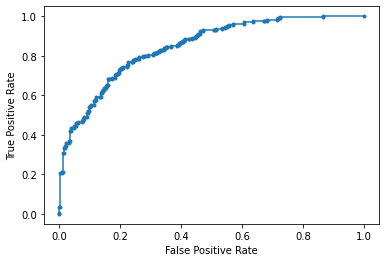

Accuracy: 73.56% Precision: 69.16% Recall: 86.84%
F1: 77.00% AUPRC: 84.98% AUROC: 84.63%
2023-02-06 19:28:31.043452
Fold 6
Model params (mean -0.94, wgt 0.67) (mean -2.05, wgt 0.33)
RCI threshold derived from training set: [-1.30494837]
FIT
2023-02-06 19:28:34.608624
Epoch 1/3
147/147 [==============================] - 3s 14ms/step - loss: 0.6990 - accuracy: 0.5331 - val_loss: 0.6816 - val_accuracy: 0.5230
Epoch 2/3
147/147 [==============================] - 2s 12ms/step - loss: 0.5966 - accuracy: 0.6698 - val_loss: 0.5355 - val_accuracy: 0.7280
Epoch 3/3
147/147 [==============================] - 2s 12ms/step - loss: 0.4449 - accuracy: 0.7877 - val_loss: 0.4846 - val_accuracy: 0.7586
PREDICT
2023-02-06 19:28:45.733957


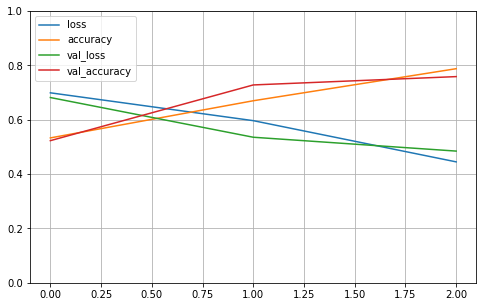

Train set ones/size 2414 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 261 / 522
Range of scores: 0.002882366 to 0.9921566
Score threshold 0.5
Prediction set ones/size 191 / 522


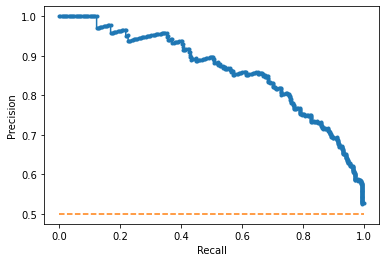

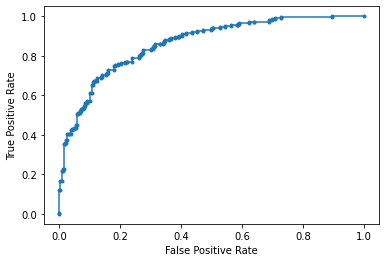

Accuracy: 75.86% Precision: 85.34% Recall: 62.45%
F1: 72.12% AUPRC: 86.43% AUROC: 86.32%
2023-02-06 19:28:46.360120
Fold 7
Model params (mean -1.00, wgt 0.67) (mean -1.91, wgt 0.33)
RCI threshold derived from training set: [-1.30325461]
FIT
2023-02-06 19:28:49.532678
Epoch 1/3
147/147 [==============================] - 3s 14ms/step - loss: 0.6951 - accuracy: 0.5393 - val_loss: 0.6335 - val_accuracy: 0.6628
Epoch 2/3
147/147 [==============================] - 2s 12ms/step - loss: 0.5816 - accuracy: 0.6902 - val_loss: 0.5060 - val_accuracy: 0.7452
Epoch 3/3
147/147 [==============================] - 2s 12ms/step - loss: 0.4549 - accuracy: 0.7854 - val_loss: 0.4471 - val_accuracy: 0.7989
PREDICT
2023-02-06 19:28:56.138755


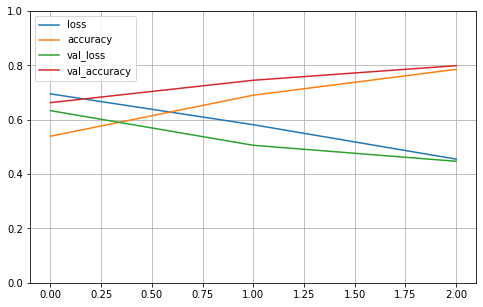

Train set ones/size 2406 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 269 / 522
Range of scores: 0.0042196354 to 0.9947626
Score threshold 0.5
Prediction set ones/size 296 / 522


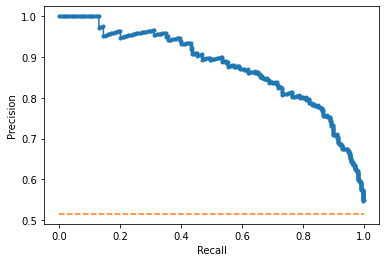

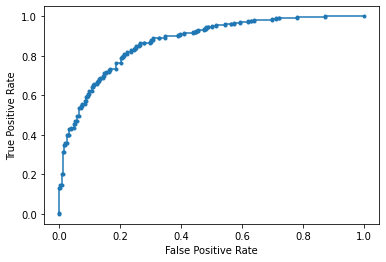

Accuracy: 79.89% Precision: 77.70% Recall: 85.50%
F1: 81.42% AUPRC: 87.77% AUROC: 87.29%
2023-02-06 19:28:56.848350
Fold 8
Model params (mean -1.78, wgt 0.51) (mean -0.81, wgt 0.49)
RCI threshold derived from training set: [-1.30937409]
FIT
2023-02-06 19:28:59.962511
Epoch 1/3
147/147 [==============================] - 3s 14ms/step - loss: 0.6932 - accuracy: 0.5376 - val_loss: 0.6552 - val_accuracy: 0.6667
Epoch 2/3
147/147 [==============================] - 2s 12ms/step - loss: 0.5753 - accuracy: 0.6973 - val_loss: 0.5059 - val_accuracy: 0.7510
Epoch 3/3
147/147 [==============================] - 2s 12ms/step - loss: 0.4500 - accuracy: 0.7916 - val_loss: 0.4656 - val_accuracy: 0.7816
PREDICT
2023-02-06 19:29:06.549058


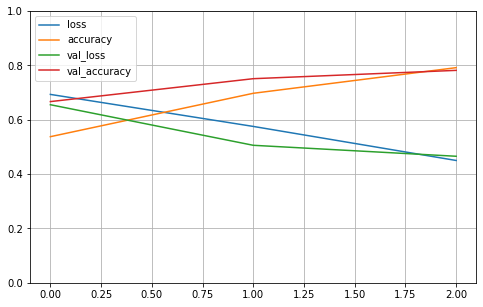

Train set ones/size 2406 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 269 / 522
Range of scores: 0.003777507 to 0.9976568
Score threshold 0.5
Prediction set ones/size 265 / 522


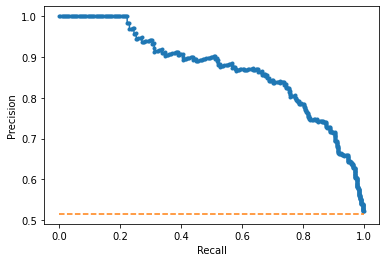

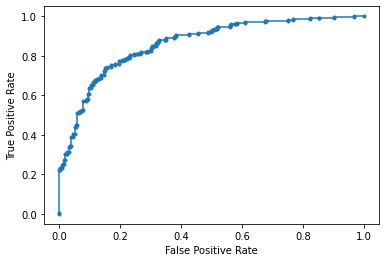

Accuracy: 78.16% Precision: 79.25% Recall: 78.07%
F1: 78.65% AUPRC: 87.14% AUROC: 86.21%
2023-02-06 19:29:07.215335
Fold 9
Model params (mean -0.98, wgt 0.67) (mean -1.99, wgt 0.33)
RCI threshold derived from training set: [-1.31584407]
FIT
2023-02-06 19:29:10.331509
Epoch 1/3
147/147 [==============================] - 3s 14ms/step - loss: 0.6994 - accuracy: 0.5325 - val_loss: 0.6657 - val_accuracy: 0.5632
Epoch 2/3
147/147 [==============================] - 2s 12ms/step - loss: 0.6110 - accuracy: 0.6670 - val_loss: 0.5471 - val_accuracy: 0.7050
Epoch 3/3
147/147 [==============================] - 2s 13ms/step - loss: 0.4538 - accuracy: 0.7903 - val_loss: 0.4649 - val_accuracy: 0.7797
PREDICT
2023-02-06 19:29:17.067777


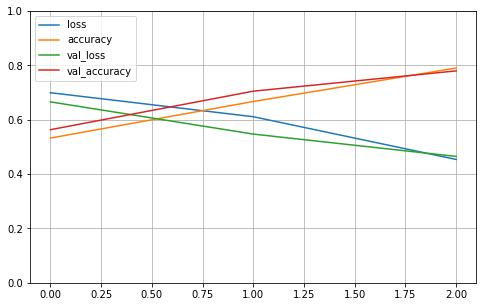

Train set ones/size 2387 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 289 / 522
Range of scores: 0.0029669434 to 0.9959921
Score threshold 0.5
Prediction set ones/size 310 / 522


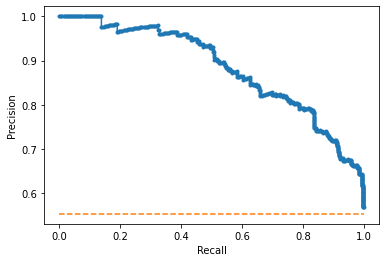

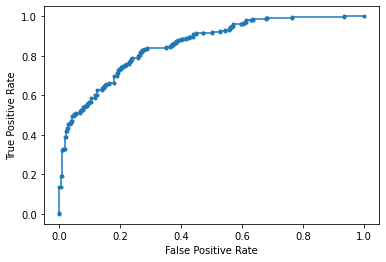

Accuracy: 77.97% Precision: 78.06% Recall: 83.74%
F1: 80.80% AUPRC: 88.36% AUROC: 85.55%
2023-02-06 19:29:17.780344
Fold 10
Model params (mean -2.07, wgt 0.34) (mean -0.93, wgt 0.66)
RCI threshold derived from training set: [-1.3128045]
FIT
2023-02-06 19:29:21.187598
Epoch 1/3
147/147 [==============================] - 3s 14ms/step - loss: 0.6990 - accuracy: 0.5270 - val_loss: 0.6728 - val_accuracy: 0.5835
Epoch 2/3
147/147 [==============================] - 2s 12ms/step - loss: 0.6002 - accuracy: 0.6707 - val_loss: 0.5502 - val_accuracy: 0.7447
Epoch 3/3
147/147 [==============================] - 2s 12ms/step - loss: 0.4533 - accuracy: 0.7933 - val_loss: 0.4440 - val_accuracy: 0.7908
PREDICT
2023-02-06 19:29:32.293469


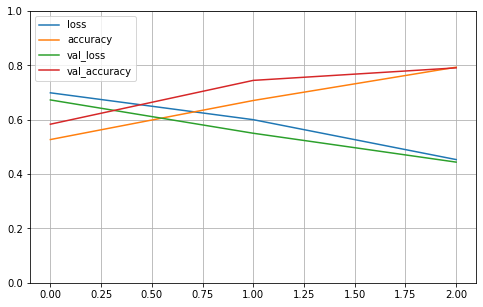

Train set ones/size 2392 / 4698
Compute valiation accuracy
Valid sizes (521, 4997) (521,)
Valid set ones/size 283 / 521
Range of scores: 0.009878377 to 0.9961398
Score threshold 0.5
Prediction set ones/size 286 / 521


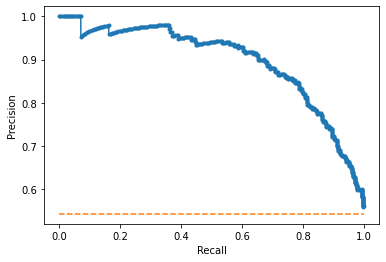

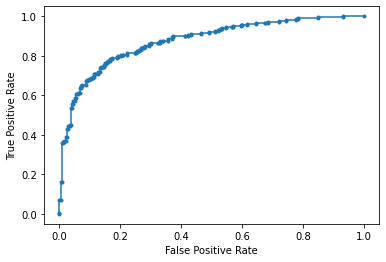

Accuracy: 79.08% Precision: 80.42% Recall: 81.27%
F1: 80.84% AUPRC: 89.69% AUROC: 87.53%
2023-02-06 19:29:32.979373

Completed cross validation 10 folds 3 epochs
 accuracy mean 76.74% +/- 3.42
 precision mean 76.58% +/- 6.81
 recall mean 80.77% +/- 8.47
 F1 mean 77.99% +/- 3.02
 AUPRC mean 86.50% +/- 2.14
 AUROC mean 86.08% +/- 1.69
Finished cell Line 7 NCI.H460

2023-02-06 19:29:34.306913
Start cell Line 8 NHEK
Number of RCI values loaded 1080
Num RCI: 1080
Load sequence...
Cross validation...
2023-02-06 19:29:45.248821
splitting
Fold 1
Model params (mean -1.79, wgt 0.50) (mean 0.48, wgt 0.50)
RCI threshold derived from training set: [-0.65307966]
FIT
2023-02-06 19:29:47.830730
Epoch 1/3
229/229 [==============================] - 4s 13ms/step - loss: 0.6849 - accuracy: 0.5568 - val_loss: 0.6202 - val_accuracy: 0.6597
Epoch 2/3
229/229 [==============================] - 3s 12ms/step - loss: 0.5785 - accuracy: 0.6975 - val_loss: 0.5550 - val_accuracy: 0.7113
Epoch 3/3
229/229 [=========

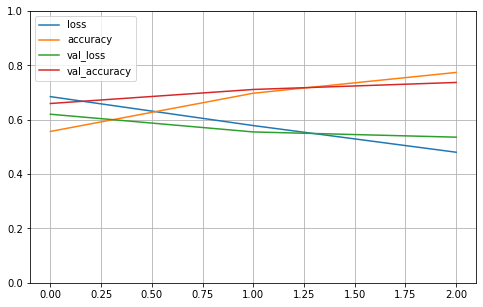

Train set ones/size 3732 / 7318
Compute valiation accuracy
Valid sizes (814, 4997) (814,)
Valid set ones/size 432 / 814
Range of scores: 0.0007867451 to 0.99722254
Score threshold 0.5
Prediction set ones/size 546 / 814


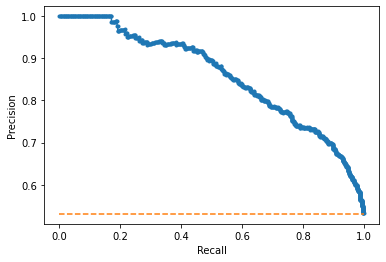

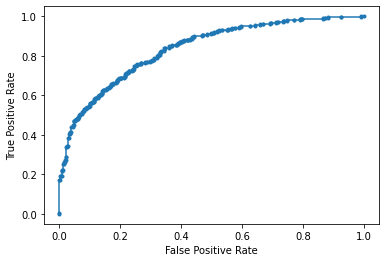

Accuracy: 73.71% Precision: 69.96% Recall: 88.43%
F1: 78.12% AUPRC: 85.85% AUROC: 83.54%
2023-02-06 19:29:58.177421
Fold 2
Model params (mean 0.51, wgt 0.49) (mean -1.75, wgt 0.51)
RCI threshold derived from training set: [-0.64129587]
FIT
2023-02-06 19:30:02.256543
Epoch 1/3
229/229 [==============================] - 4s 13ms/step - loss: 0.6795 - accuracy: 0.5581 - val_loss: 0.6573 - val_accuracy: 0.6044
Epoch 2/3
229/229 [==============================] - 3s 12ms/step - loss: 0.5778 - accuracy: 0.6946 - val_loss: 0.5547 - val_accuracy: 0.7174
Epoch 3/3
229/229 [==============================] - 3s 12ms/step - loss: 0.4753 - accuracy: 0.7745 - val_loss: 0.4896 - val_accuracy: 0.7641
PREDICT
2023-02-06 19:30:13.552850


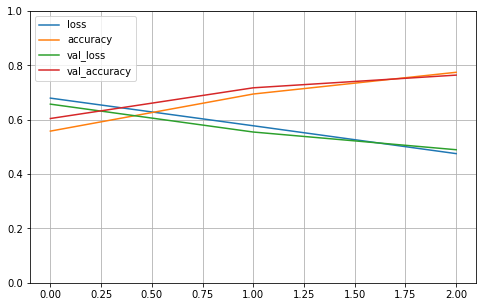

Train set ones/size 3723 / 7318
Compute valiation accuracy
Valid sizes (814, 4997) (814,)
Valid set ones/size 417 / 814
Range of scores: 0.0029436874 to 0.9979982
Score threshold 0.5
Prediction set ones/size 437 / 814


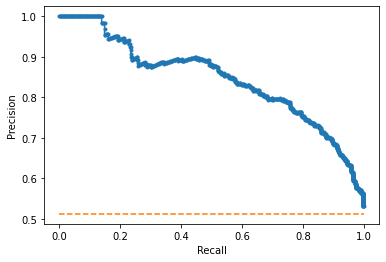

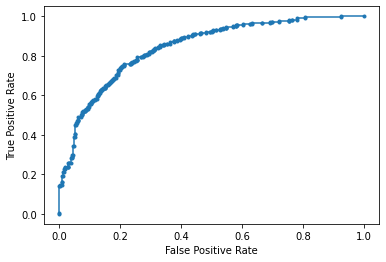

Accuracy: 76.41% Precision: 75.74% Recall: 79.38%
F1: 77.52% AUPRC: 84.53% AUROC: 84.30%
2023-02-06 19:30:14.245145
Fold 3
Model params (mean 0.51, wgt 0.50) (mean -1.79, wgt 0.50)
RCI threshold derived from training set: [-0.64307243]
FIT
2023-02-06 19:30:18.525633
Epoch 1/3
229/229 [==============================] - 4s 13ms/step - loss: 0.6949 - accuracy: 0.5404 - val_loss: 0.6553 - val_accuracy: 0.6125
Epoch 2/3
229/229 [==============================] - 3s 12ms/step - loss: 0.6239 - accuracy: 0.6546 - val_loss: 0.5926 - val_accuracy: 0.6691
Epoch 3/3
229/229 [==============================] - 3s 12ms/step - loss: 0.5301 - accuracy: 0.7358 - val_loss: 0.5809 - val_accuracy: 0.6827
PREDICT
2023-02-06 19:30:29.814535


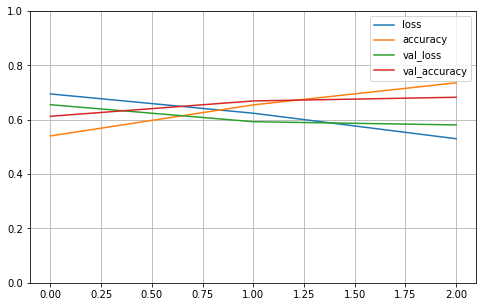

Train set ones/size 3731 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 409 / 813
Range of scores: 0.002740221 to 0.98473996
Score threshold 0.5
Prediction set ones/size 235 / 813


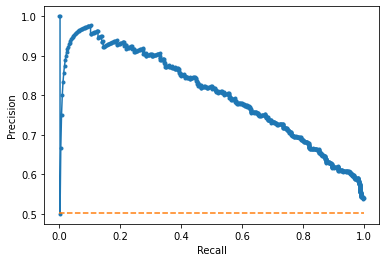

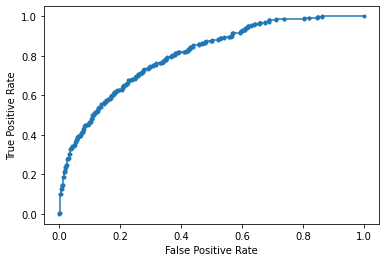

Accuracy: 68.27% Precision: 82.13% Recall: 47.19%
F1: 59.94% AUPRC: 80.19% AUROC: 80.54%
2023-02-06 19:30:30.487132
Fold 4
Model params (mean 0.46, wgt 0.51) (mean -1.79, wgt 0.49)
RCI threshold derived from training set: [-0.65200085]
FIT
2023-02-06 19:30:34.752662
Epoch 1/3
229/229 [==============================] - 4s 13ms/step - loss: 0.6900 - accuracy: 0.5480 - val_loss: 0.6759 - val_accuracy: 0.5990
Epoch 2/3
229/229 [==============================] - 3s 12ms/step - loss: 0.6169 - accuracy: 0.6557 - val_loss: 0.5997 - val_accuracy: 0.6704
Epoch 3/3
229/229 [==============================] - 3s 12ms/step - loss: 0.5272 - accuracy: 0.7373 - val_loss: 0.5610 - val_accuracy: 0.6925
PREDICT
2023-02-06 19:30:44.304088


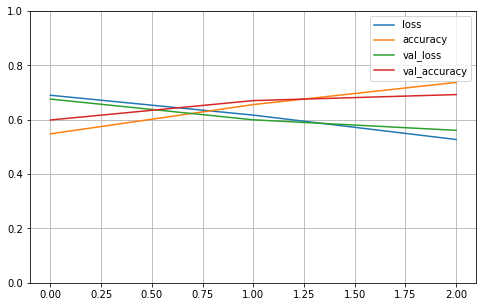

Train set ones/size 3748 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 415 / 813
Range of scores: 0.0061998256 to 0.9502867
Score threshold 0.5
Prediction set ones/size 255 / 813


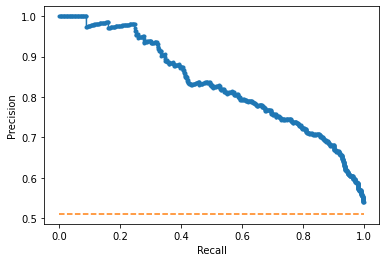

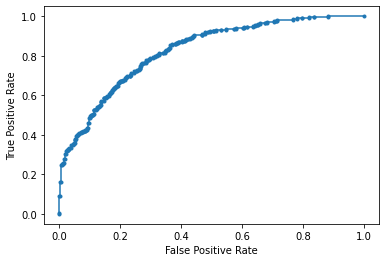

Accuracy: 69.25% Precision: 82.35% Recall: 50.60%
F1: 62.69% AUPRC: 83.34% AUROC: 82.57%
2023-02-06 19:30:44.973981
Fold 5
Model params (mean 0.47, wgt 0.51) (mean -1.81, wgt 0.49)
RCI threshold derived from training set: [-0.6458179]
FIT
2023-02-06 19:30:49.199028
Epoch 1/3
229/229 [==============================] - 4s 13ms/step - loss: 0.6944 - accuracy: 0.5434 - val_loss: 0.6622 - val_accuracy: 0.5966
Epoch 2/3
229/229 [==============================] - 3s 12ms/step - loss: 0.6104 - accuracy: 0.6629 - val_loss: 0.6275 - val_accuracy: 0.6458
Epoch 3/3
229/229 [==============================] - 3s 12ms/step - loss: 0.5213 - accuracy: 0.7422 - val_loss: 0.5198 - val_accuracy: 0.7282
PREDICT
2023-02-06 19:30:58.828946


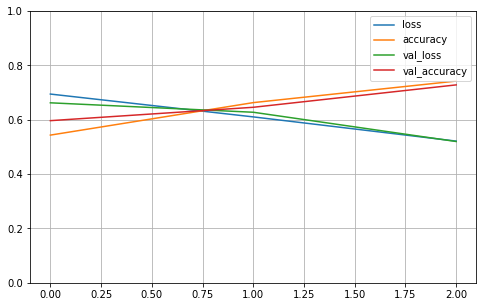

Train set ones/size 3752 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 406 / 813
Range of scores: 0.008705749 to 0.96686065
Score threshold 0.5
Prediction set ones/size 369 / 813


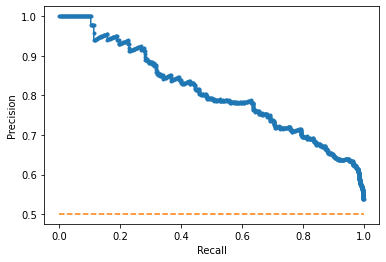

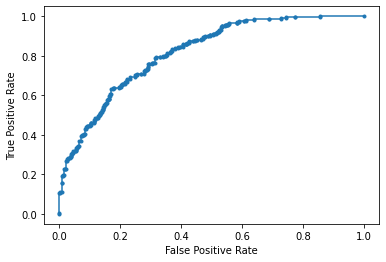

Accuracy: 72.82% Precision: 75.07% Recall: 68.23%
F1: 71.48% AUPRC: 81.02% AUROC: 81.75%
2023-02-06 19:30:59.550021
Fold 6
Model params (mean 0.50, wgt 0.50) (mean -1.79, wgt 0.50)
RCI threshold derived from training set: [-0.64565343]
FIT
2023-02-06 19:31:03.473195
Epoch 1/3
229/229 [==============================] - 4s 13ms/step - loss: 0.6852 - accuracy: 0.5640 - val_loss: 0.6414 - val_accuracy: 0.6433
Epoch 2/3
229/229 [==============================] - 3s 12ms/step - loss: 0.5933 - accuracy: 0.6849 - val_loss: 0.5549 - val_accuracy: 0.7171
Epoch 3/3
229/229 [==============================] - 3s 12ms/step - loss: 0.5016 - accuracy: 0.7557 - val_loss: 0.5559 - val_accuracy: 0.7245
PREDICT
2023-02-06 19:31:13.060288


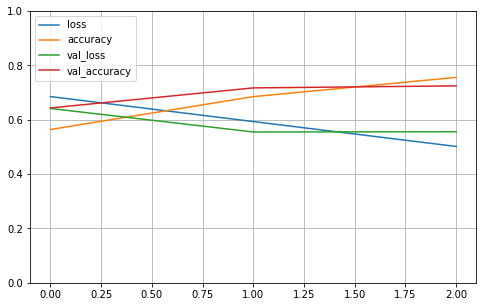

Train set ones/size 3736 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 422 / 813
Range of scores: 0.016690064 to 0.9944396
Score threshold 0.5
Prediction set ones/size 556 / 813


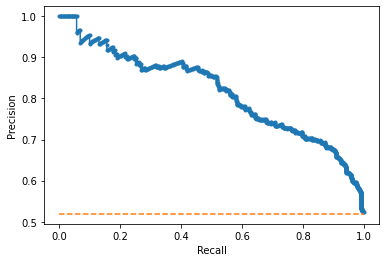

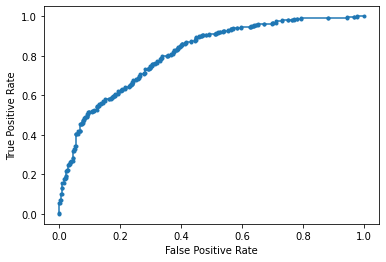

Accuracy: 72.45% Precision: 67.81% Recall: 89.34%
F1: 77.10% AUPRC: 81.58% AUROC: 81.08%
2023-02-06 19:31:13.788459
Fold 7
Model params (mean -1.82, wgt 0.49) (mean 0.46, wgt 0.51)
RCI threshold derived from training set: [-0.66297166]
FIT
2023-02-06 19:31:17.768913
Epoch 1/3
229/229 [==============================] - 4s 13ms/step - loss: 0.6939 - accuracy: 0.5345 - val_loss: 0.6325 - val_accuracy: 0.6273
Epoch 2/3
229/229 [==============================] - 3s 12ms/step - loss: 0.5968 - accuracy: 0.6770 - val_loss: 0.5057 - val_accuracy: 0.7515
Epoch 3/3
229/229 [==============================] - 3s 12ms/step - loss: 0.5191 - accuracy: 0.7430 - val_loss: 0.4809 - val_accuracy: 0.7835
PREDICT
2023-02-06 19:31:29.075959


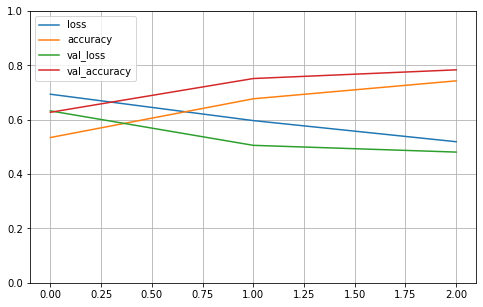

Train set ones/size 3729 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 439 / 813
Range of scores: 0.0061151637 to 0.98575854
Score threshold 0.5
Prediction set ones/size 515 / 813


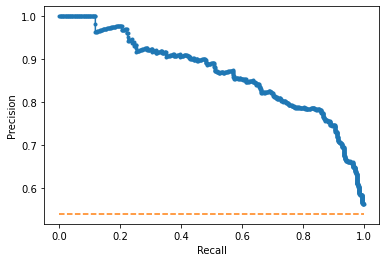

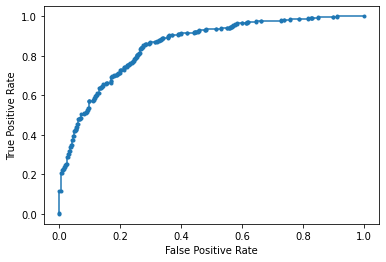

Accuracy: 78.35% Precision: 75.53% Recall: 88.61%
F1: 81.55% AUPRC: 86.70% AUROC: 85.34%
2023-02-06 19:31:29.771583
Fold 8
Model params (mean 0.46, wgt 0.51) (mean -1.79, wgt 0.49)
RCI threshold derived from training set: [-0.64386296]
FIT
2023-02-06 19:31:33.642636
Epoch 1/3
229/229 [==============================] - 4s 13ms/step - loss: 0.6891 - accuracy: 0.5422 - val_loss: 0.6281 - val_accuracy: 0.6581
Epoch 2/3
229/229 [==============================] - 3s 12ms/step - loss: 0.6052 - accuracy: 0.6710 - val_loss: 0.5562 - val_accuracy: 0.7122
Epoch 3/3
229/229 [==============================] - 3s 12ms/step - loss: 0.5174 - accuracy: 0.7330 - val_loss: 0.5279 - val_accuracy: 0.7183
PREDICT
2023-02-06 19:31:43.117945


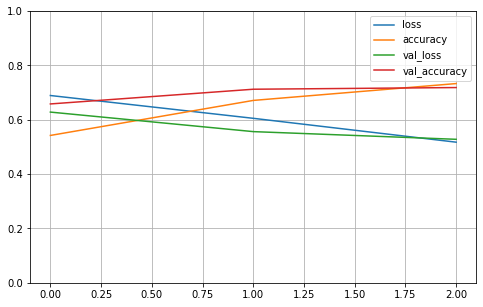

Train set ones/size 3737 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 405 / 813
Range of scores: 0.0021912623 to 0.9780051
Score threshold 0.5
Prediction set ones/size 372 / 813


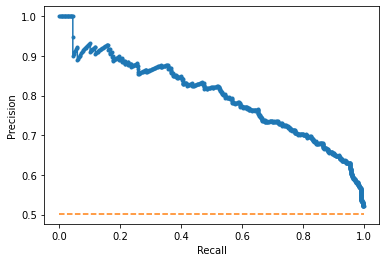

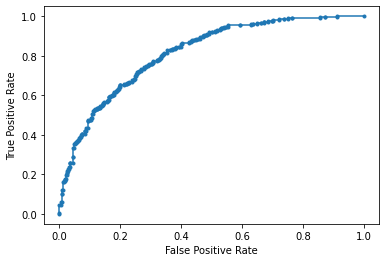

Accuracy: 71.83% Precision: 73.66% Recall: 67.65%
F1: 70.53% AUPRC: 79.90% AUROC: 81.49%
2023-02-06 19:31:43.824353
Fold 9
Model params (mean 0.49, wgt 0.50) (mean -1.78, wgt 0.50)
RCI threshold derived from training set: [-0.64435241]
FIT
2023-02-06 19:31:47.877192
Epoch 1/3
229/229 [==============================] - 4s 13ms/step - loss: 0.6879 - accuracy: 0.5524 - val_loss: 0.6461 - val_accuracy: 0.6212
Epoch 2/3
229/229 [==============================] - 3s 12ms/step - loss: 0.5952 - accuracy: 0.6840 - val_loss: 0.5479 - val_accuracy: 0.7085
Epoch 3/3
229/229 [==============================] - 3s 12ms/step - loss: 0.4903 - accuracy: 0.7575 - val_loss: 0.4974 - val_accuracy: 0.7478
PREDICT
2023-02-06 19:31:57.489066


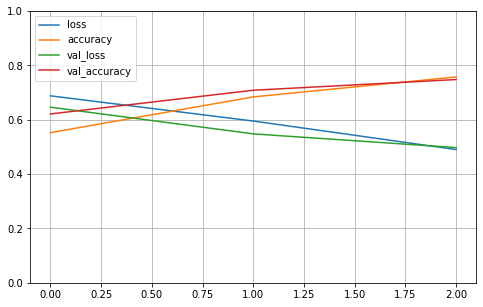

Train set ones/size 3731 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 411 / 813
Range of scores: 0.0027439608 to 0.9949303
Score threshold 0.5
Prediction set ones/size 450 / 813


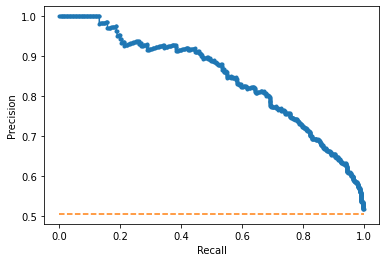

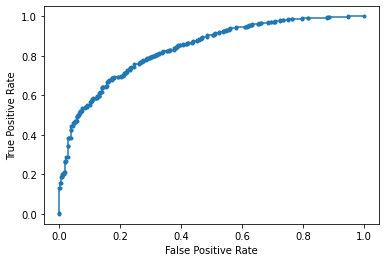

Accuracy: 74.78% Precision: 72.89% Recall: 79.81%
F1: 76.19% AUPRC: 84.63% AUROC: 83.67%
2023-02-06 19:31:58.155757
Fold 10
Model params (mean -1.80, wgt 0.48) (mean 0.44, wgt 0.52)
RCI threshold derived from training set: [-0.64877053]
FIT
2023-02-06 19:32:02.006037
Epoch 1/3
229/229 [==============================] - 3s 13ms/step - loss: 0.6905 - accuracy: 0.5443 - val_loss: 0.6536 - val_accuracy: 0.6298
Epoch 2/3
229/229 [==============================] - 3s 12ms/step - loss: 0.6204 - accuracy: 0.6551 - val_loss: 0.5646 - val_accuracy: 0.7109
Epoch 3/3
229/229 [==============================] - 3s 12ms/step - loss: 0.5238 - accuracy: 0.7366 - val_loss: 0.5140 - val_accuracy: 0.7528
PREDICT
2023-02-06 19:32:11.511839


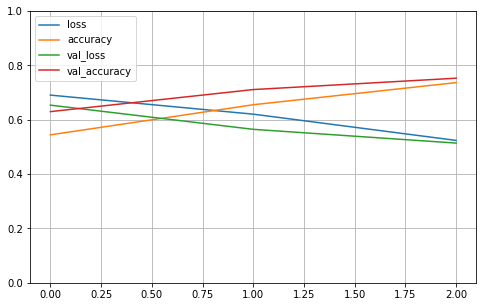

Train set ones/size 3759 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 399 / 813
Range of scores: 0.010902697 to 0.9826726
Score threshold 0.5
Prediction set ones/size 338 / 813


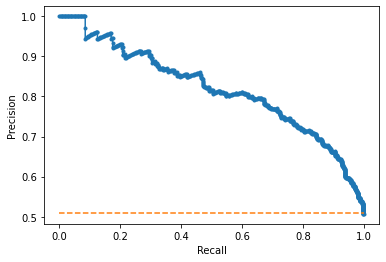

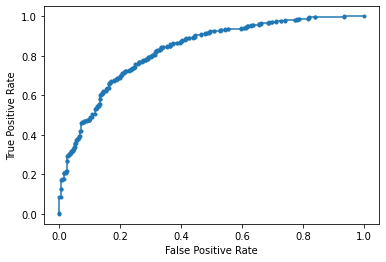

Accuracy: 75.28% Precision: 79.29% Recall: 67.17%
F1: 72.73% AUPRC: 81.95% AUROC: 83.01%
2023-02-06 19:32:12.297874

Completed cross validation 10 folds 3 epochs
 accuracy mean 73.31% +/- 3.10
 precision mean 75.44% +/- 4.78
 recall mean 72.64% +/- 15.23
 F1 mean 72.78% +/- 6.93
 AUPRC mean 82.97% +/- 2.39
 AUROC mean 82.73% +/- 1.53
Finished cell Line 8 NHEK

2023-02-06 19:32:13.685778
Start cell Line 9 SK.MEL.5
Number of RCI values loaded 534
Num RCI: 534
Load sequence...
Cross validation...
2023-02-06 19:32:20.618202
splitting
Fold 1
Model params (mean -2.59, wgt 0.42) (mean -0.89, wgt 0.58)
RCI threshold derived from training set: [-1.60972998]
FIT
2023-02-06 19:32:22.553129
Epoch 1/3
145/145 [==============================] - 3s 14ms/step - loss: 0.6970 - accuracy: 0.5432 - val_loss: 0.6650 - val_accuracy: 0.5837
Epoch 2/3
145/145 [==============================] - 2s 12ms/step - loss: 0.6179 - accuracy: 0.6593 - val_loss: 0.5306 - val_accuracy: 0.7374
Epoch 3/3
145/145 [=========

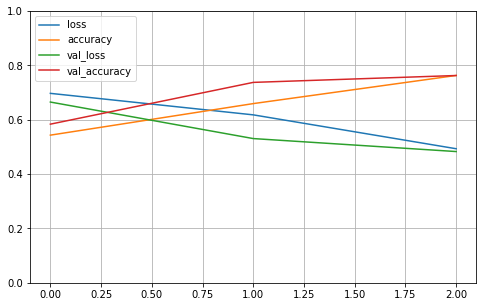

Train set ones/size 2434 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 260 / 514
Range of scores: 0.0010262551 to 0.9939188
Score threshold 0.5
Prediction set ones/size 246 / 514


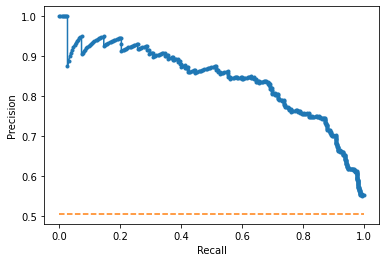

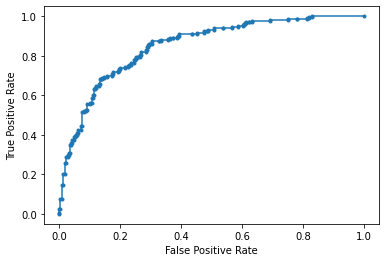

Accuracy: 76.26% Precision: 78.05% Recall: 73.85%
F1: 75.89% AUPRC: 84.11% AUROC: 85.16%
2023-02-06 19:32:34.413464
Fold 2
Model params (mean -0.90, wgt 0.58) (mean -2.58, wgt 0.42)
RCI threshold derived from training set: [-1.60727976]
FIT
2023-02-06 19:32:37.667987
Epoch 1/3
145/145 [==============================] - 3s 14ms/step - loss: 0.6917 - accuracy: 0.5486 - val_loss: 0.6667 - val_accuracy: 0.6323
Epoch 2/3
145/145 [==============================] - 2s 13ms/step - loss: 0.6105 - accuracy: 0.6699 - val_loss: 0.5547 - val_accuracy: 0.7004
Epoch 3/3
145/145 [==============================] - 2s 12ms/step - loss: 0.5025 - accuracy: 0.7594 - val_loss: 0.5091 - val_accuracy: 0.7432
PREDICT
2023-02-06 19:32:44.183985


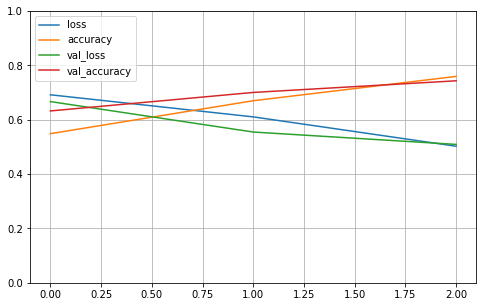

Train set ones/size 2414 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 279 / 514
Range of scores: 0.003680388 to 0.98928845
Score threshold 0.5
Prediction set ones/size 307 / 514


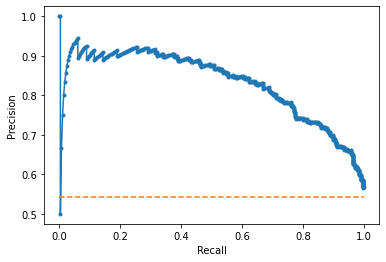

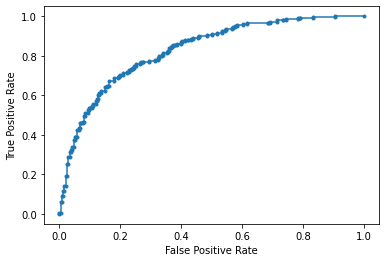

Accuracy: 74.32% Precision: 73.94% Recall: 81.36%
F1: 77.47% AUPRC: 83.16% AUROC: 82.87%
2023-02-06 19:32:44.803748
Fold 3
Model params (mean -2.68, wgt 0.41) (mean -0.88, wgt 0.59)
RCI threshold derived from training set: [-1.60867525]
FIT
2023-02-06 19:32:47.911622
Epoch 1/3
145/145 [==============================] - 3s 14ms/step - loss: 0.6930 - accuracy: 0.5445 - val_loss: 0.6662 - val_accuracy: 0.6051
Epoch 2/3
145/145 [==============================] - 2s 12ms/step - loss: 0.6212 - accuracy: 0.6585 - val_loss: 0.5683 - val_accuracy: 0.6984
Epoch 3/3
145/145 [==============================] - 2s 12ms/step - loss: 0.4888 - accuracy: 0.7564 - val_loss: 0.4982 - val_accuracy: 0.7432
PREDICT
2023-02-06 19:32:59.081843


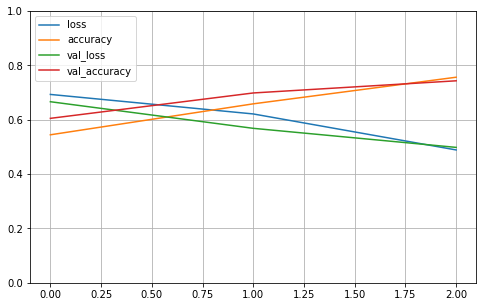

Train set ones/size 2427 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 266 / 514
Range of scores: 0.0037057863 to 0.99056983
Score threshold 0.5
Prediction set ones/size 260 / 514


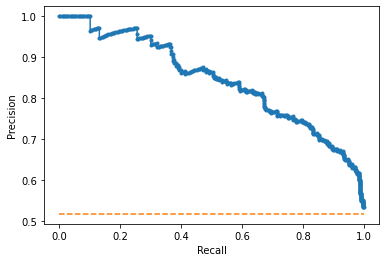

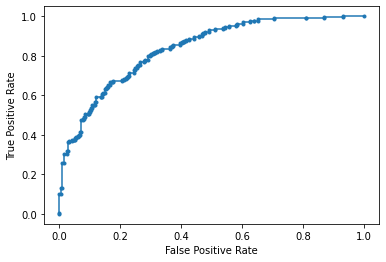

Accuracy: 74.32% Precision: 75.77% Recall: 74.06%
F1: 74.90% AUPRC: 84.46% AUROC: 83.60%
2023-02-06 19:32:59.763395
Fold 4
Model params (mean -0.90, wgt 0.58) (mean -2.58, wgt 0.42)
RCI threshold derived from training set: [-1.60670646]
FIT
2023-02-06 19:33:02.976694
Epoch 1/3
145/145 [==============================] - 3s 14ms/step - loss: 0.6790 - accuracy: 0.5651 - val_loss: 0.6273 - val_accuracy: 0.6634
Epoch 2/3
145/145 [==============================] - 2s 12ms/step - loss: 0.5863 - accuracy: 0.6883 - val_loss: 0.5155 - val_accuracy: 0.7471
Epoch 3/3
145/145 [==============================] - 2s 12ms/step - loss: 0.4824 - accuracy: 0.7661 - val_loss: 0.4772 - val_accuracy: 0.7374
PREDICT
2023-02-06 19:33:09.467755


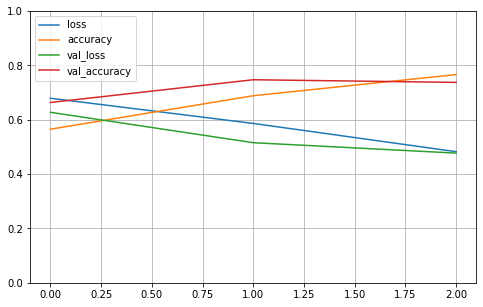

Train set ones/size 2428 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 265 / 514
Range of scores: 0.0022411593 to 0.9877828
Score threshold 0.5
Prediction set ones/size 260 / 514


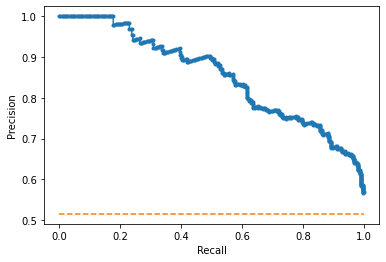

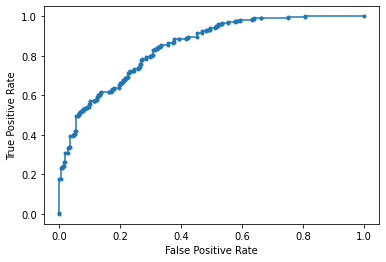

Accuracy: 73.74% Precision: 75.00% Recall: 73.58%
F1: 74.29% AUPRC: 85.44% AUROC: 84.60%
2023-02-06 19:33:10.114034
Fold 5
Model params (mean -0.90, wgt 0.58) (mean -2.59, wgt 0.42)
RCI threshold derived from training set: [-1.61486545]
FIT
2023-02-06 19:33:13.333829
Epoch 1/3
145/145 [==============================] - 3s 14ms/step - loss: 0.6991 - accuracy: 0.5478 - val_loss: 0.6752 - val_accuracy: 0.5661
Epoch 2/3
145/145 [==============================] - 2s 12ms/step - loss: 0.6204 - accuracy: 0.6563 - val_loss: 0.5656 - val_accuracy: 0.6965
Epoch 3/3
145/145 [==============================] - 2s 13ms/step - loss: 0.5095 - accuracy: 0.7503 - val_loss: 0.4948 - val_accuracy: 0.7451
PREDICT
2023-02-06 19:33:24.469573


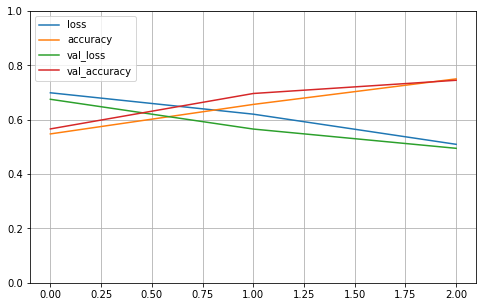

Train set ones/size 2428 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 275 / 514
Range of scores: 0.00860137 to 0.99545455
Score threshold 0.5
Prediction set ones/size 294 / 514


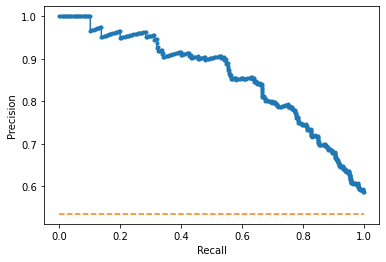

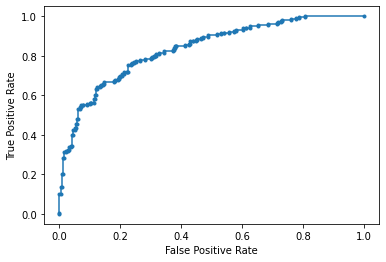

Accuracy: 74.51% Precision: 74.49% Recall: 79.64%
F1: 76.98% AUPRC: 85.79% AUROC: 83.56%
2023-02-06 19:33:25.112947
Fold 6
Model params (mean -0.88, wgt 0.59) (mean -2.68, wgt 0.41)
RCI threshold derived from training set: [-1.60975057]
FIT
2023-02-06 19:33:28.820100
Epoch 1/3
145/145 [==============================] - 3s 14ms/step - loss: 0.6901 - accuracy: 0.5478 - val_loss: 0.6643 - val_accuracy: 0.6109
Epoch 2/3
145/145 [==============================] - 2s 12ms/step - loss: 0.6046 - accuracy: 0.6639 - val_loss: 0.5512 - val_accuracy: 0.7257
Epoch 3/3
145/145 [==============================] - 2s 12ms/step - loss: 0.4983 - accuracy: 0.7562 - val_loss: 0.5079 - val_accuracy: 0.7335
PREDICT
2023-02-06 19:33:39.948104


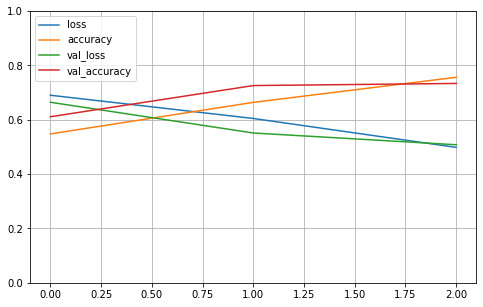

Train set ones/size 2424 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 270 / 514
Range of scores: 0.006355962 to 0.9966294
Score threshold 0.5
Prediction set ones/size 307 / 514


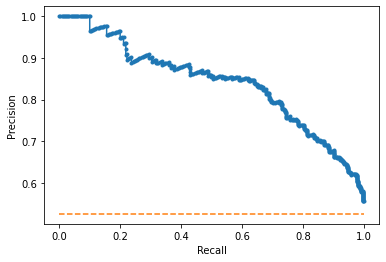

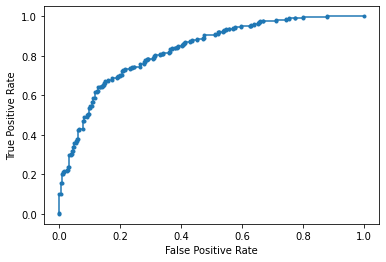

Accuracy: 73.35% Precision: 71.66% Recall: 81.48%
F1: 76.26% AUPRC: 84.13% AUROC: 83.11%
2023-02-06 19:33:40.637340
Fold 7
Model params (mean -0.90, wgt 0.57) (mean -2.59, wgt 0.43)
RCI threshold derived from training set: [-1.62552212]
FIT
2023-02-06 19:33:43.718579
Epoch 1/3
145/145 [==============================] - 3s 14ms/step - loss: 0.6915 - accuracy: 0.5532 - val_loss: 0.6468 - val_accuracy: 0.6420
Epoch 2/3
145/145 [==============================] - 2s 12ms/step - loss: 0.6072 - accuracy: 0.6680 - val_loss: 0.5584 - val_accuracy: 0.7062
Epoch 3/3
145/145 [==============================] - 2s 13ms/step - loss: 0.4970 - accuracy: 0.7583 - val_loss: 0.5474 - val_accuracy: 0.7276
PREDICT
2023-02-06 19:33:54.854874


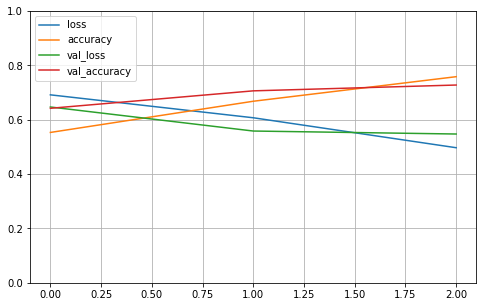

Train set ones/size 2421 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 282 / 514
Range of scores: 0.0017693713 to 0.9887144
Score threshold 0.5
Prediction set ones/size 250 / 514


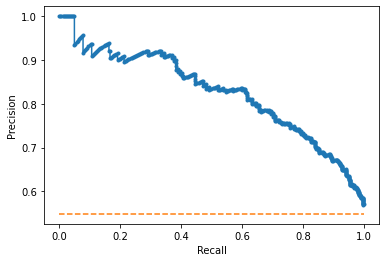

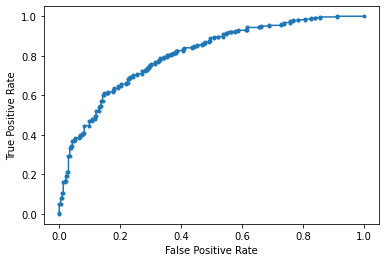

Accuracy: 72.76% Precision: 78.40% Recall: 69.50%
F1: 73.68% AUPRC: 82.73% AUROC: 80.50%
2023-02-06 19:33:55.491365
Fold 8
Model params (mean -0.87, wgt 0.59) (mean -2.70, wgt 0.41)
RCI threshold derived from training set: [-1.61392773]
FIT
2023-02-06 19:33:58.932253
Epoch 1/3
145/145 [==============================] - 3s 14ms/step - loss: 0.6947 - accuracy: 0.5476 - val_loss: 0.6757 - val_accuracy: 0.5681
Epoch 2/3
145/145 [==============================] - 2s 12ms/step - loss: 0.6183 - accuracy: 0.6550 - val_loss: 0.5720 - val_accuracy: 0.6673
Epoch 3/3
145/145 [==============================] - 2s 12ms/step - loss: 0.4868 - accuracy: 0.7652 - val_loss: 0.5375 - val_accuracy: 0.6965
PREDICT
2023-02-06 19:34:05.470428


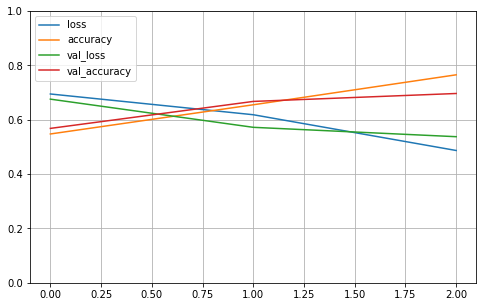

Train set ones/size 2442 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 261 / 514
Range of scores: 0.003940654 to 0.9915343
Score threshold 0.5
Prediction set ones/size 217 / 514


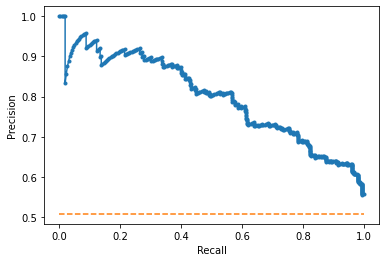

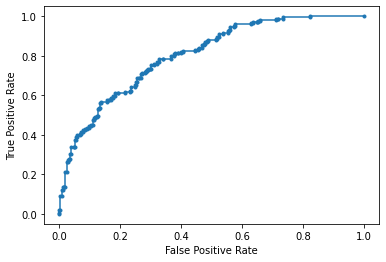

Accuracy: 69.65% Precision: 74.19% Recall: 61.69%
F1: 67.36% AUPRC: 79.83% AUROC: 80.38%
2023-02-06 19:34:06.226129
Fold 9
Model params (mean -0.91, wgt 0.58) (mean -2.60, wgt 0.42)
RCI threshold derived from training set: [-1.62406433]
FIT
2023-02-06 19:34:09.648983
Epoch 1/3
145/145 [==============================] - 3s 14ms/step - loss: 0.6891 - accuracy: 0.5452 - val_loss: 0.6604 - val_accuracy: 0.6167
Epoch 2/3
145/145 [==============================] - 2s 13ms/step - loss: 0.5977 - accuracy: 0.6710 - val_loss: 0.5438 - val_accuracy: 0.7043
Epoch 3/3
145/145 [==============================] - 2s 12ms/step - loss: 0.4495 - accuracy: 0.7877 - val_loss: 0.4111 - val_accuracy: 0.8152
PREDICT
2023-02-06 19:34:16.195187


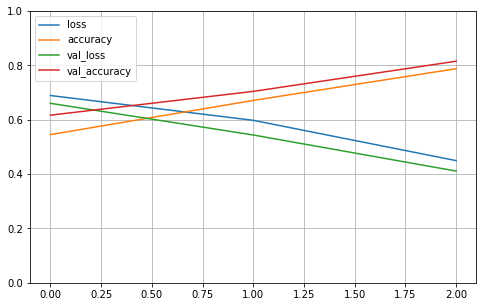

Train set ones/size 2415 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 288 / 514
Range of scores: 0.00035941528 to 0.99693155
Score threshold 0.5
Prediction set ones/size 277 / 514


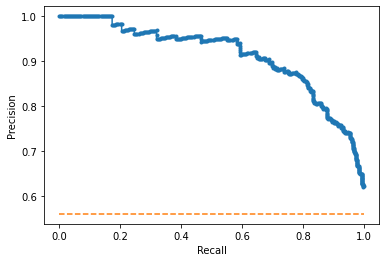

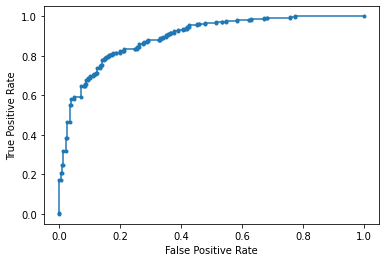

Accuracy: 81.52% Precision: 84.84% Recall: 81.60%
F1: 83.19% AUPRC: 91.30% AUROC: 89.41%
2023-02-06 19:34:16.846990
Fold 10
Model params (mean -0.88, wgt 0.58) (mean -2.57, wgt 0.42)
RCI threshold derived from training set: [-1.59179504]
FIT
2023-02-06 19:34:20.397645
Epoch 1/3
145/145 [==============================] - 3s 14ms/step - loss: 0.6917 - accuracy: 0.5447 - val_loss: 0.6603 - val_accuracy: 0.6304
Epoch 2/3
145/145 [==============================] - 2s 12ms/step - loss: 0.6150 - accuracy: 0.6585 - val_loss: 0.5561 - val_accuracy: 0.7062
Epoch 3/3
145/145 [==============================] - 2s 13ms/step - loss: 0.4865 - accuracy: 0.7748 - val_loss: 0.4981 - val_accuracy: 0.7529
PREDICT
2023-02-06 19:34:27.013238


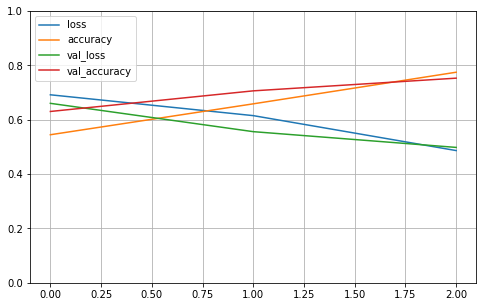

Train set ones/size 2403 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 250 / 514
Range of scores: 0.0030987642 to 0.9950246
Score threshold 0.5
Prediction set ones/size 291 / 514


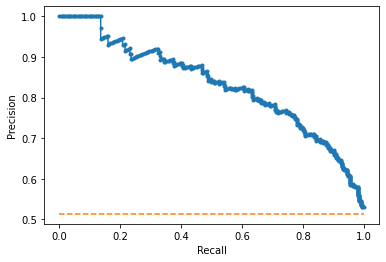

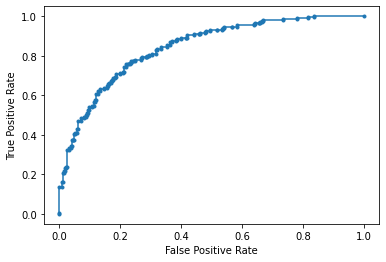

Accuracy: 75.29% Precision: 71.13% Recall: 82.80%
F1: 76.52% AUPRC: 83.25% AUROC: 84.22%
2023-02-06 19:34:27.757189

Completed cross validation 10 folds 3 epochs
 accuracy mean 74.57% +/- 3.01
 precision mean 75.75% +/- 3.95
 recall mean 75.96% +/- 6.76
 F1 mean 75.65% +/- 3.92
 AUPRC mean 84.42% +/- 2.93
 AUROC mean 83.74% +/- 2.54
Finished cell Line 9 SK.MEL.5

2023-02-06 19:34:29.101615
Start cell Line 10 SK.N.DZ
Number of RCI values loaded 603
Num RCI: 603
Load sequence...
Cross validation...
2023-02-06 19:34:36.987108
splitting
Fold 1
Model params (mean -0.21, wgt 0.64) (mean -1.38, wgt 0.36)
RCI threshold derived from training set: [-0.62812968]
FIT
2023-02-06 19:34:39.191961
Epoch 1/3
163/163 [==============================] - 3s 14ms/step - loss: 0.6768 - accuracy: 0.5861 - val_loss: 0.6029 - val_accuracy: 0.6990
Epoch 2/3
163/163 [==============================] - 2s 13ms/step - loss: 0.5746 - accuracy: 0.7066 - val_loss: 0.5005 - val_accuracy: 0.7578
Epoch 3/3
163/163 [======

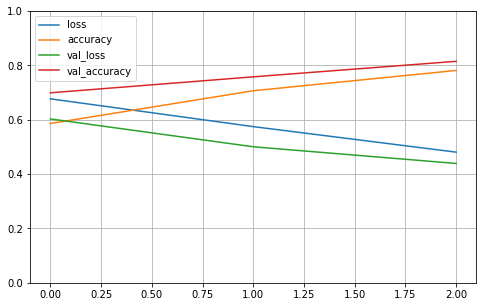

Train set ones/size 2971 / 5194
Compute valiation accuracy
Valid sizes (578, 4997) (578,)
Valid set ones/size 334 / 578
Range of scores: 0.03047282 to 0.99694496
Score threshold 0.5
Prediction set ones/size 389 / 578


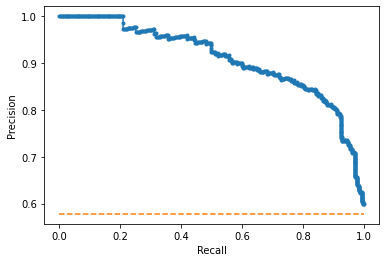

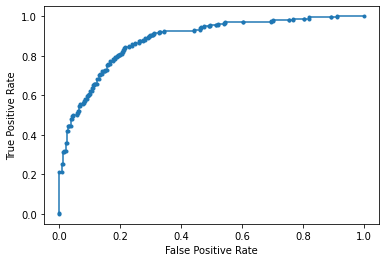

Accuracy: 81.49% Precision: 79.18% Recall: 92.22%
F1: 85.20% AUPRC: 90.91% AUROC: 88.16%
2023-02-06 19:34:51.115668
Fold 2
Model params (mean -0.20, wgt 0.65) (mean -1.38, wgt 0.35)
RCI threshold derived from training set: [-0.61539639]
FIT
2023-02-06 19:34:54.412992
Epoch 1/3
163/163 [==============================] - 3s 14ms/step - loss: 0.6838 - accuracy: 0.5718 - val_loss: 0.6543 - val_accuracy: 0.6384
Epoch 2/3
163/163 [==============================] - 2s 13ms/step - loss: 0.5995 - accuracy: 0.6665 - val_loss: 0.5527 - val_accuracy: 0.7215
Epoch 3/3
163/163 [==============================] - 2s 12ms/step - loss: 0.5007 - accuracy: 0.7580 - val_loss: 0.4938 - val_accuracy: 0.7595
PREDICT
2023-02-06 19:35:01.801037


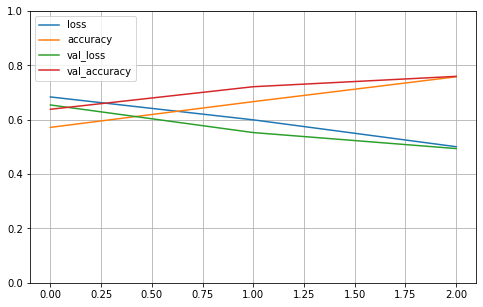

Train set ones/size 2979 / 5194
Compute valiation accuracy
Valid sizes (578, 4997) (578,)
Valid set ones/size 324 / 578
Range of scores: 0.006500099 to 0.99597126
Score threshold 0.5
Prediction set ones/size 341 / 578


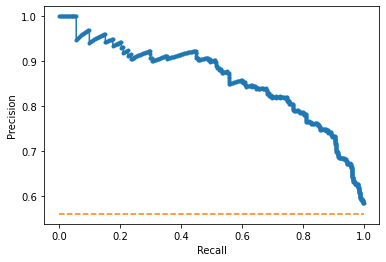

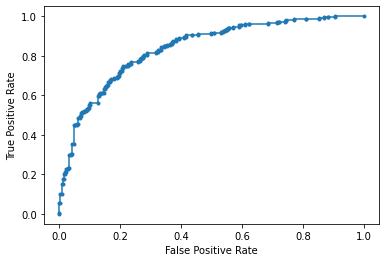

Accuracy: 75.95% Precision: 77.13% Recall: 81.17%
F1: 79.10% AUPRC: 86.05% AUROC: 83.85%
2023-02-06 19:35:02.564936
Fold 3
Model params (mean -0.30, wgt 0.78) (mean -1.73, wgt 0.22)
RCI threshold derived from training set: [-0.61436476]
FIT
2023-02-06 19:35:05.809734
Epoch 1/3
163/163 [==============================] - 3s 14ms/step - loss: 0.6846 - accuracy: 0.5619 - val_loss: 0.6526 - val_accuracy: 0.6395
Epoch 2/3
163/163 [==============================] - 2s 12ms/step - loss: 0.5886 - accuracy: 0.6878 - val_loss: 0.5367 - val_accuracy: 0.7314
Epoch 3/3
163/163 [==============================] - 2s 12ms/step - loss: 0.4536 - accuracy: 0.7948 - val_loss: 0.4901 - val_accuracy: 0.7608
PREDICT
2023-02-06 19:35:16.990664


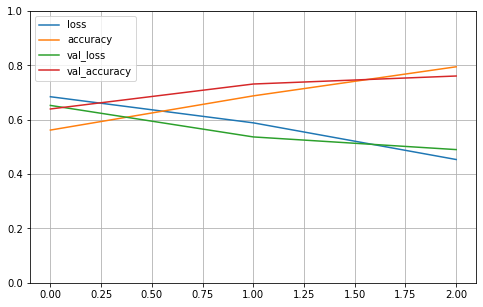

Train set ones/size 2976 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 326 / 577
Range of scores: 0.0038299067 to 0.999206
Score threshold 0.5
Prediction set ones/size 420 / 577


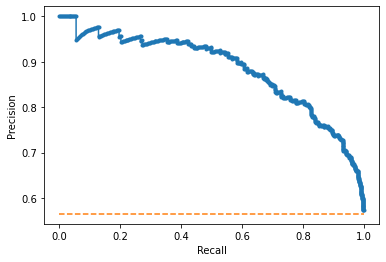

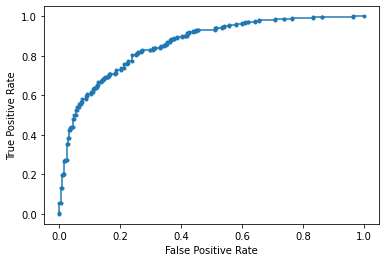

Accuracy: 76.08% Precision: 72.38% Recall: 93.25%
F1: 81.50% AUPRC: 88.44% AUROC: 86.03%
2023-02-06 19:35:17.644256
Fold 4
Model params (mean -0.20, wgt 0.64) (mean -1.37, wgt 0.36)
RCI threshold derived from training set: [-0.61850315]
FIT
2023-02-06 19:35:21.219197
Epoch 1/3
163/163 [==============================] - 3s 15ms/step - loss: 0.6792 - accuracy: 0.5827 - val_loss: 0.6142 - val_accuracy: 0.6863
Epoch 2/3
163/163 [==============================] - 2s 12ms/step - loss: 0.5845 - accuracy: 0.6909 - val_loss: 0.5171 - val_accuracy: 0.7366
Epoch 3/3
163/163 [==============================] - 2s 12ms/step - loss: 0.4737 - accuracy: 0.7782 - val_loss: 0.4888 - val_accuracy: 0.7435
PREDICT
2023-02-06 19:35:28.531292


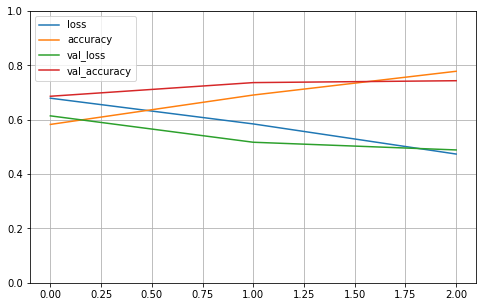

Train set ones/size 2970 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 334 / 577
Range of scores: 0.0032716498 to 0.9984445
Score threshold 0.5
Prediction set ones/size 414 / 577


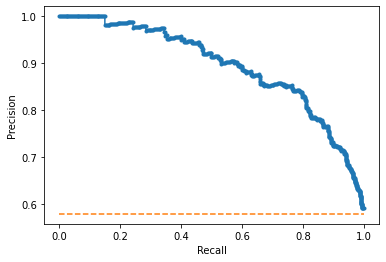

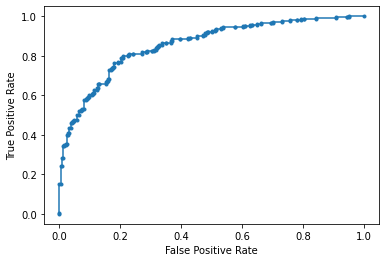

Accuracy: 74.35% Precision: 72.46% Recall: 89.82%
F1: 80.21% AUPRC: 89.51% AUROC: 85.61%
2023-02-06 19:35:29.326321
Fold 5
Model params (mean -0.20, wgt 0.65) (mean -1.37, wgt 0.35)
RCI threshold derived from training set: [-0.61355215]
FIT
2023-02-06 19:35:32.544366
Epoch 1/3
163/163 [==============================] - 3s 14ms/step - loss: 0.6789 - accuracy: 0.5771 - val_loss: 0.6527 - val_accuracy: 0.6568
Epoch 2/3
163/163 [==============================] - 2s 12ms/step - loss: 0.5782 - accuracy: 0.7022 - val_loss: 0.5392 - val_accuracy: 0.7210
Epoch 3/3
163/163 [==============================] - 2s 13ms/step - loss: 0.4611 - accuracy: 0.7777 - val_loss: 0.4844 - val_accuracy: 0.7643
PREDICT
2023-02-06 19:35:39.834966


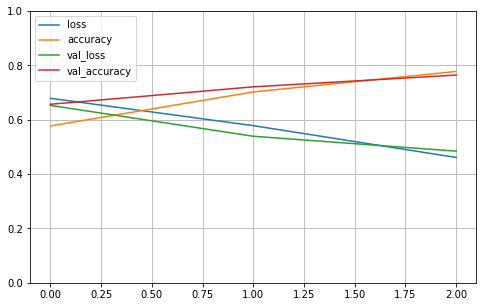

Train set ones/size 2978 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 314 / 577
Range of scores: 0.0029593683 to 0.99958485
Score threshold 0.5
Prediction set ones/size 376 / 577


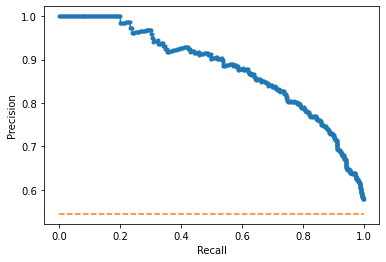

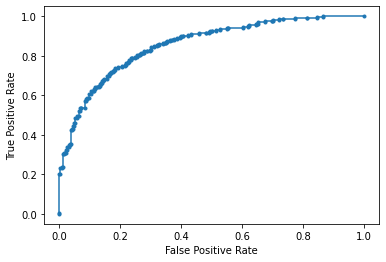

Accuracy: 76.43% Precision: 73.67% Recall: 88.22%
F1: 80.29% AUPRC: 87.99% AUROC: 85.63%
2023-02-06 19:35:40.652377
Fold 6
Model params (mean -1.36, wgt 0.36) (mean -0.19, wgt 0.64)
RCI threshold derived from training set: [-0.61201511]
FIT
2023-02-06 19:35:44.088900
Epoch 1/3
163/163 [==============================] - 3s 14ms/step - loss: 0.6784 - accuracy: 0.5856 - val_loss: 0.6314 - val_accuracy: 0.6603
Epoch 2/3
163/163 [==============================] - 2s 12ms/step - loss: 0.5732 - accuracy: 0.7045 - val_loss: 0.5095 - val_accuracy: 0.7504
Epoch 3/3
163/163 [==============================] - 2s 12ms/step - loss: 0.4823 - accuracy: 0.7721 - val_loss: 0.4662 - val_accuracy: 0.7747
PREDICT
2023-02-06 19:35:55.266546


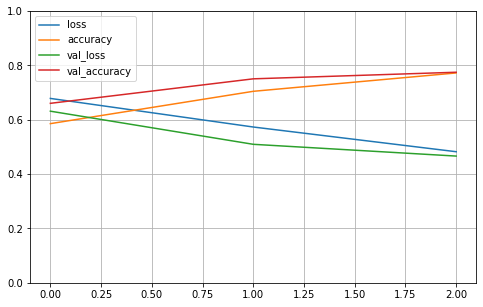

Train set ones/size 2974 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 318 / 577
Range of scores: 0.0371899 to 0.99788684
Score threshold 0.5
Prediction set ones/size 378 / 577


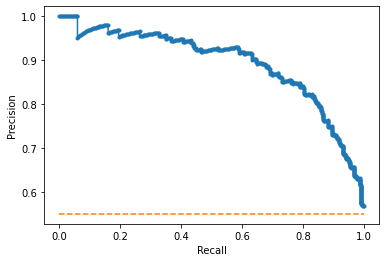

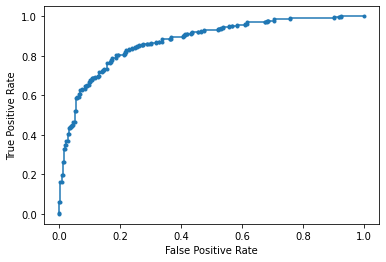

Accuracy: 77.47% Precision: 74.87% Recall: 88.99%
F1: 81.32% AUPRC: 89.39% AUROC: 87.45%
2023-02-06 19:35:55.920838
Fold 7
Model params (mean -0.31, wgt 0.78) (mean -1.74, wgt 0.22)
RCI threshold derived from training set: [-0.62265853]
FIT
2023-02-06 19:35:59.376611
Epoch 1/3
163/163 [==============================] - 3s 14ms/step - loss: 0.6754 - accuracy: 0.5927 - val_loss: 0.6332 - val_accuracy: 0.6499
Epoch 2/3
163/163 [==============================] - 2s 12ms/step - loss: 0.5882 - accuracy: 0.6866 - val_loss: 0.5259 - val_accuracy: 0.7418
Epoch 3/3
163/163 [==============================] - 2s 12ms/step - loss: 0.4847 - accuracy: 0.7767 - val_loss: 0.5029 - val_accuracy: 0.7487
PREDICT
2023-02-06 19:36:10.551922


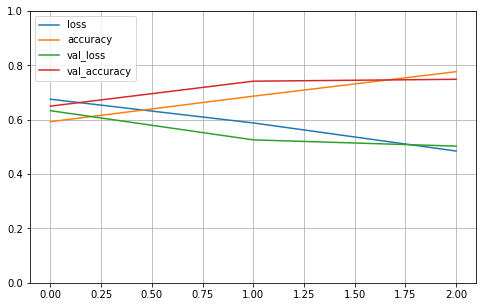

Train set ones/size 2978 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 327 / 577
Range of scores: 0.0025730075 to 0.9990145
Score threshold 0.5
Prediction set ones/size 440 / 577


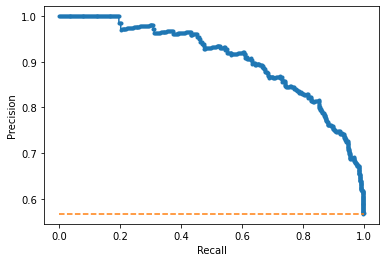

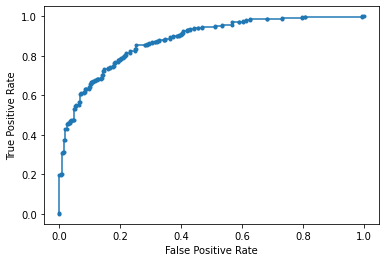

Accuracy: 74.87% Precision: 70.68% Recall: 95.11%
F1: 81.10% AUPRC: 90.63% AUROC: 87.91%
2023-02-06 19:36:11.257445
Fold 8
Model params (mean -0.33, wgt 0.79) (mean -1.72, wgt 0.21)
RCI threshold derived from training set: [-0.62641528]
FIT
2023-02-06 19:36:14.611223
Epoch 1/3
163/163 [==============================] - 3s 14ms/step - loss: 0.6882 - accuracy: 0.5596 - val_loss: 0.6596 - val_accuracy: 0.6049
Epoch 2/3
163/163 [==============================] - 2s 13ms/step - loss: 0.6226 - accuracy: 0.6512 - val_loss: 0.6023 - val_accuracy: 0.6568
Epoch 3/3
163/163 [==============================] - 2s 12ms/step - loss: 0.5148 - accuracy: 0.7461 - val_loss: 0.5022 - val_accuracy: 0.7608
PREDICT
2023-02-06 19:36:21.884871


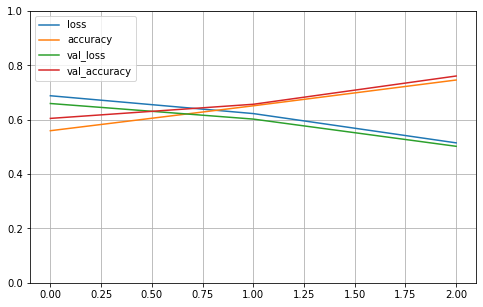

Train set ones/size 2957 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 348 / 577
Range of scores: 0.026588866 to 0.9948179
Score threshold 0.5
Prediction set ones/size 418 / 577


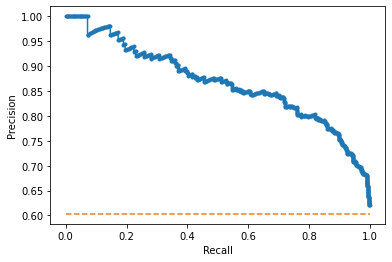

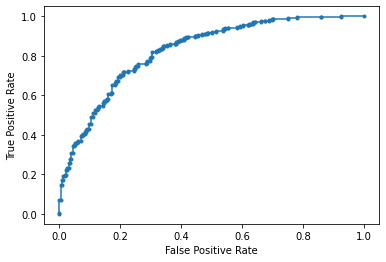

Accuracy: 76.08% Precision: 75.12% Recall: 90.23%
F1: 81.98% AUPRC: 86.75% AUROC: 82.63%
2023-02-06 19:36:22.680011
Fold 9
Model params (mean -0.31, wgt 0.78) (mean -1.74, wgt 0.22)
RCI threshold derived from training set: [-0.62739042]
FIT
2023-02-06 19:36:26.407237
Epoch 1/3
163/163 [==============================] - 3s 15ms/step - loss: 0.6874 - accuracy: 0.5588 - val_loss: 0.6538 - val_accuracy: 0.6135
Epoch 2/3
163/163 [==============================] - 2s 12ms/step - loss: 0.6222 - accuracy: 0.6572 - val_loss: 0.6031 - val_accuracy: 0.6863
Epoch 3/3
163/163 [==============================] - 2s 12ms/step - loss: 0.5018 - accuracy: 0.7584 - val_loss: 0.4789 - val_accuracy: 0.7747
PREDICT
2023-02-06 19:36:37.591176


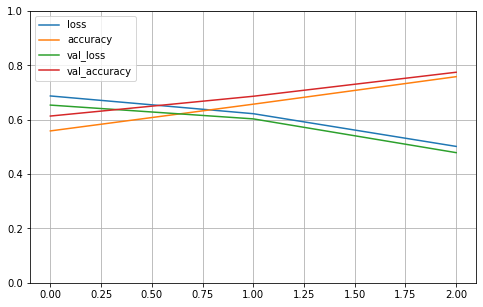

Train set ones/size 2965 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 340 / 577
Range of scores: 0.0003559252 to 0.9967668
Score threshold 0.5
Prediction set ones/size 414 / 577


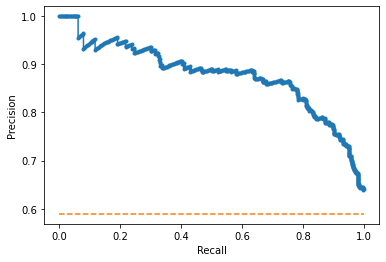

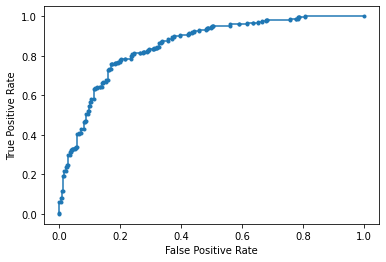

Accuracy: 77.47% Precision: 75.36% Recall: 91.76%
F1: 82.76% AUPRC: 87.77% AUROC: 85.24%
2023-02-06 19:36:38.297496
Fold 10
Model params (mean -0.19, wgt 0.64) (mean -1.37, wgt 0.36)
RCI threshold derived from training set: [-0.61302832]
FIT
2023-02-06 19:36:41.736271
Epoch 1/3
163/163 [==============================] - 3s 14ms/step - loss: 0.6889 - accuracy: 0.5671 - val_loss: 0.6525 - val_accuracy: 0.6153
Epoch 2/3
163/163 [==============================] - 2s 12ms/step - loss: 0.6042 - accuracy: 0.6755 - val_loss: 0.5612 - val_accuracy: 0.7088
Epoch 3/3
163/163 [==============================] - 2s 12ms/step - loss: 0.5276 - accuracy: 0.7434 - val_loss: 0.5449 - val_accuracy: 0.7331
PREDICT
2023-02-06 19:36:52.912521


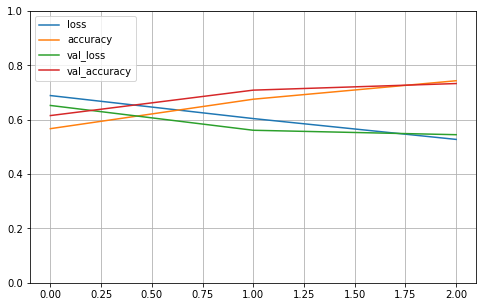

Train set ones/size 2958 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 334 / 577
Range of scores: 0.074540876 to 0.99674845
Score threshold 0.5
Prediction set ones/size 442 / 577


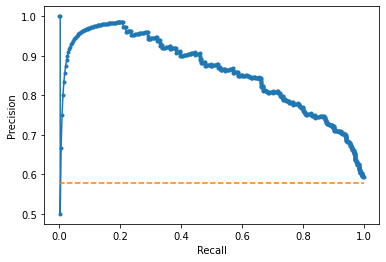

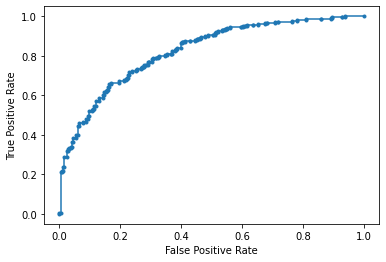

Accuracy: 73.31% Precision: 70.36% Recall: 93.11%
F1: 80.15% AUPRC: 85.77% AUROC: 82.34%
2023-02-06 19:36:53.625677

Completed cross validation 10 folds 3 epochs
 accuracy mean 76.35% +/- 2.23
 precision mean 74.12% +/- 2.78
 recall mean 90.39% +/- 3.87
 F1 mean 81.36% +/- 1.71
 AUPRC mean 88.32% +/- 1.80
 AUROC mean 85.48% +/- 2.05
Finished cell Line 10 SK.N.DZ

2023-02-06 19:36:54.991309
Start cell Line 11 SK.N.SH
Number of RCI values loaded 1647
Num RCI: 1647
Load sequence...
Cross validation...
2023-02-06 19:37:08.595786
splitting
Fold 1
Model params (mean -0.15, wgt 0.53) (mean -1.87, wgt 0.47)
RCI threshold derived from training set: [-0.96253589]
FIT
2023-02-06 19:37:11.792498
Epoch 1/3
291/291 [==============================] - 5s 14ms/step - loss: 0.6733 - accuracy: 0.5678 - val_loss: 0.6020 - val_accuracy: 0.6538
Epoch 2/3
291/291 [==============================] - 4s 12ms/step - loss: 0.5831 - accuracy: 0.6972 - val_loss: 0.5294 - val_accuracy: 0.7244
Epoch 3/3
291/291 [====

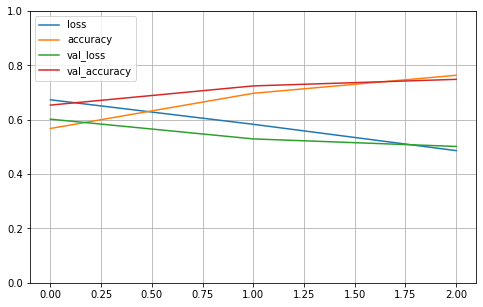

Train set ones/size 4791 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 542 / 1034
Range of scores: 0.0030820891 to 0.9970311
Score threshold 0.5
Prediction set ones/size 486 / 1034


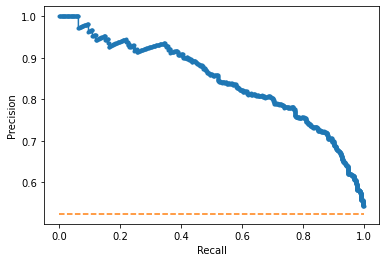

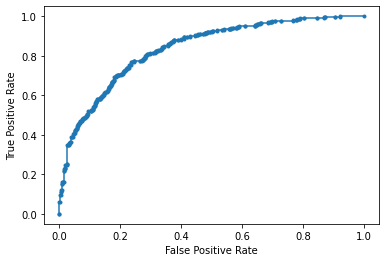

Accuracy: 74.85% Precision: 79.01% Recall: 70.85%
F1: 74.71% AUPRC: 84.57% AUROC: 83.70%
2023-02-06 19:37:34.377318
Fold 2
Model params (mean -1.89, wgt 0.47) (mean -0.13, wgt 0.53)
RCI threshold derived from training set: [-0.95906214]
FIT
2023-02-06 19:37:38.977068
Epoch 1/3
291/291 [==============================] - 5s 14ms/step - loss: 0.6870 - accuracy: 0.5510 - val_loss: 0.6358 - val_accuracy: 0.6354
Epoch 2/3
291/291 [==============================] - 4s 12ms/step - loss: 0.6107 - accuracy: 0.6613 - val_loss: 0.6276 - val_accuracy: 0.6499
Epoch 3/3
291/291 [==============================] - 4s 12ms/step - loss: 0.5429 - accuracy: 0.7217 - val_loss: 0.5570 - val_accuracy: 0.6992
PREDICT
2023-02-06 19:38:00.659374


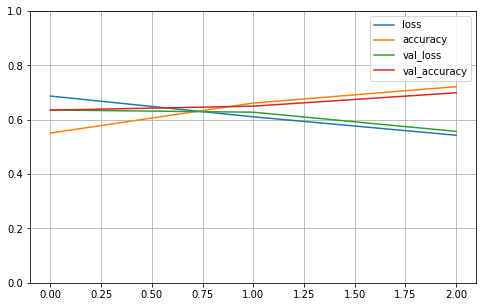

Train set ones/size 4809 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 524 / 1034
Range of scores: 0.0077688205 to 0.9954448
Score threshold 0.5
Prediction set ones/size 747 / 1034


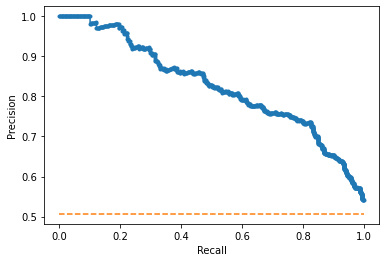

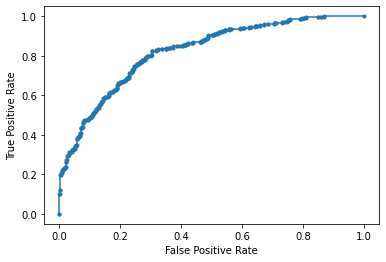

Accuracy: 69.92% Precision: 64.26% Recall: 91.60%
F1: 75.53% AUPRC: 82.72% AUROC: 82.22%
2023-02-06 19:38:01.387505
Fold 3
Model params (mean -0.13, wgt 0.52) (mean -1.87, wgt 0.48)
RCI threshold derived from training set: [-0.96215598]
FIT
2023-02-06 19:38:05.915903
Epoch 1/3
291/291 [==============================] - 4s 13ms/step - loss: 0.6810 - accuracy: 0.5632 - val_loss: 0.6294 - val_accuracy: 0.6480
Epoch 2/3
291/291 [==============================] - 4s 12ms/step - loss: 0.5890 - accuracy: 0.6852 - val_loss: 0.5509 - val_accuracy: 0.7302
Epoch 3/3
291/291 [==============================] - 4s 12ms/step - loss: 0.5089 - accuracy: 0.7505 - val_loss: 0.5538 - val_accuracy: 0.7099
PREDICT
2023-02-06 19:38:18.247625


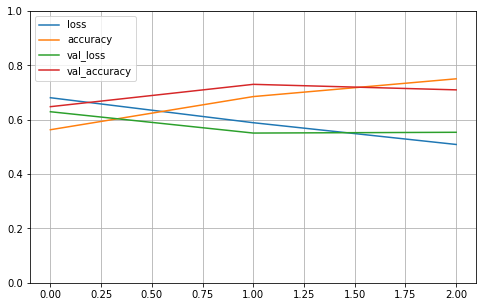

Train set ones/size 4773 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 560 / 1034
Range of scores: 0.010503176 to 0.9972178
Score threshold 0.5
Prediction set ones/size 496 / 1034


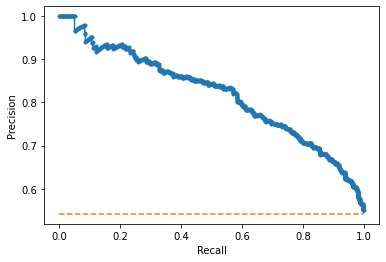

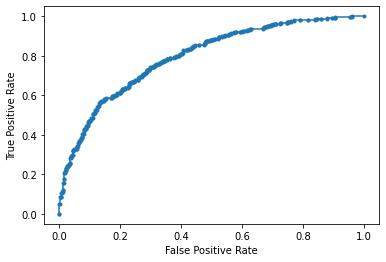

Accuracy: 70.99% Precision: 76.21% Recall: 67.50%
F1: 71.59% AUPRC: 81.92% AUROC: 79.64%
2023-02-06 19:38:19.112614
Fold 4
Model params (mean -1.89, wgt 0.48) (mean -0.11, wgt 0.52)
RCI threshold derived from training set: [-0.95819108]
FIT
2023-02-06 19:38:24.292397
Epoch 1/3
291/291 [==============================] - 5s 14ms/step - loss: 0.6880 - accuracy: 0.5442 - val_loss: 0.6305 - val_accuracy: 0.6528
Epoch 2/3
291/291 [==============================] - 4s 12ms/step - loss: 0.6050 - accuracy: 0.6719 - val_loss: 0.5831 - val_accuracy: 0.6925
Epoch 3/3
291/291 [==============================] - 3s 12ms/step - loss: 0.5297 - accuracy: 0.7369 - val_loss: 0.5513 - val_accuracy: 0.7195
PREDICT
2023-02-06 19:38:36.493287


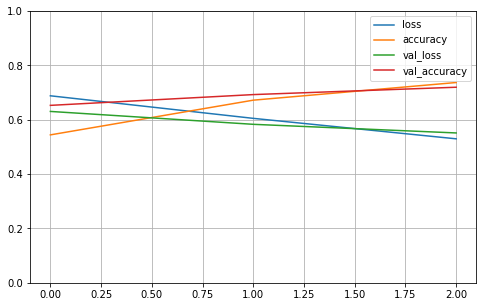

Train set ones/size 4790 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 543 / 1034
Range of scores: 0.005152586 to 0.9890928
Score threshold 0.5
Prediction set ones/size 483 / 1034


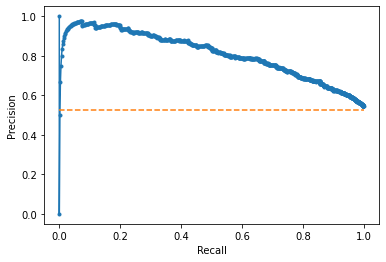

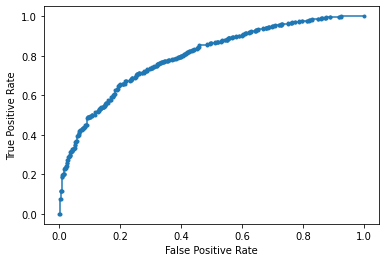

Accuracy: 71.95% Precision: 76.19% Recall: 67.77%
F1: 71.73% AUPRC: 81.02% AUROC: 79.55%
2023-02-06 19:38:37.531125
Fold 5
Model params (mean -1.90, wgt 0.48) (mean -0.11, wgt 0.52)
RCI threshold derived from training set: [-0.96284171]
FIT
2023-02-06 19:38:42.554086
Epoch 1/3
291/291 [==============================] - 5s 14ms/step - loss: 0.6895 - accuracy: 0.5460 - val_loss: 0.6479 - val_accuracy: 0.6422
Epoch 2/3
291/291 [==============================] - 4s 13ms/step - loss: 0.6231 - accuracy: 0.6531 - val_loss: 0.5785 - val_accuracy: 0.6779
Epoch 3/3
291/291 [==============================] - 3s 12ms/step - loss: 0.5544 - accuracy: 0.7145 - val_loss: 0.5464 - val_accuracy: 0.7137
PREDICT
2023-02-06 19:38:54.989786


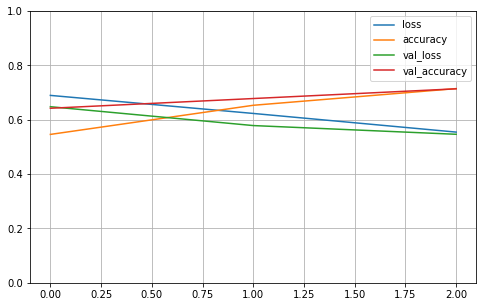

Train set ones/size 4792 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 541 / 1034
Range of scores: 0.018542528 to 0.96969855
Score threshold 0.5
Prediction set ones/size 499 / 1034


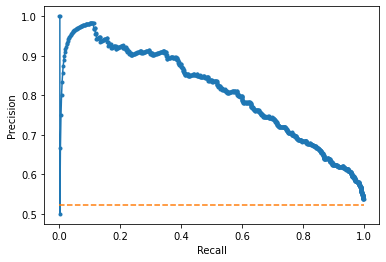

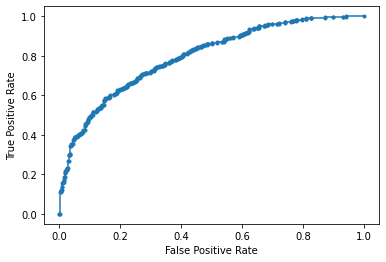

Accuracy: 71.37% Precision: 74.55% Recall: 68.76%
F1: 71.54% AUPRC: 80.89% AUROC: 79.50%
2023-02-06 19:38:56.093679
Fold 6
Model params (mean -1.88, wgt 0.47) (mean -0.14, wgt 0.53)
RCI threshold derived from training set: [-0.95951129]
FIT
2023-02-06 19:39:00.698324
Epoch 1/3
291/291 [==============================] - 5s 14ms/step - loss: 0.6871 - accuracy: 0.5468 - val_loss: 0.6584 - val_accuracy: 0.5841
Epoch 2/3
291/291 [==============================] - 4s 12ms/step - loss: 0.6059 - accuracy: 0.6705 - val_loss: 0.5923 - val_accuracy: 0.6567
Epoch 3/3
291/291 [==============================] - 4s 12ms/step - loss: 0.5198 - accuracy: 0.7391 - val_loss: 0.5382 - val_accuracy: 0.7224
PREDICT
2023-02-06 19:39:13.061442


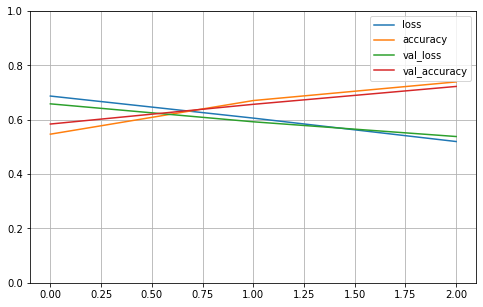

Train set ones/size 4793 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 540 / 1034
Range of scores: 0.0040863072 to 0.99705744
Score threshold 0.5
Prediction set ones/size 697 / 1034


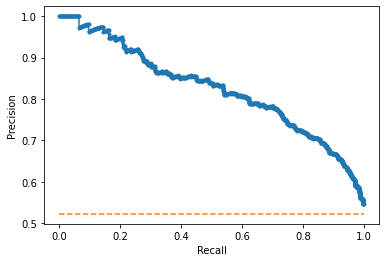

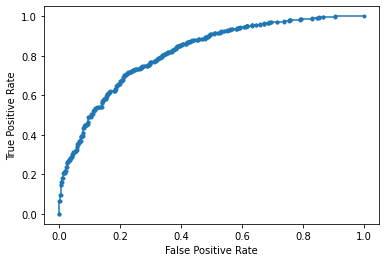

Accuracy: 72.24% Precision: 68.15% Recall: 87.96%
F1: 76.80% AUPRC: 82.51% AUROC: 81.67%
2023-02-06 19:39:14.085287
Fold 7
Model params (mean -0.15, wgt 0.53) (mean -1.88, wgt 0.47)
RCI threshold derived from training set: [-0.96010359]
FIT
2023-02-06 19:39:18.932809
Epoch 1/3
291/291 [==============================] - 4s 13ms/step - loss: 0.6903 - accuracy: 0.5375 - val_loss: 0.6399 - val_accuracy: 0.6451
Epoch 2/3
291/291 [==============================] - 4s 12ms/step - loss: 0.6062 - accuracy: 0.6688 - val_loss: 0.5653 - val_accuracy: 0.7002
Epoch 3/3
291/291 [==============================] - 4s 13ms/step - loss: 0.5253 - accuracy: 0.7361 - val_loss: 0.5353 - val_accuracy: 0.7331
PREDICT
2023-02-06 19:39:31.256764


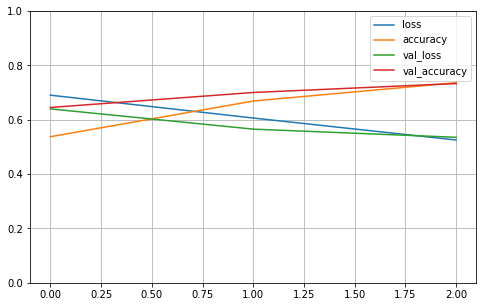

Train set ones/size 4806 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 527 / 1034
Range of scores: 0.003192996 to 0.9970681
Score threshold 0.5
Prediction set ones/size 495 / 1034


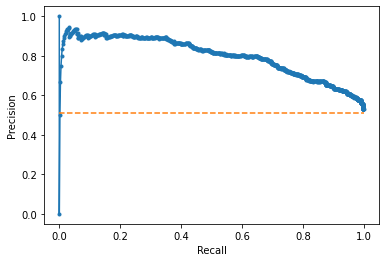

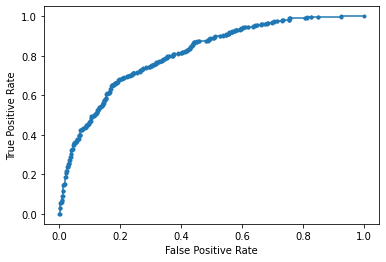

Accuracy: 73.31% Precision: 75.35% Recall: 70.78%
F1: 72.99% AUPRC: 79.96% AUROC: 81.00%
2023-02-06 19:39:32.129538
Fold 8
Model params (mean -0.13, wgt 0.53) (mean -1.86, wgt 0.47)
RCI threshold derived from training set: [-0.94421167]
FIT
2023-02-06 19:39:36.901731
Epoch 1/3
291/291 [==============================] - 5s 14ms/step - loss: 0.6883 - accuracy: 0.5473 - val_loss: 0.6398 - val_accuracy: 0.6263
Epoch 2/3
291/291 [==============================] - 4s 12ms/step - loss: 0.6278 - accuracy: 0.6397 - val_loss: 0.6113 - val_accuracy: 0.6709
Epoch 3/3
291/291 [==============================] - 4s 12ms/step - loss: 0.5348 - accuracy: 0.7303 - val_loss: 0.5613 - val_accuracy: 0.7096
PREDICT
2023-02-06 19:39:58.585482


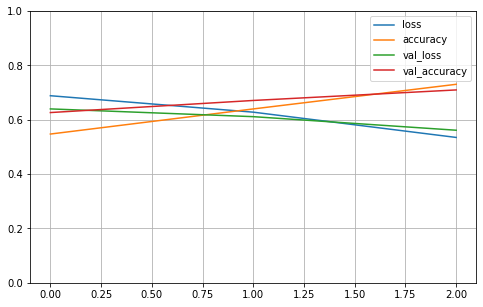

Train set ones/size 4799 / 9304
Compute valiation accuracy
Valid sizes (1033, 4997) (1033,)
Valid set ones/size 517 / 1033
Range of scores: 0.004697623 to 0.98882294
Score threshold 0.5
Prediction set ones/size 599 / 1033


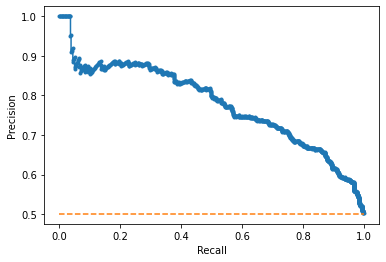

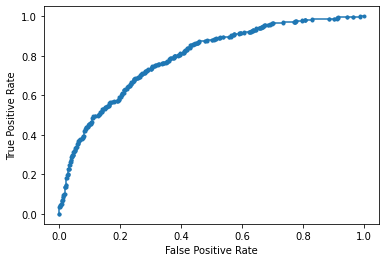

Accuracy: 70.96% Precision: 68.11% Recall: 78.92%
F1: 73.12% AUPRC: 78.00% AUROC: 79.08%
2023-02-06 19:39:59.452038
Fold 9
Model params (mean -0.15, wgt 0.53) (mean -1.87, wgt 0.47)
RCI threshold derived from training set: [-0.96037169]
FIT
2023-02-06 19:40:04.185161
Epoch 1/3
291/291 [==============================] - 5s 14ms/step - loss: 0.6861 - accuracy: 0.5455 - val_loss: 0.6537 - val_accuracy: 0.6147
Epoch 2/3
291/291 [==============================] - 3s 12ms/step - loss: 0.6131 - accuracy: 0.6619 - val_loss: 0.5611 - val_accuracy: 0.7067
Epoch 3/3
291/291 [==============================] - 4s 12ms/step - loss: 0.5286 - accuracy: 0.7334 - val_loss: 0.5638 - val_accuracy: 0.7038
PREDICT
2023-02-06 19:40:16.534862


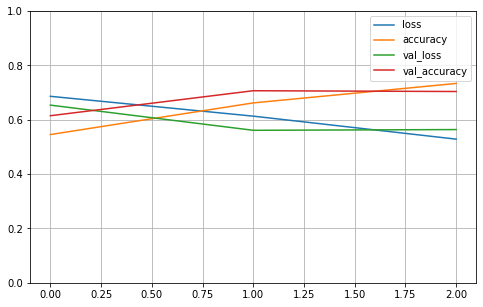

Train set ones/size 4799 / 9304
Compute valiation accuracy
Valid sizes (1033, 4997) (1033,)
Valid set ones/size 534 / 1033
Range of scores: 0.007941033 to 0.9876744
Score threshold 0.5
Prediction set ones/size 390 / 1033


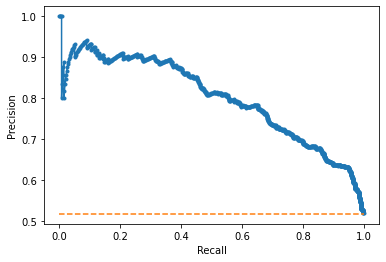

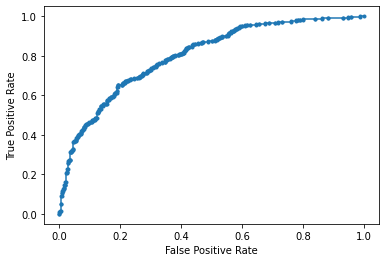

Accuracy: 70.38% Precision: 79.23% Recall: 57.87%
F1: 66.88% AUPRC: 80.04% AUROC: 80.09%
2023-02-06 19:40:17.444704
Fold 10
Model params (mean -0.11, wgt 0.53) (mean -1.88, wgt 0.47)
RCI threshold derived from training set: [-0.9432121]
FIT
2023-02-06 19:40:22.285330
Epoch 1/3
291/291 [==============================] - 5s 14ms/step - loss: 0.6817 - accuracy: 0.5612 - val_loss: 0.6370 - val_accuracy: 0.6534
Epoch 2/3
291/291 [==============================] - 4s 12ms/step - loss: 0.6092 - accuracy: 0.6638 - val_loss: 0.6726 - val_accuracy: 0.5954
Epoch 3/3
291/291 [==============================] - 4s 13ms/step - loss: 0.5191 - accuracy: 0.7404 - val_loss: 0.5720 - val_accuracy: 0.6951
PREDICT
2023-02-06 19:40:43.993051


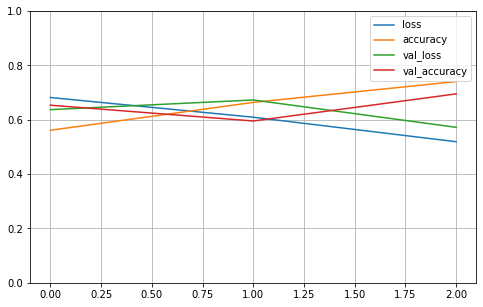

Train set ones/size 4814 / 9304
Compute valiation accuracy
Valid sizes (1033, 4997) (1033,)
Valid set ones/size 502 / 1033
Range of scores: 0.00047144757 to 0.98167115
Score threshold 0.5
Prediction set ones/size 393 / 1033


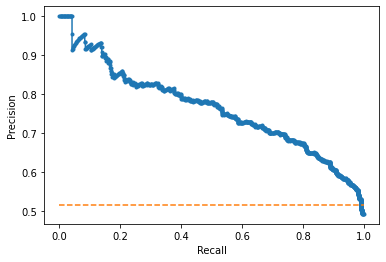

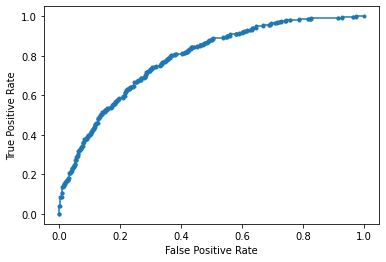

Accuracy: 69.51% Precision: 73.79% Recall: 57.77%
F1: 64.80% AUPRC: 76.42% AUROC: 78.49%
2023-02-06 19:40:44.729647

Completed cross validation 10 folds 3 epochs
 accuracy mean 71.55% +/- 1.62
 precision mean 73.49% +/- 5.01
 recall mean 71.98% +/- 11.26
 F1 mean 71.97% +/- 3.70
 AUPRC mean 80.80% +/- 2.37
 AUROC mean 80.49% +/- 1.62
Finished cell Line 11 SK.N.SH

2023-02-06 19:40:46.196451
Start cell Line 12 GM12878
Number of RCI values loaded 1698
Num RCI: 1698
Load sequence...
Cross validation...
2023-02-06 19:40:59.362864
splitting
Fold 1
Model params (mean -0.19, wgt 0.48) (mean -1.35, wgt 0.52)
RCI threshold derived from training set: [-0.7917608]
FIT
2023-02-06 19:41:02.871215
Epoch 1/3
276/276 [==============================] - 4s 14ms/step - loss: 0.6907 - accuracy: 0.5439 - val_loss: 0.6328 - val_accuracy: 0.6565
Epoch 2/3
276/276 [==============================] - 3s 12ms/step - loss: 0.5928 - accuracy: 0.6816 - val_loss: 0.5557 - val_accuracy: 0.7074
Epoch 3/3
276/276 [====

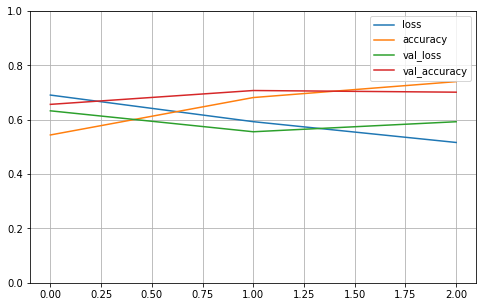

Train set ones/size 4450 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 528 / 981
Range of scores: 0.0023777685 to 0.99324715
Score threshold 0.5
Prediction set ones/size 295 / 981


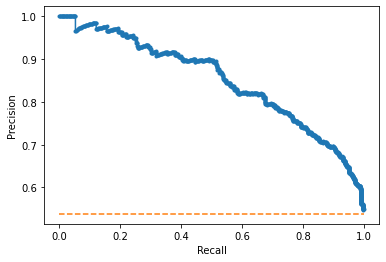

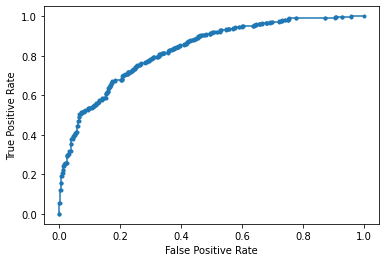

Accuracy: 70.13% Precision: 89.83% Recall: 50.19%
F1: 64.40% AUPRC: 85.04% AUROC: 82.96%
2023-02-06 19:41:25.451392
Fold 2
Model params (mean -0.14, wgt 0.47) (mean -1.37, wgt 0.53)
RCI threshold derived from training set: [-0.78480961]
FIT
2023-02-06 19:41:30.320656
Epoch 1/3
276/276 [==============================] - 4s 14ms/step - loss: 0.6965 - accuracy: 0.5106 - val_loss: 0.6706 - val_accuracy: 0.5749
Epoch 2/3
276/276 [==============================] - 3s 13ms/step - loss: 0.6098 - accuracy: 0.6633 - val_loss: 0.5793 - val_accuracy: 0.6952
Epoch 3/3
276/276 [==============================] - 3s 13ms/step - loss: 0.5061 - accuracy: 0.7525 - val_loss: 0.5336 - val_accuracy: 0.7105
PREDICT
2023-02-06 19:41:42.329613


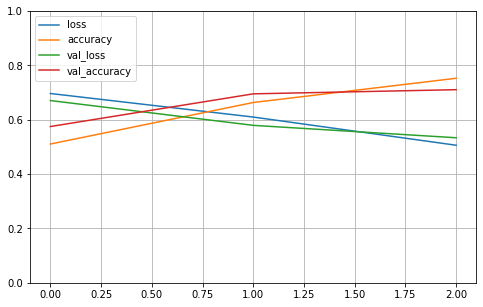

Train set ones/size 4476 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 496 / 981
Range of scores: 0.0011550109 to 0.99712545
Score threshold 0.5
Prediction set ones/size 390 / 981


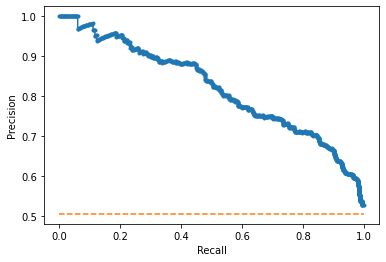

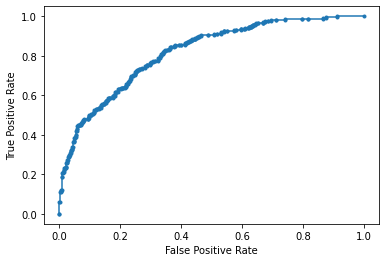

Accuracy: 71.05% Precision: 77.18% Recall: 60.69%
F1: 67.95% AUPRC: 82.06% AUROC: 81.78%
2023-02-06 19:41:43.239355
Fold 3
Model params (mean -0.20, wgt 0.48) (mean -1.34, wgt 0.52)
RCI threshold derived from training set: [-0.79324266]
FIT
2023-02-06 19:41:48.366112
Epoch 1/3
276/276 [==============================] - 4s 14ms/step - loss: 0.6926 - accuracy: 0.5364 - val_loss: 0.6467 - val_accuracy: 0.6198
Epoch 2/3
276/276 [==============================] - 3s 12ms/step - loss: 0.5805 - accuracy: 0.6922 - val_loss: 0.5722 - val_accuracy: 0.7064
Epoch 3/3
276/276 [==============================] - 3s 12ms/step - loss: 0.4861 - accuracy: 0.7603 - val_loss: 0.5432 - val_accuracy: 0.7207
PREDICT
2023-02-06 19:42:00.150867


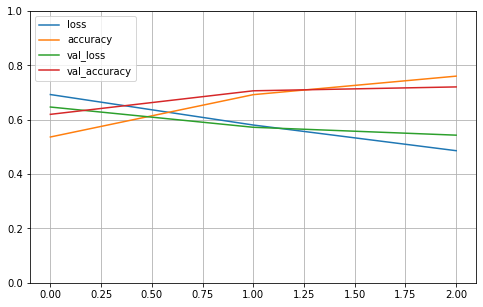

Train set ones/size 4464 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 514 / 981
Range of scores: 0.0018610469 to 0.9905428
Score threshold 0.5
Prediction set ones/size 348 / 981


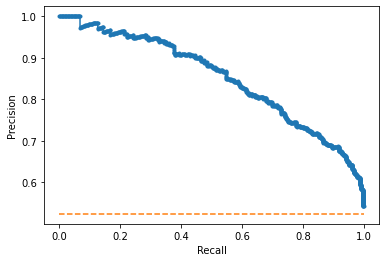

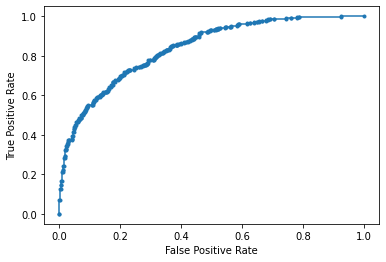

Accuracy: 72.07% Precision: 84.48% Recall: 57.20%
F1: 68.21% AUPRC: 85.20% AUROC: 83.85%
2023-02-06 19:42:01.065756
Fold 4
Model params (mean -0.19, wgt 0.48) (mean -1.33, wgt 0.52)
RCI threshold derived from training set: [-0.77878532]
FIT
2023-02-06 19:42:05.667323
Epoch 1/3
276/276 [==============================] - 4s 14ms/step - loss: 0.6944 - accuracy: 0.5354 - val_loss: 0.6673 - val_accuracy: 0.5892
Epoch 2/3
276/276 [==============================] - 3s 12ms/step - loss: 0.6261 - accuracy: 0.6458 - val_loss: 0.5778 - val_accuracy: 0.7013
Epoch 3/3
276/276 [==============================] - 3s 13ms/step - loss: 0.5353 - accuracy: 0.7262 - val_loss: 0.5425 - val_accuracy: 0.7278
PREDICT
2023-02-06 19:42:27.313211


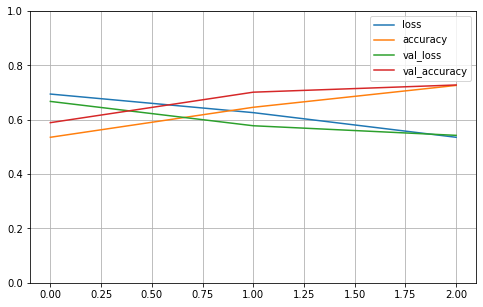

Train set ones/size 4487 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 475 / 981
Range of scores: 0.009477782 to 0.99176157
Score threshold 0.5
Prediction set ones/size 344 / 981


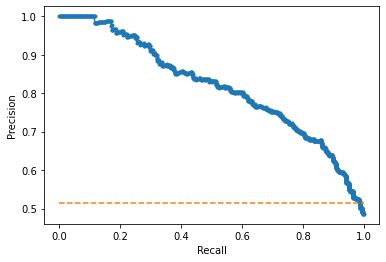

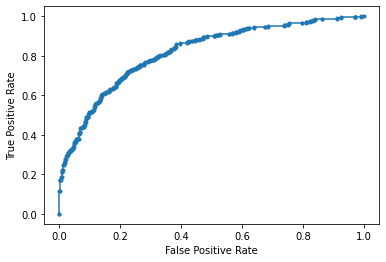

Accuracy: 72.78% Precision: 80.23% Recall: 58.11%
F1: 67.40% AUPRC: 81.78% AUROC: 81.75%
2023-02-06 19:42:28.108507
Fold 5
Model params (mean -0.13, wgt 0.47) (mean -1.37, wgt 0.53)
RCI threshold derived from training set: [-0.7845497]
FIT
2023-02-06 19:42:32.730387
Epoch 1/3
276/276 [==============================] - 4s 14ms/step - loss: 0.6936 - accuracy: 0.5392 - val_loss: 0.6488 - val_accuracy: 0.6290
Epoch 2/3
276/276 [==============================] - 3s 12ms/step - loss: 0.6130 - accuracy: 0.6627 - val_loss: 0.6133 - val_accuracy: 0.6585
Epoch 3/3
276/276 [==============================] - 3s 13ms/step - loss: 0.5190 - accuracy: 0.7398 - val_loss: 0.5181 - val_accuracy: 0.7492
PREDICT
2023-02-06 19:42:44.588339


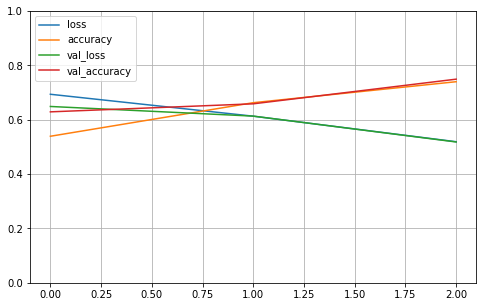

Train set ones/size 4472 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 500 / 981
Range of scores: 0.005577915 to 0.99744034
Score threshold 0.5
Prediction set ones/size 422 / 981


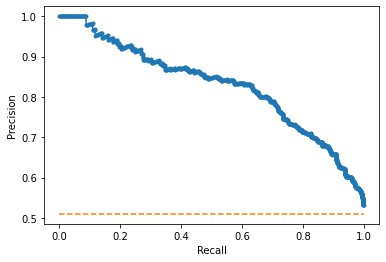

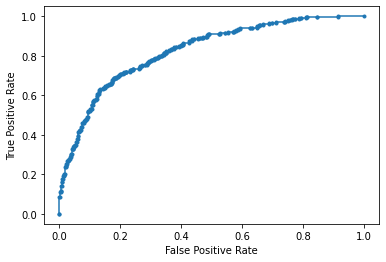

Accuracy: 74.92% Precision: 80.09% Recall: 67.60%
F1: 73.32% AUPRC: 82.90% AUROC: 82.50%
2023-02-06 19:42:45.491179
Fold 6
Model params (mean -0.20, wgt 0.48) (mean -1.34, wgt 0.52)
RCI threshold derived from training set: [-0.79197716]
FIT
2023-02-06 19:42:50.098541
Epoch 1/3
276/276 [==============================] - 4s 14ms/step - loss: 0.6750 - accuracy: 0.5646 - val_loss: 0.6256 - val_accuracy: 0.6514
Epoch 2/3
276/276 [==============================] - 4s 13ms/step - loss: 0.5939 - accuracy: 0.6811 - val_loss: 0.5513 - val_accuracy: 0.7238
Epoch 3/3
276/276 [==============================] - 3s 13ms/step - loss: 0.5124 - accuracy: 0.7423 - val_loss: 0.6290 - val_accuracy: 0.6758
PREDICT
2023-02-06 19:43:02.074364


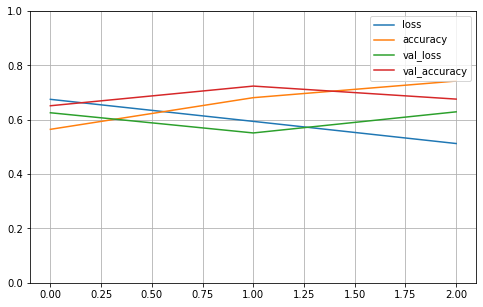

Train set ones/size 4463 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 515 / 981
Range of scores: 0.004980523 to 0.99060434
Score threshold 0.5
Prediction set ones/size 241 / 981


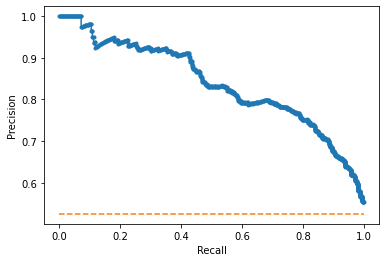

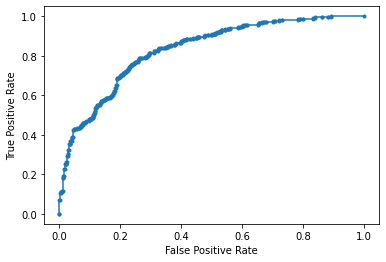

Accuracy: 67.58% Precision: 90.87% Recall: 42.52%
F1: 57.94% AUPRC: 83.92% AUROC: 83.00%
2023-02-06 19:43:02.967070
Fold 7
Model params (mean -0.21, wgt 0.49) (mean -1.33, wgt 0.51)
RCI threshold derived from training set: [-0.78209425]
FIT
2023-02-06 19:43:07.573233
Epoch 1/3
276/276 [==============================] - 4s 14ms/step - loss: 0.6903 - accuracy: 0.5412 - val_loss: 0.6235 - val_accuracy: 0.6490
Epoch 2/3
276/276 [==============================] - 3s 12ms/step - loss: 0.6082 - accuracy: 0.6656 - val_loss: 0.6334 - val_accuracy: 0.6184
Epoch 3/3
276/276 [==============================] - 4s 13ms/step - loss: 0.5320 - accuracy: 0.7373 - val_loss: 0.6001 - val_accuracy: 0.6694
PREDICT
2023-02-06 19:43:19.567673


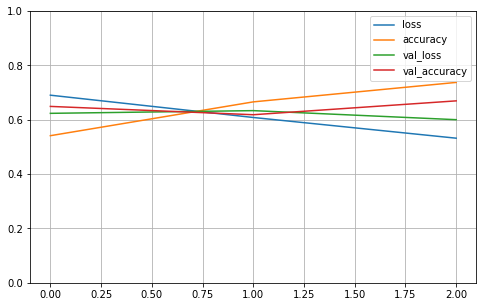

Train set ones/size 4495 / 8826
Compute valiation accuracy
Valid sizes (980, 4997) (980,)
Valid set ones/size 477 / 980
Range of scores: 0.019306796 to 0.9952414
Score threshold 0.5
Prediction set ones/size 701 / 980


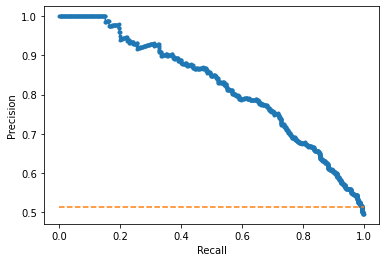

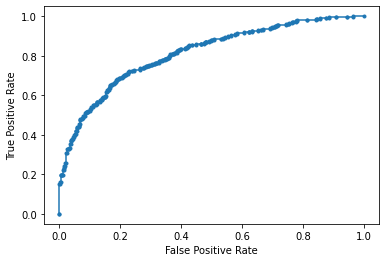

Accuracy: 66.94% Precision: 60.91% Recall: 89.52%
F1: 72.50% AUPRC: 82.10% AUROC: 81.33%
2023-02-06 19:43:20.465366
Fold 8
Model params (mean -0.12, wgt 0.47) (mean -1.36, wgt 0.53)
RCI threshold derived from training set: [-0.77336339]
FIT
2023-02-06 19:43:25.162507
Epoch 1/3
276/276 [==============================] - 4s 14ms/step - loss: 0.6951 - accuracy: 0.5313 - val_loss: 0.6693 - val_accuracy: 0.5969
Epoch 2/3
276/276 [==============================] - 3s 12ms/step - loss: 0.6087 - accuracy: 0.6672 - val_loss: 0.5619 - val_accuracy: 0.6949
Epoch 3/3
276/276 [==============================] - 3s 12ms/step - loss: 0.5198 - accuracy: 0.7404 - val_loss: 0.5433 - val_accuracy: 0.7235
PREDICT
2023-02-06 19:43:46.805777


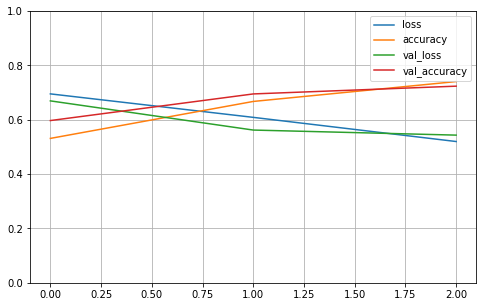

Train set ones/size 4495 / 8826
Compute valiation accuracy
Valid sizes (980, 4997) (980,)
Valid set ones/size 459 / 980
Range of scores: 0.0037864305 to 0.9945802
Score threshold 0.5
Prediction set ones/size 358 / 980


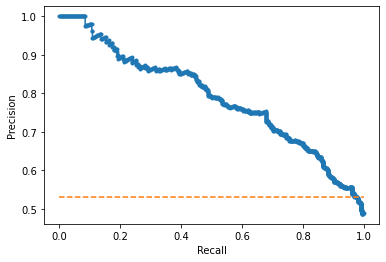

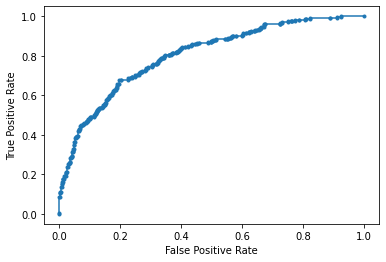

Accuracy: 72.35% Precision: 76.26% Recall: 59.48%
F1: 66.83% AUPRC: 78.83% AUROC: 80.36%
2023-02-06 19:43:47.559322
Fold 9
Model params (mean -1.34, wgt 0.52) (mean -0.19, wgt 0.48)
RCI threshold derived from training set: [-0.78899358]
FIT
2023-02-06 19:43:52.708699
Epoch 1/3
276/276 [==============================] - 4s 14ms/step - loss: 0.6867 - accuracy: 0.5440 - val_loss: 0.6368 - val_accuracy: 0.6469
Epoch 2/3
276/276 [==============================] - 3s 12ms/step - loss: 0.6074 - accuracy: 0.6669 - val_loss: 0.6452 - val_accuracy: 0.6347
Epoch 3/3
276/276 [==============================] - 3s 12ms/step - loss: 0.5321 - accuracy: 0.7326 - val_loss: 0.5480 - val_accuracy: 0.7204
PREDICT
2023-02-06 19:44:14.418027


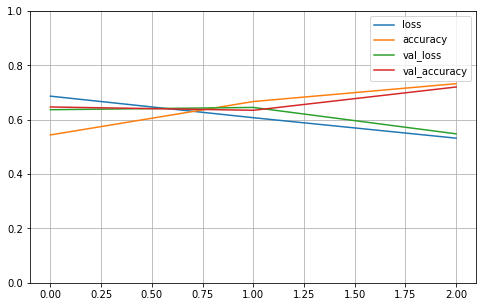

Train set ones/size 4471 / 8826
Compute valiation accuracy
Valid sizes (980, 4997) (980,)
Valid set ones/size 502 / 980
Range of scores: 0.01089858 to 0.99246174
Score threshold 0.5
Prediction set ones/size 616 / 980


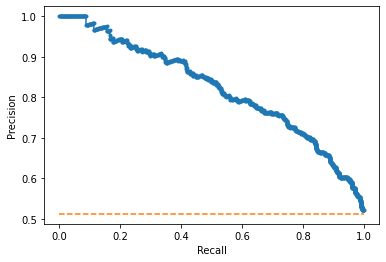

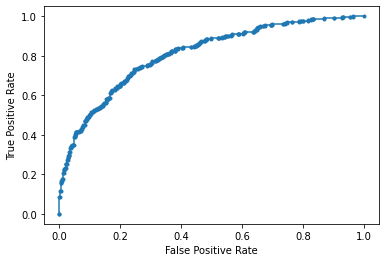

Accuracy: 72.04% Precision: 68.51% Recall: 84.06%
F1: 75.49% AUPRC: 82.22% AUROC: 80.89%
2023-02-06 19:44:15.165952
Fold 10
Model params (mean -0.19, wgt 0.48) (mean -1.35, wgt 0.52)
RCI threshold derived from training set: [-0.79121817]
FIT
2023-02-06 19:44:20.050661
Epoch 1/3
276/276 [==============================] - 4s 14ms/step - loss: 0.6708 - accuracy: 0.5743 - val_loss: 0.6027 - val_accuracy: 0.6765
Epoch 2/3
276/276 [==============================] - 3s 12ms/step - loss: 0.5901 - accuracy: 0.6854 - val_loss: 0.5471 - val_accuracy: 0.7163
Epoch 3/3
276/276 [==============================] - 3s 12ms/step - loss: 0.5232 - accuracy: 0.7390 - val_loss: 0.5360 - val_accuracy: 0.7480
PREDICT
2023-02-06 19:44:31.889331


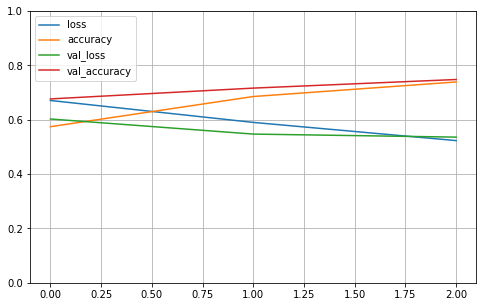

Train set ones/size 4471 / 8826
Compute valiation accuracy
Valid sizes (980, 4997) (980,)
Valid set ones/size 506 / 980
Range of scores: 0.011845003 to 0.9935539
Score threshold 0.5
Prediction set ones/size 411 / 980


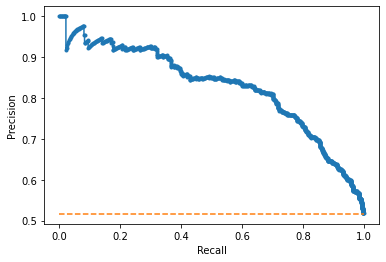

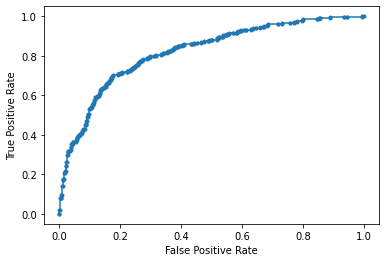

Accuracy: 74.80% Precision: 81.51% Recall: 66.21%
F1: 73.06% AUPRC: 82.77% AUROC: 82.08%
2023-02-06 19:44:32.839678

Completed cross validation 10 folds 3 epochs
 accuracy mean 71.47% +/- 2.66
 precision mean 78.99% +/- 9.10
 recall mean 63.56% +/- 14.27
 F1 mean 68.71% +/- 5.18
 AUPRC mean 82.68% +/- 1.83
 AUROC mean 82.05% +/- 1.06
Finished cell Line 12 GM12878

2023-02-06 19:44:34.405466
Start cell Line 13 K562
Number of RCI values loaded 958
Num RCI: 958
Load sequence...
Cross validation...
2023-02-06 19:44:42.947732
splitting
Fold 1
Model params (mean 0.02, wgt 0.63) (mean -1.87, wgt 0.37)
RCI threshold derived from training set: [-0.67130873]
FIT
2023-02-06 19:44:45.047606
Epoch 1/3
177/177 [==============================] - 3s 14ms/step - loss: 0.6941 - accuracy: 0.5535 - val_loss: 0.6691 - val_accuracy: 0.5564
Epoch 2/3
177/177 [==============================] - 2s 12ms/step - loss: 0.6101 - accuracy: 0.6606 - val_loss: 0.5601 - val_accuracy: 0.6948
Epoch 3/3
177/177 [=========

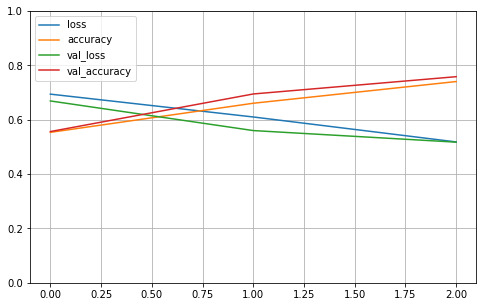

Train set ones/size 3179 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 339 / 629
Range of scores: 0.006808351 to 0.98812383
Score threshold 0.5
Prediction set ones/size 323 / 629


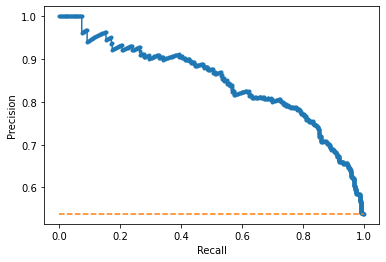

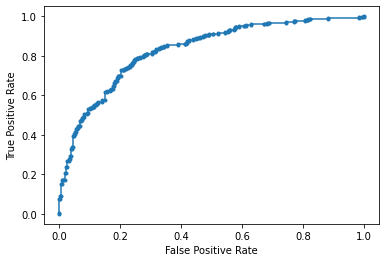

Accuracy: 75.83% Precision: 78.95% Recall: 75.22%
F1: 77.04% AUPRC: 84.59% AUROC: 82.93%
2023-02-06 19:44:53.827648
Fold 2
Model params (mean -1.87, wgt 0.37) (mean 0.02, wgt 0.63)
RCI threshold derived from training set: [-0.67378436]
FIT
2023-02-06 19:44:57.328891
Epoch 1/3
177/177 [==============================] - 3s 14ms/step - loss: 0.6893 - accuracy: 0.5535 - val_loss: 0.6581 - val_accuracy: 0.6455
Epoch 2/3
177/177 [==============================] - 2s 12ms/step - loss: 0.5949 - accuracy: 0.6689 - val_loss: 0.5326 - val_accuracy: 0.7409
Epoch 3/3
177/177 [==============================] - 2s 12ms/step - loss: 0.4871 - accuracy: 0.7599 - val_loss: 0.4915 - val_accuracy: 0.7520
PREDICT
2023-02-06 19:45:05.097933


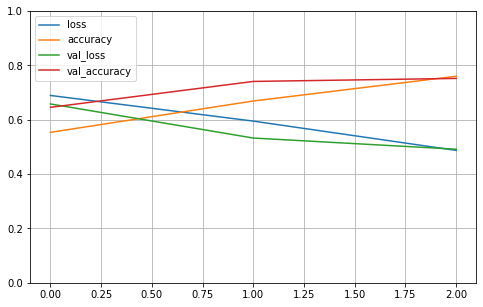

Train set ones/size 3200 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 350 / 629
Range of scores: 0.005074446 to 0.9984848
Score threshold 0.5
Prediction set ones/size 366 / 629


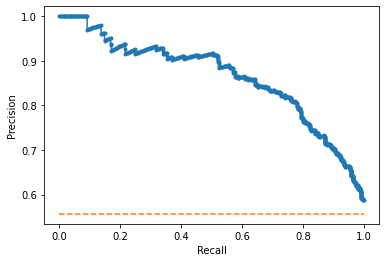

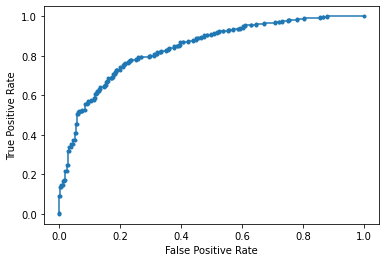

Accuracy: 75.20% Precision: 76.50% Recall: 80.00%
F1: 78.21% AUPRC: 86.41% AUROC: 83.89%
2023-02-06 19:45:05.986212
Fold 3
Model params (mean -1.87, wgt 0.36) (mean -0.00, wgt 0.64)
RCI threshold derived from training set: [-0.67848383]
FIT
2023-02-06 19:45:09.441130
Epoch 1/3
177/177 [==============================] - 3s 14ms/step - loss: 0.6930 - accuracy: 0.5473 - val_loss: 0.6813 - val_accuracy: 0.5628
Epoch 2/3
177/177 [==============================] - 2s 12ms/step - loss: 0.6516 - accuracy: 0.6067 - val_loss: 0.6163 - val_accuracy: 0.6343
Epoch 3/3
177/177 [==============================] - 2s 12ms/step - loss: 0.5397 - accuracy: 0.7277 - val_loss: 0.5238 - val_accuracy: 0.7424
PREDICT
2023-02-06 19:45:20.652895


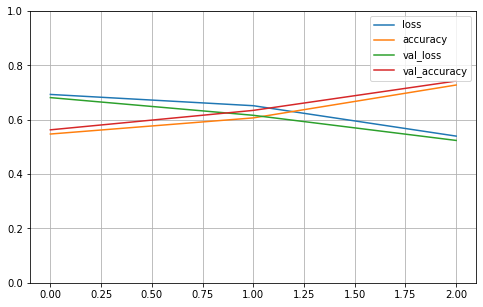

Train set ones/size 3212 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 350 / 629
Range of scores: 0.015771033 to 0.9914209
Score threshold 0.5
Prediction set ones/size 364 / 629


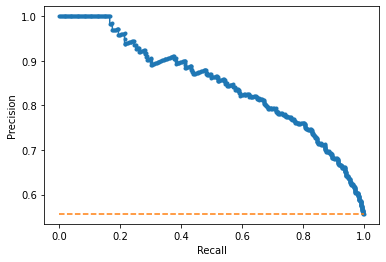

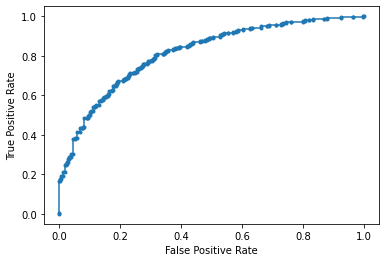

Accuracy: 74.24% Precision: 75.82% Recall: 78.86%
F1: 77.31% AUPRC: 84.94% AUROC: 81.49%
2023-02-06 19:45:21.323064
Fold 4
Model params (mean 0.02, wgt 0.63) (mean -1.89, wgt 0.37)
RCI threshold derived from training set: [-0.68760662]
FIT
2023-02-06 19:45:25.255045
Epoch 1/3
177/177 [==============================] - 3s 14ms/step - loss: 0.6902 - accuracy: 0.5557 - val_loss: 0.6566 - val_accuracy: 0.5930
Epoch 2/3
177/177 [==============================] - 2s 12ms/step - loss: 0.6282 - accuracy: 0.6472 - val_loss: 0.5589 - val_accuracy: 0.7107
Epoch 3/3
177/177 [==============================] - 2s 12ms/step - loss: 0.5291 - accuracy: 0.7376 - val_loss: 0.5523 - val_accuracy: 0.7266
PREDICT
2023-02-06 19:45:36.494175


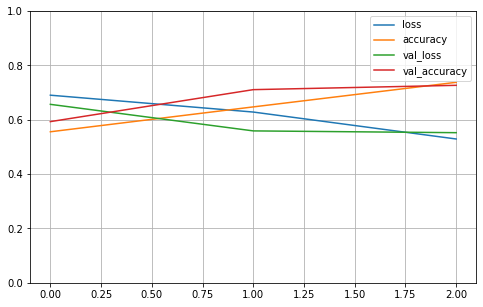

Train set ones/size 3192 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 372 / 629
Range of scores: 0.018079288 to 0.99857914
Score threshold 0.5
Prediction set ones/size 506 / 629


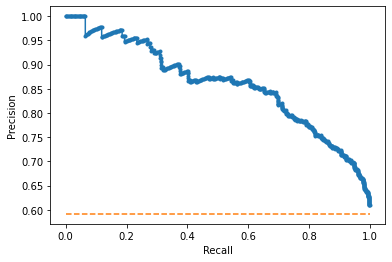

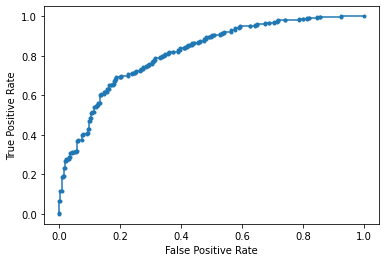

Accuracy: 72.66% Precision: 69.76% Recall: 94.89%
F1: 80.41% AUPRC: 86.00% AUROC: 81.64%
2023-02-06 19:45:37.225119
Fold 5
Model params (mean 0.02, wgt 0.63) (mean -1.87, wgt 0.37)
RCI threshold derived from training set: [-0.66968987]
FIT
2023-02-06 19:45:40.796418
Epoch 1/3
177/177 [==============================] - 3s 15ms/step - loss: 0.6955 - accuracy: 0.5519 - val_loss: 0.6668 - val_accuracy: 0.5453
Epoch 2/3
177/177 [==============================] - 2s 13ms/step - loss: 0.5998 - accuracy: 0.6670 - val_loss: 0.5880 - val_accuracy: 0.6645
Epoch 3/3
177/177 [==============================] - 2s 12ms/step - loss: 0.5092 - accuracy: 0.7535 - val_loss: 0.5496 - val_accuracy: 0.7393
PREDICT
2023-02-06 19:45:52.051896


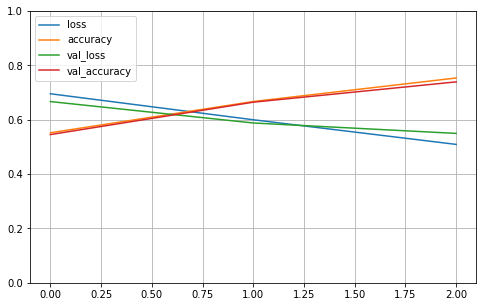

Train set ones/size 3174 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 343 / 629
Range of scores: 0.020406185 to 0.9977623
Score threshold 0.5
Prediction set ones/size 437 / 629


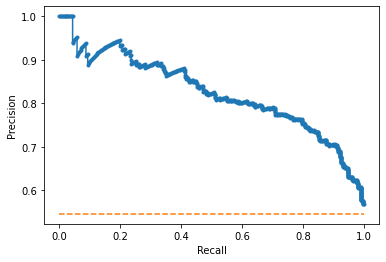

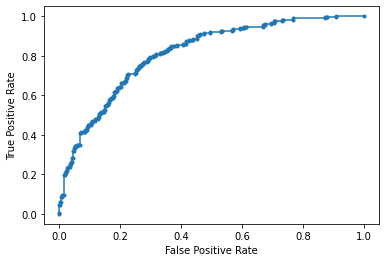

Accuracy: 73.93% Precision: 70.48% Recall: 89.80%
F1: 78.97% AUPRC: 82.50% AUROC: 81.35%
2023-02-06 19:45:52.746718
Fold 6
Model params (mean 0.02, wgt 0.63) (mean -1.87, wgt 0.37)
RCI threshold derived from training set: [-0.67540364]
FIT
2023-02-06 19:45:56.270350
Epoch 1/3
177/177 [==============================] - 3s 15ms/step - loss: 0.6932 - accuracy: 0.5454 - val_loss: 0.6724 - val_accuracy: 0.5771
Epoch 2/3
177/177 [==============================] - 2s 13ms/step - loss: 0.6406 - accuracy: 0.6207 - val_loss: 0.5454 - val_accuracy: 0.7154
Epoch 3/3
177/177 [==============================] - 2s 12ms/step - loss: 0.5377 - accuracy: 0.7224 - val_loss: 0.4902 - val_accuracy: 0.7488
PREDICT
2023-02-06 19:46:04.357134


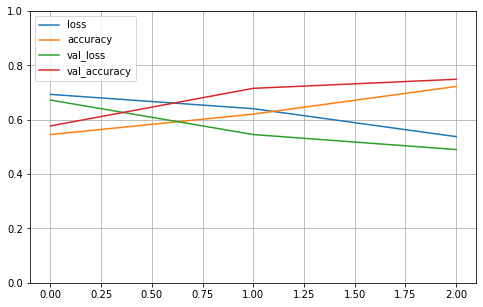

Train set ones/size 3187 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 363 / 629
Range of scores: 0.008467349 to 0.98871195
Score threshold 0.5
Prediction set ones/size 333 / 629


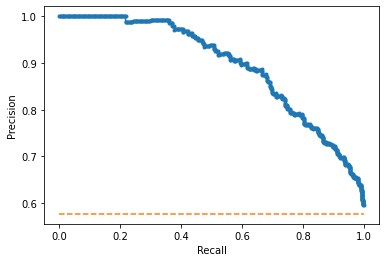

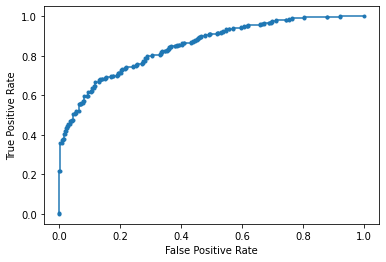

Accuracy: 74.88% Precision: 80.78% Recall: 74.10%
F1: 77.30% AUPRC: 89.60% AUROC: 85.02%
2023-02-06 19:46:05.217557
Fold 7
Model params (mean -1.89, wgt 0.36) (mean 0.02, wgt 0.64)
RCI threshold derived from training set: [-0.67751672]
FIT
2023-02-06 19:46:08.902820
Epoch 1/3
177/177 [==============================] - 3s 14ms/step - loss: 0.6973 - accuracy: 0.5539 - val_loss: 0.6590 - val_accuracy: 0.5994
Epoch 2/3
177/177 [==============================] - 2s 12ms/step - loss: 0.6071 - accuracy: 0.6633 - val_loss: 0.5730 - val_accuracy: 0.6868
Epoch 3/3
177/177 [==============================] - 2s 12ms/step - loss: 0.5263 - accuracy: 0.7403 - val_loss: 0.5154 - val_accuracy: 0.7472
PREDICT
2023-02-06 19:46:20.132098


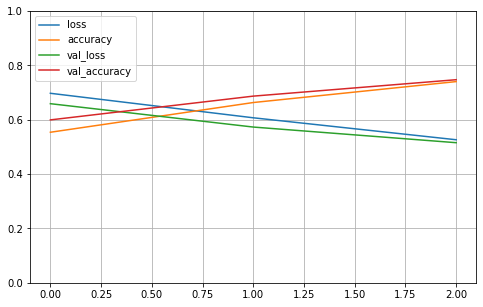

Train set ones/size 3200 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 350 / 629
Range of scores: 0.014832297 to 0.99512416
Score threshold 0.5
Prediction set ones/size 421 / 629


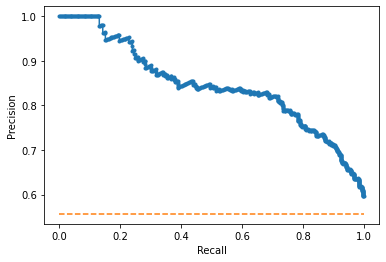

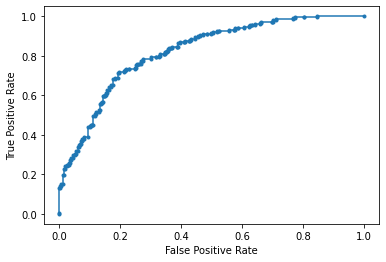

Accuracy: 74.72% Precision: 72.68% Recall: 87.43%
F1: 79.38% AUPRC: 84.48% AUROC: 82.25%
2023-02-06 19:46:20.859667
Fold 8
Model params (mean -1.88, wgt 0.37) (mean 0.01, wgt 0.63)
RCI threshold derived from training set: [-0.68083954]
FIT
2023-02-06 19:46:24.453268
Epoch 1/3
177/177 [==============================] - 3s 14ms/step - loss: 0.6880 - accuracy: 0.5560 - val_loss: 0.6517 - val_accuracy: 0.6582
Epoch 2/3
177/177 [==============================] - 2s 12ms/step - loss: 0.6055 - accuracy: 0.6659 - val_loss: 0.5477 - val_accuracy: 0.7027
Epoch 3/3
177/177 [==============================] - 2s 12ms/step - loss: 0.5123 - accuracy: 0.7447 - val_loss: 0.5129 - val_accuracy: 0.7266
PREDICT
2023-02-06 19:46:32.058418


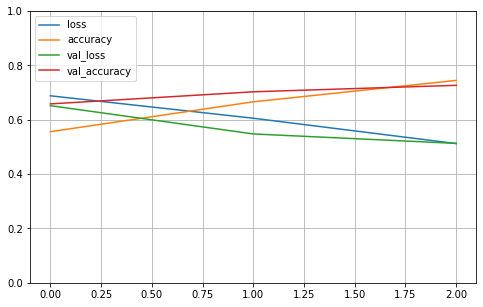

Train set ones/size 3198 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 364 / 629
Range of scores: 0.04050104 to 0.994221
Score threshold 0.5
Prediction set ones/size 446 / 629


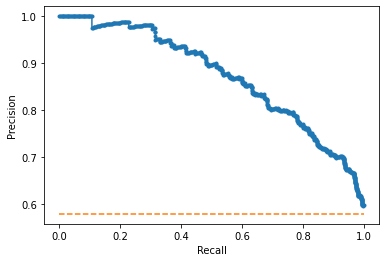

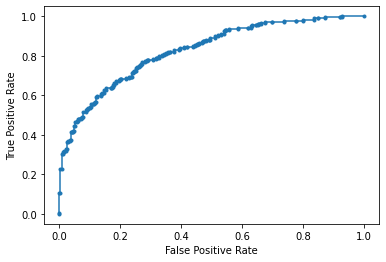

Accuracy: 72.66% Precision: 71.52% Recall: 87.64%
F1: 78.77% AUPRC: 87.37% AUROC: 82.65%
2023-02-06 19:46:32.905165
Fold 9
Model params (mean 0.01, wgt 0.64) (mean -1.89, wgt 0.36)
RCI threshold derived from training set: [-0.67683222]
FIT
2023-02-06 19:46:36.569000
Epoch 1/3
177/177 [==============================] - 3s 14ms/step - loss: 0.6942 - accuracy: 0.5590 - val_loss: 0.6667 - val_accuracy: 0.5914
Epoch 2/3
177/177 [==============================] - 2s 12ms/step - loss: 0.6359 - accuracy: 0.6314 - val_loss: 0.6781 - val_accuracy: 0.5723
Epoch 3/3
177/177 [==============================] - 2s 12ms/step - loss: 0.5478 - accuracy: 0.7189 - val_loss: 0.5715 - val_accuracy: 0.6789
PREDICT
2023-02-06 19:46:47.773749


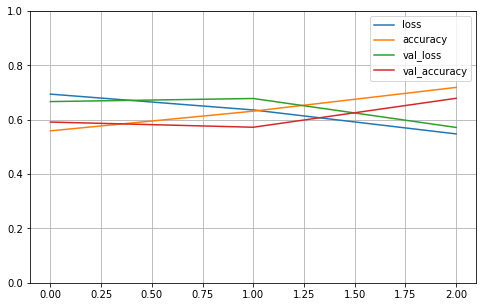

Train set ones/size 3200 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 350 / 629
Range of scores: 0.052853897 to 0.99683267
Score threshold 0.5
Prediction set ones/size 518 / 629


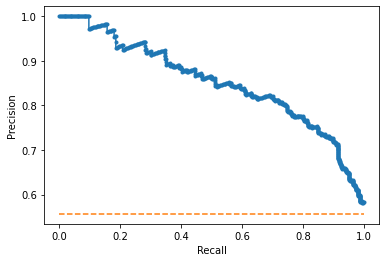

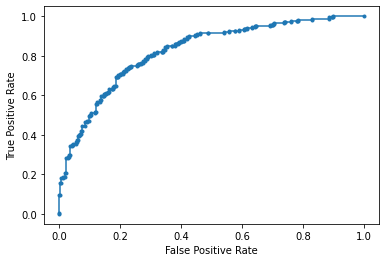

Accuracy: 67.89% Precision: 64.29% Recall: 95.14%
F1: 76.73% AUPRC: 85.24% AUROC: 82.55%
2023-02-06 19:46:48.450521
Fold 10
Model params (mean 0.01, wgt 0.63) (mean -1.90, wgt 0.37)
RCI threshold derived from training set: [-0.68573677]
FIT
2023-02-06 19:46:52.074722
Epoch 1/3
177/177 [==============================] - 3s 14ms/step - loss: 0.6854 - accuracy: 0.5579 - val_loss: 0.6463 - val_accuracy: 0.5939
Epoch 2/3
177/177 [==============================] - 2s 12ms/step - loss: 0.5948 - accuracy: 0.6872 - val_loss: 0.5436 - val_accuracy: 0.7293
Epoch 3/3
177/177 [==============================] - 2s 12ms/step - loss: 0.5169 - accuracy: 0.7499 - val_loss: 0.4905 - val_accuracy: 0.7500
PREDICT
2023-02-06 19:46:59.756590


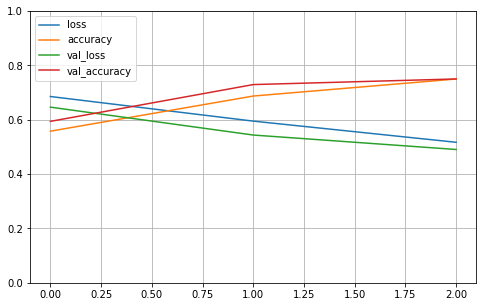

Train set ones/size 3197 / 5661
Compute valiation accuracy
Valid sizes (628, 4997) (628,)
Valid set ones/size 365 / 628
Range of scores: 0.013475037 to 0.9938871
Score threshold 0.5
Prediction set ones/size 382 / 628


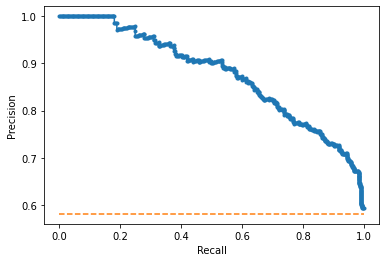

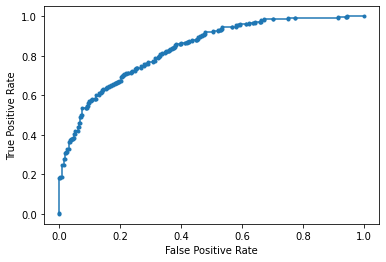

Accuracy: 75.00% Precision: 77.23% Recall: 80.82%
F1: 78.98% AUPRC: 87.73% AUROC: 83.53%
2023-02-06 19:47:00.616523

Completed cross validation 10 folds 3 epochs
 accuracy mean 73.70% +/- 2.29
 precision mean 73.80% +/- 4.97
 recall mean 84.39% +/- 7.66
 F1 mean 78.31% +/- 1.19
 AUPRC mean 85.89% +/- 2.00
 AUROC mean 82.73% +/- 1.16
Finished cell Line 13 K562

2023-02-06 19:47:02.072937
Start cell Line 14 IMR.90
Number of RCI values loaded 390
Num RCI: 390
Load sequence...
Cross validation...
2023-02-06 19:47:05.535909
splitting
Fold 1
Model params (mean 0.05, wgt 0.70) (mean -2.73, wgt 0.30)
RCI threshold derived from training set: [-0.79405874]
FIT
2023-02-06 19:47:06.388209
Epoch 1/3
70/70 [==============================] - 2s 17ms/step - loss: 0.7000 - accuracy: 0.5252 - val_loss: 0.6852 - val_accuracy: 0.5587
Epoch 2/3
70/70 [==============================] - 1s 12ms/step - loss: 0.6272 - accuracy: 0.6477 - val_loss: 0.5934 - val_accuracy: 0.6923
Epoch 3/3
70/70 [=================

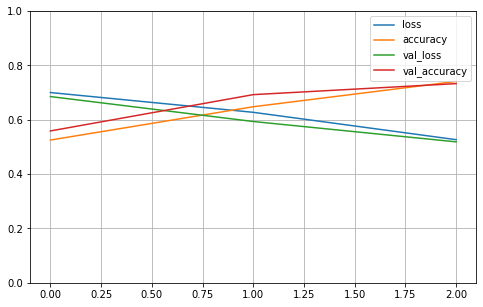

Train set ones/size 1095 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 110 / 247
Range of scores: 0.016579457 to 0.94521946
Score threshold 0.5
Prediction set ones/size 126 / 247


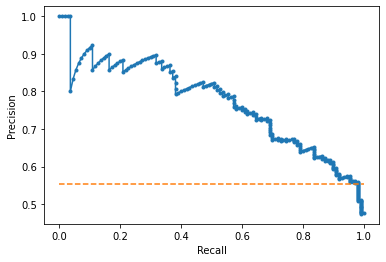

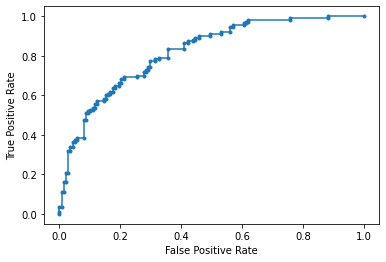

Accuracy: 73.28% Precision: 67.46% Recall: 77.27%
F1: 72.03% AUPRC: 77.16% AUROC: 81.86%
2023-02-06 19:47:12.980737
Fold 2
Model params (mean 0.03, wgt 0.70) (mean -2.73, wgt 0.30)
RCI threshold derived from training set: [-0.79287358]
FIT
2023-02-06 19:47:14.995926
Epoch 1/3
70/70 [==============================] - 2s 17ms/step - loss: 0.7073 - accuracy: 0.5378 - val_loss: 0.6794 - val_accuracy: 0.5789
Epoch 2/3
70/70 [==============================] - 1s 12ms/step - loss: 0.6361 - accuracy: 0.6315 - val_loss: 0.6204 - val_accuracy: 0.6356
Epoch 3/3
70/70 [==============================] - 1s 12ms/step - loss: 0.5386 - accuracy: 0.7324 - val_loss: 0.5473 - val_accuracy: 0.7166
PREDICT
2023-02-06 19:47:18.718793


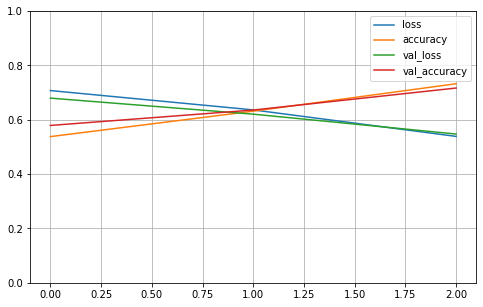

Train set ones/size 1085 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 120 / 247
Range of scores: 0.0065939967 to 0.9759269
Score threshold 0.5
Prediction set ones/size 86 / 247


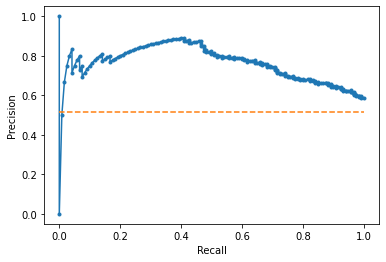

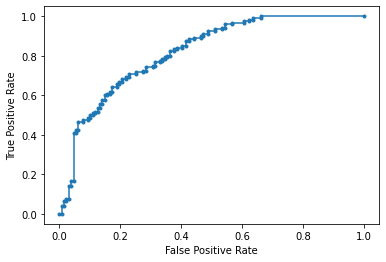

Accuracy: 71.66% Precision: 79.07% Recall: 56.67%
F1: 66.02% AUPRC: 75.90% AUROC: 81.93%
2023-02-06 19:47:19.499173
Fold 3
Model params (mean 0.05, wgt 0.69) (mean -2.68, wgt 0.31)
RCI threshold derived from training set: [-0.80088053]
FIT
2023-02-06 19:47:21.615692
Epoch 1/3
70/70 [==============================] - 2s 17ms/step - loss: 0.7045 - accuracy: 0.5216 - val_loss: 0.6935 - val_accuracy: 0.4980
Epoch 2/3
70/70 [==============================] - 1s 12ms/step - loss: 0.6623 - accuracy: 0.5982 - val_loss: 0.6252 - val_accuracy: 0.6680
Epoch 3/3
70/70 [==============================] - 1s 12ms/step - loss: 0.5656 - accuracy: 0.7000 - val_loss: 0.5578 - val_accuracy: 0.6721
PREDICT
2023-02-06 19:47:25.355529


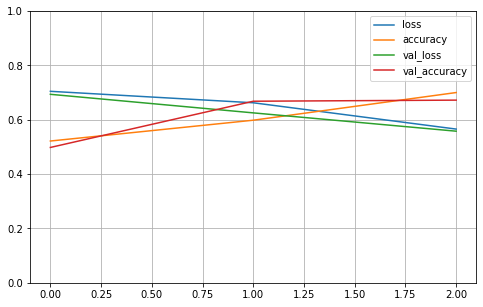

Train set ones/size 1087 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 118 / 247
Range of scores: 0.0046798163 to 0.9274765
Score threshold 0.5
Prediction set ones/size 81 / 247


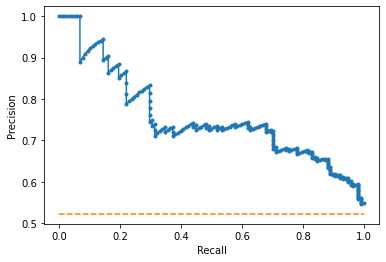

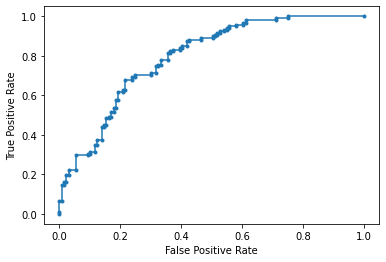

Accuracy: 67.21% Precision: 72.84% Recall: 50.00%
F1: 59.30% AUPRC: 75.45% AUROC: 79.27%
2023-02-06 19:47:26.116277
Fold 4
Model params (mean 0.03, wgt 0.69) (mean -2.67, wgt 0.31)
RCI threshold derived from training set: [-0.80590549]
FIT
2023-02-06 19:47:28.238967
Epoch 1/3
70/70 [==============================] - 2s 18ms/step - loss: 0.7053 - accuracy: 0.5167 - val_loss: 0.6876 - val_accuracy: 0.5263
Epoch 2/3
70/70 [==============================] - 1s 13ms/step - loss: 0.6610 - accuracy: 0.6032 - val_loss: 0.6573 - val_accuracy: 0.6073
Epoch 3/3
70/70 [==============================] - 1s 12ms/step - loss: 0.5433 - accuracy: 0.7311 - val_loss: 0.5122 - val_accuracy: 0.7247
PREDICT
2023-02-06 19:47:34.121612


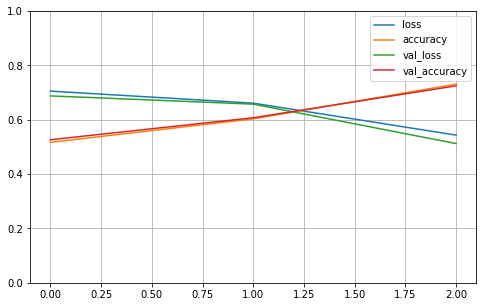

Train set ones/size 1083 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 124 / 247
Range of scores: 0.0008790603 to 0.9617324
Score threshold 0.5
Prediction set ones/size 142 / 247


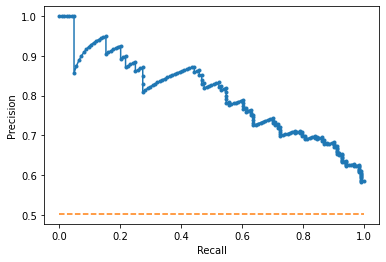

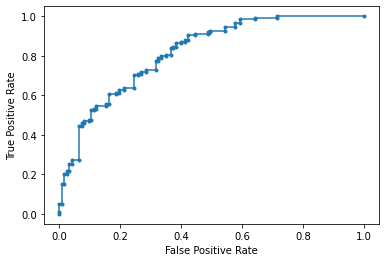

Accuracy: 72.47% Precision: 69.72% Recall: 79.84%
F1: 74.44% AUPRC: 80.14% AUROC: 81.79%
2023-02-06 19:47:34.787587
Fold 5
Model params (mean -2.65, wgt 0.31) (mean 0.04, wgt 0.69)
RCI threshold derived from training set: [-0.78626359]
FIT
2023-02-06 19:47:36.882666
Epoch 1/3
70/70 [==============================] - 2s 17ms/step - loss: 0.7038 - accuracy: 0.5122 - val_loss: 0.7033 - val_accuracy: 0.4656
Epoch 2/3
70/70 [==============================] - 1s 13ms/step - loss: 0.6573 - accuracy: 0.6095 - val_loss: 0.6018 - val_accuracy: 0.6842
Epoch 3/3
70/70 [==============================] - 1s 12ms/step - loss: 0.5382 - accuracy: 0.7374 - val_loss: 0.5358 - val_accuracy: 0.7166
PREDICT
2023-02-06 19:47:42.770402


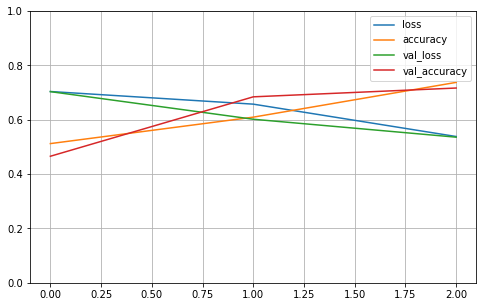

Train set ones/size 1087 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 117 / 247
Range of scores: 0.0021410985 to 0.94348234
Score threshold 0.5
Prediction set ones/size 121 / 247


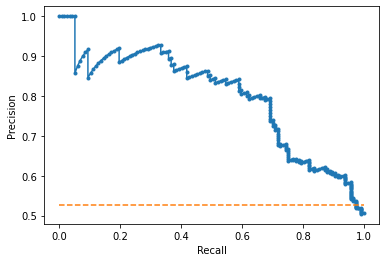

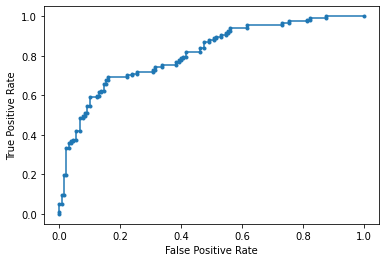

Accuracy: 71.66% Precision: 69.42% Recall: 71.79%
F1: 70.59% AUPRC: 79.81% AUROC: 81.21%
2023-02-06 19:47:43.444109
Fold 6
Model params (mean -2.73, wgt 0.31) (mean 0.06, wgt 0.69)
RCI threshold derived from training set: [-0.80238785]
FIT
2023-02-06 19:47:45.481892
Epoch 1/3
70/70 [==============================] - 2s 17ms/step - loss: 0.7072 - accuracy: 0.5198 - val_loss: 0.6905 - val_accuracy: 0.4858
Epoch 2/3
70/70 [==============================] - 1s 12ms/step - loss: 0.6603 - accuracy: 0.6140 - val_loss: 0.5607 - val_accuracy: 0.7409
Epoch 3/3
70/70 [==============================] - 1s 13ms/step - loss: 0.5682 - accuracy: 0.7189 - val_loss: 0.4792 - val_accuracy: 0.7652
PREDICT
2023-02-06 19:47:51.405842


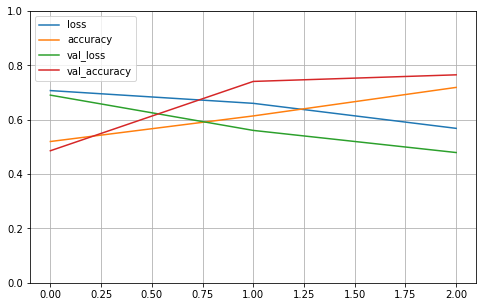

Train set ones/size 1089 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 116 / 247
Range of scores: 0.018574052 to 0.98214656
Score threshold 0.5
Prediction set ones/size 130 / 247


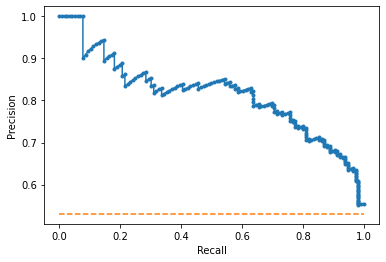

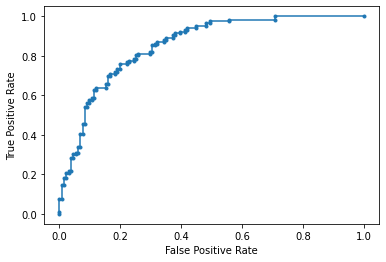

Accuracy: 76.52% Precision: 72.31% Recall: 81.03%
F1: 76.42% AUPRC: 81.49% AUROC: 85.46%
2023-02-06 19:47:52.051211
Fold 7
Model params (mean 0.04, wgt 0.69) (mean -2.69, wgt 0.31)
RCI threshold derived from training set: [-0.80697934]
FIT
2023-02-06 19:47:54.135350
Epoch 1/3
70/70 [==============================] - 2s 16ms/step - loss: 0.7003 - accuracy: 0.5324 - val_loss: 0.6892 - val_accuracy: 0.5425
Epoch 2/3
70/70 [==============================] - 1s 12ms/step - loss: 0.6734 - accuracy: 0.5775 - val_loss: 0.6540 - val_accuracy: 0.6356
Epoch 3/3
70/70 [==============================] - 1s 12ms/step - loss: 0.5729 - accuracy: 0.7131 - val_loss: 0.5750 - val_accuracy: 0.6964
PREDICT
2023-02-06 19:47:57.778949


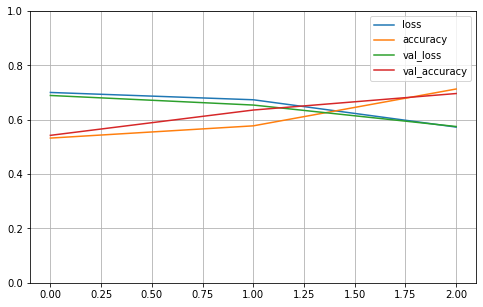

Train set ones/size 1080 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 127 / 247
Range of scores: 0.0018006748 to 0.97666615
Score threshold 0.5
Prediction set ones/size 132 / 247


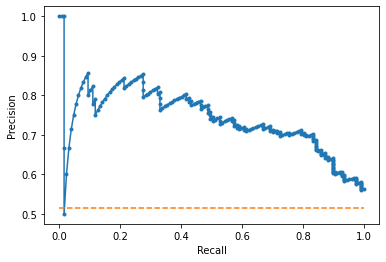

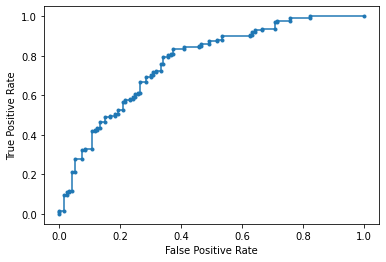

Accuracy: 69.64% Precision: 69.70% Recall: 72.44%
F1: 71.04% AUPRC: 74.02% AUROC: 76.89%
2023-02-06 19:47:58.566595
Fold 8
Model params (mean 0.05, wgt 0.69) (mean -2.71, wgt 0.31)
RCI threshold derived from training set: [-0.80091389]
FIT
2023-02-06 19:48:00.612400
Epoch 1/3
70/70 [==============================] - 2s 17ms/step - loss: 0.7080 - accuracy: 0.5308 - val_loss: 0.6920 - val_accuracy: 0.4919
Epoch 2/3
70/70 [==============================] - 1s 13ms/step - loss: 0.6750 - accuracy: 0.5669 - val_loss: 0.6709 - val_accuracy: 0.5325
Epoch 3/3
70/70 [==============================] - 1s 12ms/step - loss: 0.6082 - accuracy: 0.6488 - val_loss: 0.5711 - val_accuracy: 0.7154
PREDICT
2023-02-06 19:48:06.516316


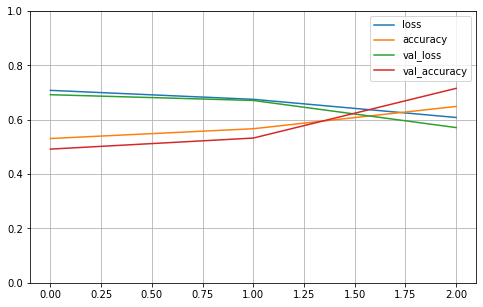

Train set ones/size 1081 / 2221
Compute valiation accuracy
Valid sizes (246, 4997) (246,)
Valid set ones/size 124 / 246
Range of scores: 0.011813722 to 0.9671823
Score threshold 0.5
Prediction set ones/size 94 / 246


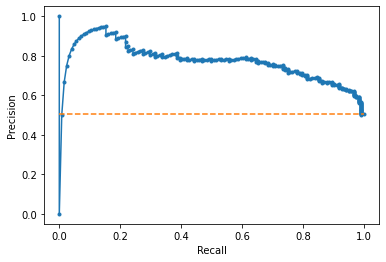

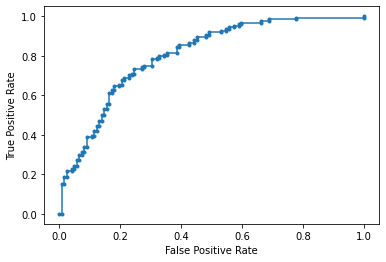

Accuracy: 71.54% Precision: 78.72% Recall: 59.68%
F1: 67.89% AUPRC: 77.03% AUROC: 80.47%
2023-02-06 19:48:07.170043
Fold 9
Model params (mean -2.71, wgt 0.32) (mean 0.03, wgt 0.68)
RCI threshold derived from training set: [-0.83232622]
FIT
2023-02-06 19:48:09.194150
Epoch 1/3
70/70 [==============================] - 2s 18ms/step - loss: 0.7026 - accuracy: 0.5462 - val_loss: 0.6301 - val_accuracy: 0.6667
Epoch 2/3
70/70 [==============================] - 1s 12ms/step - loss: 0.6522 - accuracy: 0.6213 - val_loss: 0.6136 - val_accuracy: 0.6748
Epoch 3/3
70/70 [==============================] - 1s 13ms/step - loss: 0.5505 - accuracy: 0.7267 - val_loss: 0.4570 - val_accuracy: 0.7886
PREDICT
2023-02-06 19:48:15.088092


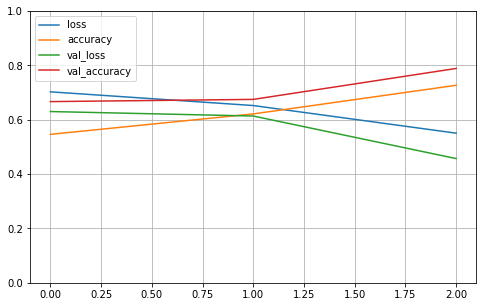

Train set ones/size 1272 / 2221
Compute valiation accuracy
Valid sizes (246, 4997) (246,)
Valid set ones/size 164 / 246
Range of scores: 0.15730716 to 0.9946333
Score threshold 0.5
Prediction set ones/size 210 / 246


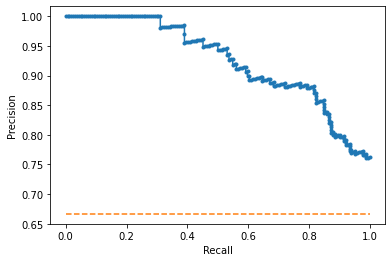

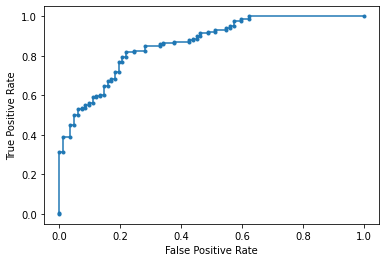

Accuracy: 78.86% Precision: 76.67% Recall: 98.17%
F1: 86.10% AUPRC: 92.54% AUROC: 86.20%
2023-02-06 19:48:15.722289
Fold 10
Model params (mean 0.02, wgt 0.70) (mean -2.75, wgt 0.30)
RCI threshold derived from training set: [-0.80368154]
FIT
2023-02-06 19:48:17.789151
Epoch 1/3
70/70 [==============================] - 2s 17ms/step - loss: 0.7062 - accuracy: 0.5124 - val_loss: 0.6848 - val_accuracy: 0.5935
Epoch 2/3
70/70 [==============================] - 1s 12ms/step - loss: 0.6682 - accuracy: 0.5939 - val_loss: 0.6622 - val_accuracy: 0.5772
Epoch 3/3
70/70 [==============================] - 1s 12ms/step - loss: 0.6070 - accuracy: 0.6740 - val_loss: 0.5557 - val_accuracy: 0.7073
PREDICT
2023-02-06 19:48:23.671525


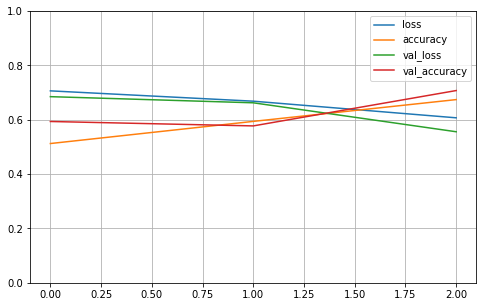

Train set ones/size 1088 / 2221
Compute valiation accuracy
Valid sizes (246, 4997) (246,)
Valid set ones/size 117 / 246
Range of scores: 0.004843214 to 0.9306128
Score threshold 0.5
Prediction set ones/size 107 / 246


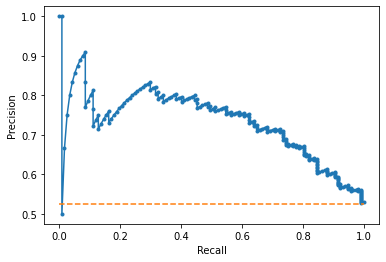

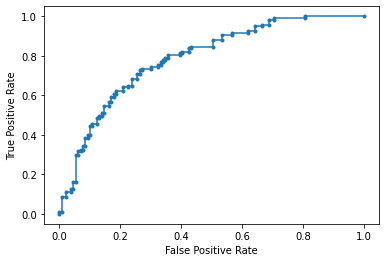

Accuracy: 70.73% Precision: 71.03% Recall: 64.96%
F1: 67.86% AUPRC: 73.23% AUROC: 78.76%
2023-02-06 19:48:24.338151

Completed cross validation 10 folds 3 epochs
 accuracy mean 72.36% +/- 3.31
 precision mean 72.69% +/- 4.11
 recall mean 71.19% +/- 14.02
 F1 mean 71.17% +/- 7.08
 AUPRC mean 78.68% +/- 5.56
 AUROC mean 81.38% +/- 2.84
Finished cell Line 14 IMR.90

2023-02-06 19:48:25.602370


In [10]:
for CELL_LINE in range(15):
    print(datetime.now())
    print('Start cell Line',CELL_LINE,all_cell_lines[CELL_LINE])
    loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE
    gene_to_rci = loader.load_gene_rci_values(filepath,CELL_LINE)
    print('Num RCI:', len(gene_to_rci.keys()))
    print('Load sequence...')
    filepath = DATA_DIR+SEQUENCE_FILE
    allids,allseq = loader.load_sequence(filepath)
    loader = None  # drop K-mer cache to save RAM

    print("Cross validation...")
    cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
    cvdo.set_sequences(allids,allseq)
    cvdo.set_rci_map(gene_to_rci)
    cv_accuracy, cv_precision, cv_recall, cv_f1, cv_auprc, cv_auroc = cvdo.do_cross_validation()   
    cvdo = None
    print("Completed cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
    print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy,ddof=1)))
    print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision,ddof=1)))
    print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall,ddof=1)))
    print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1,ddof=1)))
    print(" AUPRC mean %.2f%% +/- %.2f" % (np.mean(cv_auprc), np.std(cv_auprc,ddof=1)))
    print(" AUROC mean %.2f%% +/- %.2f" % (np.mean(cv_auroc), np.std(cv_auroc,ddof=1)))
    print('Finished cell Line',CELL_LINE,all_cell_lines[CELL_LINE])
    print()
print(datetime.now())